In [3]:
# ==============================================================
# MAIN NOTEBOOK 3.3–3.7
# Standalone: fits PCA on refs_backbone_2lzma.npy once, reuses everywhere
# ==============================================================

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
from matplotlib.patches import Polygon

plt.rcParams.update({
    "figure.dpi":150, "savefig.dpi":300,
    "axes.spines.top":False, "axes.spines.right":False,
    "axes.labelsize":11, "axes.titlesize":12, "legend.frameon":False
})

# I/O
OUT32  = Path("exports_panel3_2");     OUT32.mkdir(exist_ok=True)      # §3.3 exports
OUT33  = Path("exports_panel3_3");     OUT33.mkdir(exist_ok=True)      # §3.3 exports
OUT34  = Path("exports_panel3_4");     OUT34.mkdir(exist_ok=True)      # §3.4 exports
OUT35  = Path("exports_panel3_5");     OUT35.mkdir(exist_ok=True)        # §3.5
OUT36  = Path("exports_panel3_6");     OUT36.mkdir(exist_ok=True)      # §3.6 extras
OUT37  = Path("exports_panel3_7");     OUT37.mkdir(exist_ok=True)      # §3.6 extras

FIGDIR = Path("figs_export")
FIGDIR.mkdir(exist_ok=True)

print("Outputs:", OUT33.resolve(), OUT34.resolve(), OUT35.resolve(), OUT36.resolve(), OUT37.resolve())

# Required arrays
REF_NPY     = Path("refs_backbone_2lzma.npy")
BIO_NPY     = Path("bioemu_backbone_2lzma.npy")
BIOCLU_NPY  = Path("clustered_bioemu_backbone_2lzma.npy")
AF2_NPY     = Path("af2_backbone_2lzma.npy")           # AF2 backbone aligned to 2LZMA space
CONCOORD_NPY= Path("concoord_backbone_2lzma.npy")      # optional

# Labels
REF_LABELS       = Path("refs_backbone_2lzma_labels.csv")     # locate 2LZMA / 1L97A
AF2_LABELS_NEW   = Path("af2_backbone_2lzma_labels.csv")      # U-level + cluster_idx (preferred)

def _np(p: Path, required=True):
    if not p.exists():
        if required: raise FileNotFoundError(f"Missing required file: {p}")
        return None
    return np.load(p.as_posix())

# --- Init: load arrays & labels, fit PCA on references -----------------------
X_ref  = _np(REF_NPY, required=True)
X_bio  = _np(BIO_NPY, required=True)
X_bioc = _np(BIOCLU_NPY, required=True)
X_af2  = _np(AF2_NPY, required=True)
X_conc = _np(CONCOORD_NPY, required=False)

labels_ref = pd.read_csv(REF_LABELS, header=None, names=["PDB"])
ref_map = {p.lower(): i for i, p in enumerate(labels_ref["PDB"].astype(str))}
ix_2lzm  = ref_map.get("2lzma")
ix_1l97a = ref_map.get("1l97a")
assert ix_2lzm is not None and ix_1l97a is not None, "Could not find 2LZMA and/or 1L97A in labels file."

# AF2 labels (graceful fallback)
if AF2_LABELS_NEW.exists():
    lab = pd.read_csv(AF2_LABELS_NEW)
    if "cluster" in lab.columns:
        lab["U_level"] = lab["cluster"].str.extract(r"(U\d+)")
        lab["cluster_idx"] = lab["cluster"].str.extract(r"-(\d+)").astype(int)
else:
    lab = pd.DataFrame({"U_level":["U0"]*X_af2.shape[0], "cluster_idx":np.zeros(X_af2.shape[0],int)})

# Shared PCA (fit on references, project all sets)
ref_mean = X_ref.mean(axis=0, keepdims=True)
pca = PCA(n_components=3, svd_solver="full", random_state=0)
scores_ref   = pca.fit_transform(X_ref - ref_mean)
scores_bio   = pca.transform(X_bio - ref_mean)
scores_bioc  = pca.transform(X_bioc - ref_mean)
scores_af2   = pca.transform(X_af2 - ref_mean)
scores_conc  = None if X_conc is None else pca.transform(X_conc - ref_mean)

evr = pca.explained_variance_ratio_
print(f"PCA on references — EV1={100*evr[0]:.1f}%, EV2={100*evr[1]:.1f}%, EV3={100*evr[2]:.1f}%")


# Build tidy DFs
df_ref = pd.DataFrame(scores_ref[:, :3], columns=["EV1","EV2","EV3"])
df_ref["PDB"] = labels_ref["PDB"].values
df_ref["Highlight"] = ""
df_ref.loc[ix_2lzm,  "Highlight"] = "2LZM"
df_ref.loc[ix_1l97a, "Highlight"] = "1L97A"

df_bio = pd.DataFrame(scores_bio[:, :3], columns=["ev1","ev2","ev3"]).reset_index(names="row_index")
df_bio["model_id"] = [f"BioEmu_{i:04d}" for i in df_bio["row_index"]]

df_bioc = pd.DataFrame(scores_bioc[:, :3], columns=["ev1","ev2","ev3"]).reset_index(names="row_index")
df_bioc["model_id"] = [f"BioEmuClu_{i:04d}" for i in df_bioc["row_index"]]

df_af2 = pd.DataFrame(scores_af2[:, :3], columns=["ev1","ev2","ev3"]).reset_index(names="row_index")
df_af2["model_id"] = [f"AF2_{i:04d}" for i in df_af2["row_index"]]
for col in [c for c in ["U_level","cluster_idx","cluster"] if c in lab.columns]:
    df_af2[col] = lab[col].values[:len(df_af2)]

# Handy lists
ref_names = labels_ref["PDB"].astype(str).tolist()


Outputs: /home/jovyan/CHE701P_QS/PCA Generation/exports_panel3_3 /home/jovyan/CHE701P_QS/PCA Generation/exports_panel3_4 /home/jovyan/CHE701P_QS/PCA Generation/exports_panel3_5 /home/jovyan/CHE701P_QS/PCA Generation/exports_panel3_6 /home/jovyan/CHE701P_QS/PCA Generation/exports_panel3_7
PCA on references — EV1=86.4%, EV2=5.4%, EV3=1.4%


In [4]:
# --- §3.2: Reference PCA + RMSD ensemble stats -------------------------------
from scipy.spatial import ConvexHull

def reshape_coords(X: np.ndarray) -> np.ndarray:
    n_atoms = X.shape[1] // 3
    return X.reshape(X.shape[0], n_atoms, 3)

def rmsd_to_refs(samples_xyz: np.ndarray, refs_xyz: np.ndarray) -> np.ndarray:
    diffs2 = (samples_xyz[:, None, :, :] - refs_xyz[None, :, :, :])**2
    msd = diffs2.sum(axis=3).mean(axis=2)
    return np.sqrt(msd, dtype=np.float64)

# --- PCA stats (reference-only) ---
ev1_var = float(evr[0]) * 100
ev2_var = float(evr[1]) * 100
cum_var = float((evr[0] + evr[1]) * 100)

pts_ref_ev12 = scores_ref[:, :2]
hull_area_ev = float(ConvexHull(pts_ref_ev12).volume) if pts_ref_ev12.shape[0] >= 3 else np.nan
centroid_ev12 = pts_ref_ev12.mean(axis=0)

ev1_closed = float(scores_ref[ix_2lzm, 0])
ev1_open   = float(scores_ref[ix_1l97a, 0])
ev1_sep    = ev1_open - ev1_closed

# --- RMSD stats (closed ensemble spread) ---
R_ref = reshape_coords(X_ref)
rmsd_refs = rmsd_to_refs(R_ref, R_ref)   # (n_refs, n_refs)
tri = np.triu(np.ones_like(rmsd_refs, bool), k=1)
dist = rmsd_refs[tri]

median_rmsd = float(np.median(dist))
p95_rmsd    = float(np.percentile(dist, 95))
rmsd_2lzm_1l97a = float(rmsd_refs[ix_2lzm, ix_1l97a])

# Convex hull in RMSD space (using pairwise distances as coords)
pts_rmsd = rmsd_refs
try:
    hull_area_rmsd = float(ConvexHull(pts_rmsd).volume)
except Exception:
    hull_area_rmsd = np.nan

# --- Export main §3.2 numbers ---
df_32 = pd.DataFrame([{
    "EV1_var_percent": ev1_var,
    "EV2_var_percent": ev2_var,
    "cum_var_percent": cum_var,
    "hull_area_ev12": hull_area_ev,
    "centroid_ev1": centroid_ev12[0],
    "centroid_ev2": centroid_ev12[1],
    "ev1_2lzm": ev1_closed,
    "ev1_1l97a": ev1_open,
    "ev1_separation": ev1_sep,
    "hull_area_rmsd": hull_area_rmsd
}])
df_32.to_csv(OUT32/"ref_pca_stats.csv", index=False)
print("[§3.2] Wrote reference PCA stats:", OUT32/"ref_pca_stats.csv")

# --- Appendix RMSD stats (separate file) ---
df_rmsd = pd.DataFrame([{
    "median_rmsd": median_rmsd,
    "p95_rmsd": p95_rmsd,
    "rmsd_2lzm_1l97a": rmsd_2lzm_1l97a
}])
df_rmsd.to_csv(OUT32/"ref_rmsd_stats.csv", index=False)
print("[§3.2] Wrote reference RMSD appendix stats:", OUT32/"ref_rmsd_stats.csv")


# --- §3.2b: Two-cluster (Closed vs Open) on Reference PCA --------------------
# Why: Derive centroids for closed/open in EV space, and pick nearest reference exemplars.
features_ev = scores_ref[:, :3]

# Seed KMeans with known exemplars to anchor cluster identities.
init_centers = np.vstack([
    features_ev[ix_2lzm],   # Closed seed (2LZMA)
    features_ev[ix_1l97a],  # Open seed (1L97A)
])

kmeans = KMeans(n_clusters=2, init=init_centers, n_init=1, random_state=0)
labels_km = kmeans.fit_predict(features_ev)
centroids = kmeans.cluster_centers_  # shape (2,3)

# Map cluster IDs to semantic names using anchor members
cid_closed = int(labels_km[ix_2lzm])
cid_open   = int(labels_km[ix_1l97a])
if cid_closed == cid_open:
    # Fallback: separate by EV1 proximity to known anchors (rare)
    ev1_cent = centroids[:, 0]
    cid_closed = int(np.argmin(np.abs(ev1_cent - ev1_closed)))
    cid_open   = 1 - cid_closed

cluster_names = {cid_closed: "Closed", cid_open: "Open"}

# Nearest references to each centroid (Euclidean in EV space)
D = cdist(features_ev, centroids)  # (n_refs, 2)
nearest_idx = D.argmin(axis=0)     # per-centroid nearest ref index
nearest_dist = D[nearest_idx, np.arange(D.shape[1])]

# Summarize results
rows = []
for j in range(centroids.shape[0]):
    name = cluster_names.get(j, f"Cluster{j}")
    ni = int(nearest_idx[j])
    rows.append({
        "cluster_id": j,
        "cluster_name": name,
        "centroid_ev1": float(centroids[j, 0]),
        "centroid_ev2": float(centroids[j, 1]),
        "centroid_ev3": float(centroids[j, 2]),
        "nearest_ref_index": ni,
        "nearest_ref_pdb": str(labels_ref.iloc[ni, 0]),
        "nearest_ref_ev1": float(features_ev[ni, 0]),
        "nearest_ref_ev2": float(features_ev[ni, 1]),
        "nearest_ref_ev3": float(features_ev[ni, 2]),
        "distance": float(nearest_dist[j]),
    })

# Export centroids + nearest refs
df_centroids = pd.DataFrame(rows).sort_values("cluster_name")
out_centroids = OUT32 / "ref_pca_2cluster_centroids_and_nearest.csv"
df_centroids.to_csv(out_centroids, index=False)
print("[§3.2b] Wrote 2-cluster PCA centroids + nearest references:", out_centroids)

# Export full assignment for all references
df_ref_clusters = df_ref.copy()
df_ref_clusters["cluster_id"] = labels_km
df_ref_clusters["cluster_name"] = [cluster_names.get(cid, f"Cluster{cid}") for cid in labels_km]
df_ref_clusters["is_nearest_to_centroid"] = False
df_ref_clusters.loc[nearest_idx, "is_nearest_to_centroid"] = True
out_assign = OUT32 / "ref_pca_2cluster_assignment.csv"
df_ref_clusters.to_csv(out_assign, index=False)
print("[§3.2b] Wrote 2-cluster assignments:", out_assign)

# Console summary
print("[§3.2b] Centroids & exemplars:")
for r in rows:
    print(
        f"  {r['cluster_name']}: centroid(EV1..3)=({r['centroid_ev1']:.3f}, {r['centroid_ev2']:.3f}, {r['centroid_ev3']:.3f}) "
        f"→ nearest {r['nearest_ref_pdb']} (EV=({r['nearest_ref_ev1']:.3f}, {r['nearest_ref_ev2']:.3f}, {r['nearest_ref_ev3']:.3f}), d={r['distance']:.3f})"
    )


[§3.2] Wrote reference PCA stats: exports_panel3_2/ref_pca_stats.csv
[§3.2] Wrote reference RMSD appendix stats: exports_panel3_2/ref_rmsd_stats.csv
[§3.2b] Wrote 2-cluster PCA centroids + nearest references: exports_panel3_2/ref_pca_2cluster_centroids_and_nearest.csv
[§3.2b] Wrote 2-cluster assignments: exports_panel3_2/ref_pca_2cluster_assignment.csv
[§3.2b] Centroids & exemplars:
  Closed: centroid(EV1..3)=(-1.843, 0.080, 0.020) → nearest 137la (EV=(-1.786, 0.106, -0.229), d=0.257)
  Open: centroid(EV1..3)=(1.282, -0.056, -0.014) → nearest 1l97a (EV=(1.190, -0.295, 0.096), d=0.279)


### <span style="color: #FF0099;"> 3.3 AF2

In [3]:
# --- §3.3: AF2 ensemble stats per U-level ------------------------------------
from scipy.spatial import ConvexHull

def safe_hull_area(points: np.ndarray) -> float:
    if points is None or points.shape[0] < 3:
        return np.nan
    try:
        return float(ConvexHull(points).volume)
    except Exception:
        return np.nan

def axis_fraction(ev1_value: float, ev1_closed: float, ev1_open: float) -> float:
    """Fractional displacement along closed→open axis (0=2LZM, 1=1L97A)."""
    if ev1_open == ev1_closed:
        return np.nan
    return (ev1_value - ev1_closed) / (ev1_open - ev1_closed)

# reshape references for RMSD
R_ref = reshape_coords(X_ref)
R_af2 = reshape_coords(X_af2)

# RMSD to all refs
rmsd_af2_all = rmsd_to_refs(R_af2, R_ref)
idx_2lzm = ix_2lzm
idx_1l97a = ix_1l97a

rows = []
for u, g in df_af2.groupby("U_level", dropna=True):
    pts = g[["ev1","ev2"]].to_numpy()
    hull = safe_hull_area(pts)
    centroid = pts.mean(axis=0) if len(pts) else [np.nan, np.nan]
    frac = axis_fraction(centroid[0], ev1_closed, ev1_open)

    # median RMSDs at this depth
    rmsd_subset = rmsd_af2_all[g["row_index"].to_numpy()]
    med2lzm = np.median(rmsd_subset[:, idx_2lzm]) if rmsd_subset.size else np.nan
    medopen = np.median(rmsd_subset[:, idx_1l97a]) if rmsd_subset.size else np.nan

    rows.append({
        "U_level": u,
        "n_models": len(g),
        "hull_area_ev12": hull,
        "centroid_ev1": centroid[0],
        "centroid_ev2": centroid[1],
        "centroid_axis_fraction": frac,
        "median_rmsd_to_2lzm": med2lzm,
        "median_rmsd_to_1l97a": medopen
    })

df_33 = pd.DataFrame(rows).sort_values("U_level")
df_33.to_csv(OUT34/"af2_ensemble_stats.csv", index=False)
print("[§3.3] Wrote AF2 ensemble stats per U-level:", OUT33/"af2_ensemble_stats.csv")

# --- Optional: plDDT vs hinge displacement correlation -----------------------
if "plddt" in df_af2.columns:
    corr, _ = spearmanr(df_af2["plddt"], df_af2["ev1"])
    print(f"[§3.3] Spearman correlation pLDDT vs EV1 displacement = {corr:.3f}")


[§3.3] Wrote AF2 ensemble stats per U-level: exports_panel3_3/af2_ensemble_stats.csv


In [4]:
# =========================
# §3.3 — AF2 stats (per-U and grouped) with BioEmu-matching publishable columns
#   Publishable columns (identical to BioEmu):
#   Dataset | Median RMSD→1L97A (Å) | Median RMSD→2LZMA (Å) | 95th percentile RMSD→1L97A (Å) |
#   95th percentile RMSD→2LZMA (Å) | EV1–EV2 hull area (arb. units) | EV1 centroid (EV units) |
#   EV2 centroid (EV units) | Fraction ≤2 Å to 1L97A (%) | Fraction ≤2 Å to 2LZMA (%)
#   Appendix also saved with clear, detailed fields.
# =========================
from pathlib import Path
import re
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

# -------------------------
# Config / I/O
# -------------------------
OUT33 = Path(globals().get("OUT33", "exports_panel3_3")); OUT33.mkdir(parents=True, exist_ok=True)
PERU_PUB  = OUT33 / "af2_stats_perU_publishable.csv"
PERU_APP  = OUT33 / "af2_stats_perU_appendix.csv"
GRP_PUB   = OUT33 / "af2_stats_grouped_publishable.csv"
GRP_APP   = OUT33 / "af2_stats_grouped_appendix.csv"

N_BOOT = 1000
ALPHA  = 0.05
RNG    = np.random.default_rng(0)

# Optional override for unit detection when computing from coords:
# Set to "Å" or "nm" (None = auto-detect)
FORCE_RMSD_UNITS = globals().get("FORCE_RMSD_UNITS", None)

# -------------------------
# Preconditions
# -------------------------
need = ["df_af2", "ix_2lzm", "ix_1l97a"]
for v in need:
    assert v in globals(), f"Missing `{v}`."

assert {"model_id","ev1","ev2","U_level"}.issubset(df_af2.columns), \
    "df_af2 must have columns: model_id, ev1, ev2, U_level"

# -------------------------
# Helpers
# -------------------------
def _reshape_coords(X: np.ndarray) -> np.ndarray:
    n_atoms = X.shape[1] // 3
    return X.reshape(X.shape[0], n_atoms, 3)

def _rmsd_to_anchor(R_models: np.ndarray, R_anchor: np.ndarray) -> np.ndarray:
    diffs2 = (R_models - R_anchor[None, :, :])**2
    msd = diffs2.sum(axis=2).mean(axis=1)
    return np.sqrt(msd, dtype=np.float64)

def _detect_scale_to_angstrom(arr_like: np.ndarray, force=FORCE_RMSD_UNITS, label="RMSD"):
    """Auto-detect nm vs Å using p95; return (scaled_array, factor, detected_label)."""
    a = np.asarray(arr_like, float)
    p95 = float(np.nanpercentile(a, 95))
    if force == "nm":
        f, tag = 10.0, "nm (forced)"
    elif force == "Å":
        f, tag = 1.0, "Å (forced)"
    else:
        # Typical protein RMSD(Å) p95 ~ 2–8; nm ~0.2–0.8
        if p95 < 1.8:
            f, tag = 10.0, "nm (auto)"
        else:
            f, tag = 1.0, "Å (auto)"
    print(f"[AF2/units] {label}: p95={p95:.3f} → interpreted as {tag}; applying ×{f:g} → Å")
    return a * f, f, tag

def _safe_hull_area(P):
    if P.shape[0] < 3: return np.nan
    try: return float(ConvexHull(P).volume)
    except Exception: return np.nan

def _bootstrap_ci_percentile(vec: np.ndarray, q=95, n_boot=N_BOOT, alpha=ALPHA, rng=RNG):
    """Bootstrap CI for the q-th percentile (central value = sample percentile)."""
    v = np.asarray(vec, float); n = v.size
    boots = np.empty(n_boot, float)
    for b in range(n_boot):
        idx = rng.integers(0, n, n)
        boots[b] = np.percentile(v[idx], q)
    lo = float(np.percentile(boots, 100*alpha/2))
    hi = float(np.percentile(boots, 100*(1 - alpha/2)))
    val = float(np.percentile(v, q))
    return val, lo, hi

def _bootstrap_ci_median(vec: np.ndarray, n_boot=N_BOOT, alpha=ALPHA, rng=RNG):
    v = np.asarray(vec, float); n = v.size
    boots = np.empty(n_boot, float)
    for b in range(n_boot):
        idx = rng.integers(0, n, n)
        boots[b] = np.median(v[idx])
    lo = float(np.percentile(boots, 100*alpha/2))
    hi = float(np.percentile(boots, 100*(1 - alpha/2)))
    val = float(np.median(v))
    return val, lo, hi

def _pm_from_ci(val, lo, hi, ndp=2):
    half = max(0.0, (hi - lo)/2.0)
    return f"{val:.{ndp}f} ± {half:.{ndp}f}"

def _u_to_num(u):
    m = re.search(r'U(\d+)', str(u))
    return int(m.group(1)) if m else np.nan

# -------------------------
# Prepare AF2 working DF with RMSDs in Å
# -------------------------
af = df_af2[["model_id","ev1","ev2","U_level"]].copy()

# If precomputed Å columns exist, trust them; else compute & scale.
if {"rmsd_to_2lzm_A","rmsd_to_1l97a_A"}.issubset(df_af2.columns):
    af["rmsd_to_2lzm_A"]  = df_af2["rmsd_to_2lzm_A"].astype(float).values
    af["rmsd_to_1l97a_A"] = df_af2["rmsd_to_1l97a_A"].astype(float).values
else:
    assert "X_af2" in globals(), "X_af2 missing (n_models x 3*N_atoms)."
    if "R_ref" not in globals():
        assert "X_ref" in globals(), "Need R_ref or X_ref to get reference anchors."
        R_ref = _reshape_coords(X_ref)
    R_af2   = _reshape_coords(X_af2)
    R_closed = R_ref[ix_2lzm]
    R_open   = R_ref[ix_1l97a]
    r2_raw = _rmsd_to_anchor(R_af2, R_closed)
    rO_raw = _rmsd_to_anchor(R_af2, R_open)
    both = np.concatenate([r2_raw, rO_raw], axis=0)
    both_A, factor, tag = _detect_scale_to_angstrom(both, label="AF2 RMSD")
    af["rmsd_to_2lzm_A"]  = both_A[:len(r2_raw)]
    af["rmsd_to_1l97a_A"] = both_A[len(r2_raw):]

# Convenience
af["U_num"] = af["U_level"].map(_u_to_num)

# -------------------------
# Core computation on a subset → publishable + appendix rows
# -------------------------
PUB_COL_ORDER = [
    "Dataset",
    "Median RMSD→1L97A (Å)",
    "Median RMSD→2LZMA (Å)",
    "95th percentile RMSD→1L97A (Å)",
    "95th percentile RMSD→2LZMA (Å)",
    "EV1–EV2 hull area (arb. units)",
    "EV1 centroid (EV units)",
    "EV2 centroid (EV units)",
    "Fraction ≤2 Å to 1L97A (%)",
    "Fraction ≤2 Å to 2LZMA (%)",
]

def _compute_block(dataset_label: str, g: pd.DataFrame):
    g = g.copy()
    n = len(g)
    if n == 0:
        pub = {c: "NA" for c in PUB_COL_ORDER}
        pub["Dataset"] = dataset_label
        app = {
            "Dataset": dataset_label,
            "Number of models": 0,
            "EV1–EV2 hull area (arb. units)": np.nan,
            "EV1 centroid (EV units)": np.nan,
            "EV2 centroid (EV units)": np.nan,
            # Medians (Å)
            "Median RMSD→2LZMA (Å) — bootstrap median": np.nan,
            "Median RMSD→2LZMA (Å) — 95% CI low": np.nan,
            "Median RMSD→2LZMA (Å) — 95% CI high": np.nan,
            "Median RMSD→1L97A (Å) — bootstrap median": np.nan,
            "Median RMSD→1L97A (Å) — 95% CI low": np.nan,
            "Median RMSD→1L97A (Å) — 95% CI high": np.nan,
            # Sample quantiles (Å)
            "RMSD→2LZMA p5 (Å)": np.nan,
            "RMSD→2LZMA p50 (Å)": np.nan,
            "RMSD→2LZMA p95 (Å) [sample]": np.nan,
            "RMSD→1L97A p5 (Å)": np.nan,
            "RMSD→1L97A p50 (Å)": np.nan,
            "RMSD→1L97A p95 (Å) [sample]": np.nan,
            # 95th percentiles (bootstrap)
            "RMSD→2LZMA p95 (Å) — bootstrap median": np.nan,
            "RMSD→2LZMA p95 (Å) — 95% CI low": np.nan,
            "RMSD→2LZMA p95 (Å) — 95% CI high": np.nan,
            "RMSD→1L97A p95 (Å) — bootstrap median": np.nan,
            "RMSD→1L97A p95 (Å) — 95% CI low": np.nan,
            "RMSD→1L97A p95 (Å) — 95% CI high": np.nan,
            # Fractions
            "Fraction ≤2 Å to 2LZMA (%)": np.nan,
            "Fraction ≤2 Å to 1L97A (%)": np.nan,
        }
        return pub, app

    # PCA plane summaries
    P = g[["ev1","ev2"]].to_numpy(float)
    hull_area = _safe_hull_area(P)
    c_ev1 = float(np.mean(P[:,0]))
    c_ev2 = float(np.mean(P[:,1]))

    # RMSDs (Å)
    r2 = g["rmsd_to_2lzm_A"].to_numpy(float)
    rO = g["rmsd_to_1l97a_A"].to_numpy(float)

    # Baseline medians ± CI
    r2_med, r2_med_lo, r2_med_hi = _bootstrap_ci_median(r2)
    rO_med, rO_med_lo, rO_med_hi = _bootstrap_ci_median(rO)

    # 95th percentiles ± CI
    r2_p95, r2_p95_lo, r2_p95_hi = _bootstrap_ci_percentile(r2, q=95)
    rO_p95, rO_p95_lo, rO_p95_hi = _bootstrap_ci_percentile(rO, q=95)

    # Sample quantiles for appendix
    q = lambda x, p: float(np.percentile(x, p))
    r2_p5, r2_p50, r2_p95_s = q(r2,5), q(r2,50), q(r2,95)
    rO_p5, rO_p50, rO_p95_s = q(rO,5), q(rO,50), q(rO,95)

    # Fractions within 2 Å
    frac2 = float((r2 <= 2.0).mean()) * 100.0
    fracO = float((rO <= 2.0).mean()) * 100.0

    # Publishable row (BioEmu-matching headers)
    pub = {
        "Dataset": dataset_label,
        "Median RMSD→1L97A (Å)": _pm_from_ci(rO_med, rO_med_lo, rO_med_hi, ndp=2),
        "Median RMSD→2LZMA (Å)": _pm_from_ci(r2_med, r2_med_lo, r2_med_hi, ndp=2),
        "95th percentile RMSD→1L97A (Å)": _pm_from_ci(rO_p95, rO_p95_lo, rO_p95_hi, ndp=2),
        "95th percentile RMSD→2LZMA (Å)": _pm_from_ci(r2_p95, r2_p95_lo, r2_p95_hi, ndp=2),
        "EV1–EV2 hull area (arb. units)": f"{hull_area:.2f}" if np.isfinite(hull_area) else "NA",
        "EV1 centroid (EV units)": f"{c_ev1:.3f}",
        "EV2 centroid (EV units)": f"{c_ev2:.3f}",
        "Fraction ≤2 Å to 1L97A (%)": f"{fracO:.1f}",
        "Fraction ≤2 Å to 2LZMA (%)": f"{frac2:.1f}",
    }

    # Appendix row (clear, detailed)
    app = {
        "Dataset": dataset_label,
        "Number of models": int(n),
        "EV1–EV2 hull area (arb. units)": hull_area,
        "EV1 centroid (EV units)": c_ev1,
        "EV2 centroid (EV units)": c_ev2,

        # Median RMSD blocks (Å)
        "Median RMSD→2LZMA (Å) — bootstrap median": r2_med,
        "Median RMSD→2LZMA (Å) — 95% CI low": r2_med_lo,
        "Median RMSD→2LZMA (Å) — 95% CI high": r2_med_hi,
        "Median RMSD→1L97A (Å) — bootstrap median": rO_med,
        "Median RMSD→1L97A (Å) — 95% CI low": rO_med_lo,
        "Median RMSD→1L97A (Å) — 95% CI high": rO_med_hi,

        # Sample quantiles (Å)
        "RMSD→2LZMA p5 (Å)":  r2_p5,
        "RMSD→2LZMA p50 (Å)": r2_p50,
        "RMSD→2LZMA p95 (Å) [sample]": r2_p95_s,
        "RMSD→1L97A p5 (Å)":  rO_p5,
        "RMSD→1L97A p50 (Å)": rO_p50,
        "RMSD→1L97A p95 (Å) [sample]": rO_p95_s,

        # 95th percentiles (bootstrap)
        "RMSD→2LZMA p95 (Å) — bootstrap median": r2_p95,
        "RMSD→2LZMA p95 (Å) — 95% CI low": r2_p95_lo,
        "RMSD→2LZMA p95 (Å) — 95% CI high": r2_p95_hi,
        "RMSD→1L97A p95 (Å) — bootstrap median": rO_p95,
        "RMSD→1L97A p95 (Å) — 95% CI low": rO_p95_lo,
        "RMSD→1L97A p95 (Å) — 95% CI high": rO_p95_hi,

        # Fractions near thresholds
        "Fraction ≤2 Å to 2LZMA (%)": frac2,
        "Fraction ≤2 Å to 1L97A (%)": fracO,
    }
    return pub, app

# -------------------------
# Per-U tables
# -------------------------
peru_pub_rows, peru_app_rows = [], []
for u_level, g in af.groupby("U_level", dropna=False, sort=True):
    label = f"AF2 {u_level}"
    pub_row, app_row = _compute_block(label, g)
    peru_pub_rows.append(pub_row); peru_app_rows.append(app_row)

peru_pub = pd.DataFrame(peru_pub_rows)[PUB_COL_ORDER]
peru_app = pd.DataFrame(peru_app_rows)
peru_pub.to_csv(PERU_PUB, index=False)
peru_app.to_csv(PERU_APP, index=False)
print(f"[AF2/per-U] Wrote publishable → {PERU_PUB}")
print(f"[AF2/per-U] Wrote appendix    → {PERU_APP}")

# -------------------------
# Grouped U-depth tables
# -------------------------
groups = [
    ("AF2 U10–U18 (very shallow)", 10, 18),
    ("AF2 U20–U28 (intermediate)", 20, 28),
    ("AF2 U30–U150 (deep)",        30, 150),
]

grp_pub_rows, grp_app_rows = [], []
af["U_num"] = af["U_level"].map(_u_to_num)

for label, lo_u, hi_u in groups:
    g = af[af["U_num"].between(lo_u, hi_u, inclusive="both")].copy()
    pub_row, app_row = _compute_block(label, g)
    grp_pub_rows.append(pub_row); grp_app_rows.append(app_row)

grp_pub = pd.DataFrame(grp_pub_rows)[PUB_COL_ORDER]
grp_app = pd.DataFrame(grp_app_rows)
grp_pub.to_csv(GRP_PUB, index=False)
grp_app.to_csv(GRP_APP, index=False)
print(f"[AF2/grouped] Wrote publishable → {GRP_PUB}")
print(f"[AF2/grouped] Wrote appendix    → {GRP_APP}")

# Optional preview
try:
    from IPython.display import display
    print("\n[Preview] AF2 per-U — publishable:")
    display(peru_pub)
    print("\n[Preview] AF2 grouped — publishable:")
    display(grp_pub)
except Exception:
    pass


[AF2/units] AF2 RMSD: p95=0.227 → interpreted as nm (auto); applying ×10 → Å
[AF2/per-U] Wrote publishable → exports_panel3_3/af2_stats_perU_publishable.csv
[AF2/per-U] Wrote appendix    → exports_panel3_3/af2_stats_perU_appendix.csv
[AF2/grouped] Wrote publishable → exports_panel3_3/af2_stats_grouped_publishable.csv
[AF2/grouped] Wrote appendix    → exports_panel3_3/af2_stats_grouped_appendix.csv

[Preview] AF2 per-U — publishable:


Dataset Median RMSD→1L97A (Å) Median RMSD→2LZMA (Å)  \
0    AF2 U10           1.60 ± 0.10           1.42 ± 0.13   
1   AF2 U100           2.07 ± 0.11           0.71 ± 0.09   
2   AF2 U110           2.01 ± 0.06           0.76 ± 0.06   
3    AF2 U12           1.65 ± 0.15           1.31 ± 0.16   
4   AF2 U120           2.06 ± 0.06           0.71 ± 0.05   
5   AF2 U130           1.99 ± 0.08           0.79 ± 0.06   
6    AF2 U14           1.58 ± 0.12           1.26 ± 0.16   
7   AF2 U140           1.96 ± 0.11           0.81 ± 0.08   
8   AF2 U150           2.03 ± 0.07           0.75 ± 0.06   
9    AF2 U16           1.61 ± 0.20           1.26 ± 0.21   
10   AF2 U18           1.62 ± 0.06           1.19 ± 0.07   
11   AF2 U20           1.54 ± 0.10           1.26 ± 0.09   
12   AF2 U22           1.59 ± 0.18           1.25 ± 0.17   
13   AF2 U24           1.89 ± 0.15           1.02 ± 0.18   
14   AF2 U26           1.60 ± 0.11           1.22 ± 0.10   
15   AF2 U28           1.88 ± 0.10           0.92 ± 0.12   
16   AF2 U30           1.74 ± 0.07           1.05 ± 0.06   
17   AF2 U70           1.90 ± 0.06           0.87 ± 0.05   

   95th percentile RMSD→1L97A (Å) 95th percentile RMSD→2LZMA (Å)  \
0                     3.83 ± 1.24                    4.02 ± 1.22   
1                     2.35 ± 0.04                    1.04 ± 0.05   
2                     2.24 ± 0.08                    1.06 ± 0.10   
3                     2.58 ± 1.11                    2.69 ± 1.00   
4                     2.33 ± 0.08                    1.22 ± 0.18   
5                     2.33 ± 0.06                    1.03 ± 0.10   
6                     2.27 ± 1.01                    2.26 ± 0.89   
7                     2.32 ± 0.03                    1.05 ± 0.06   
8                     2.31 ± 0.07                    1.09 ± 0.16   
9                     2.42 ± 0.85                    2.01 ± 0.66   
10                    2.14 ± 0.18                    1.61 ± 0.14   
11                    2.05 ± 0.14                    1.64 ± 0.14   
12                    2.22 ± 0.20                    1.87 ± 0.12   
13                    2.33 ± 0.57                    1.60 ± 0.80   
14                    2.11 ± 0.23                    1.61 ± 0.10   
15                    2.29 ± 0.13                    1.50 ± 0.14   
16                    2.11 ± 0.11                    1.52 ± 0.24   
17                    2.22 ± 0.04                    1.12 ± 0.06   

   EV1–EV2 hull area (arb. units) EV1 centroid (EV units)  \
0                            3.86                  -0.618   
1                            0.23                  -1.366   
2                            0.22                  -1.262   
3                            2.63                  -0.606   
4                            0.29                  -1.329   
5                            0.20                  -1.326   
6                            1.71                  -0.583   
7                            0.15                  -1.274   
8                            0.24                  -1.323   
9                            1.02                  -0.737   
10                           0.53                  -0.820   
11                           0.40                  -0.672   
12                           0.56                  -0.644   
13                           1.21                  -0.956   
14                           0.56                  -0.698   
15                           0.38                  -1.045   
16                           0.37                  -0.907   
17                           0.17                  -1.169   

   EV2 centroid (EV units) Fraction ≤2 Å to 1L97A (%)  \
0                    0.093                       70.0   
1                   -0.081                       42.0   
2                   -0.046                       46.0   
3                    0.173                       82.0   
4                   -0.019                       34.0   
5                   -0.085                       52.0   
6           


[Preview] AF2 grouped — publishable:


Dataset Median RMSD→1L97A (Å) Median RMSD→2LZMA (Å)  \
0  AF2 U10–U18 (very shallow)           1.62 ± 0.04           1.27 ± 0.05   
1  AF2 U20–U28 (intermediate)           1.66 ± 0.05           1.14 ± 0.06   
2         AF2 U30–U150 (deep)           1.98 ± 0.03           0.79 ± 0.03   

  95th percentile RMSD→1L97A (Å) 95th percentile RMSD→2LZMA (Å)  \
0                    2.54 ± 0.74                    2.47 ± 0.69   
1                    2.24 ± 0.09                    1.72 ± 0.11   
2                    2.32 ± 0.02                    1.17 ± 0.06   

  EV1–EV2 hull area (arb. units) EV1 centroid (EV units)  \
0                           6.73                  -0.673   
1                           1.63                  -0.803   
2                           0.65                  -1.245   

  EV2 centroid (EV units) Fraction ≤2 Å to 1L97A (%)  \
0                   0.119                       80.8   
1                   0.097                       83.6   
2                  -0.035                       52.8   

  Fraction ≤2 Å to 2LZMA (%)  
0                       90.4  
1                       98.8  
2                      100.0

### <span style="color: #FF0099;"> 3.4 BioEmu 

In [5]:
# =========================
# §3.4 — BioEmu (all) + BioEmu (clustered): publishable + appendix CSVs
#   - Median ± CI (baseline) AND 95th percentile ± CI (coverage/outliers)
#   - p95 is computed on the sample, then bootstrapped for CI
#   - publishable uses "±" (half CI); units only in headers
#   - appendix has clear names; includes unit-detection provenance
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

# -------------------------
# Config / I/O
# -------------------------
OUT34 = Path(globals().get("OUT34", "exports_panel3_4")); OUT34.mkdir(parents=True, exist_ok=True)
PUB_CSV = OUT34 / "bioemu_stats_publishable.csv"
APP_CSV = OUT34 / "bioemu_stats_appendix.csv"

N_BOOT = 1000
ALPHA  = 0.05
RNG    = np.random.default_rng(0)

# Optional override for unit detection: set to "Å" or "nm" (None = auto)
FORCE_RMSD_UNITS = globals().get("FORCE_RMSD_UNITS", None)

# -------------------------
# Preconditions
# -------------------------
need_vars = ["df_bio", "X_bio", "X_ref", "df_ref"]
for v in need_vars:
    assert v in globals(), f"[§3.4] Missing required variable: {v}"

# Anchor indices (prefer ix_* if present; else find in ref_names)
def _find_anchor_index(names, needle_options=("2lzma","2lzm")):
    names_low = [str(s).lower() for s in names]
    for nd in needle_options:
        for i, s in enumerate(names_low):
            if nd in s:
                return i
    raise ValueError(f"Could not find any of {needle_options} in ref_names.")

if "ix_2lzm" in globals() and "ix_1l97a" in globals():
    i2, iO = int(ix_2lzm), int(ix_1l97a)
else:
    assert "ref_names" in globals(), "[§3.4] Need ref_names to locate anchors."
    i2 = _find_anchor_index(ref_names, ("2lzma","2lzm"))
    iO = _find_anchor_index(ref_names, ("1l97a",))

# -------------------------
# Helpers (fallbacks if not already present)
# -------------------------
if "reshape_coords" not in globals():
    def reshape_coords(X: np.ndarray) -> np.ndarray:
        n_atoms = X.shape[1] // 3
        return X.reshape(X.shape[0], n_atoms, 3)

if "rmsd_to_refs" not in globals():
    def rmsd_to_refs(samples_xyz: np.ndarray, refs_xyz: np.ndarray) -> np.ndarray:
        # pre-aligned coords; RMSD over all atoms
        diffs2 = (samples_xyz[:, None, :, :] - refs_xyz[None, :, :, :])**2
        msd = diffs2.sum(axis=3).mean(axis=2)
        return np.sqrt(msd, dtype=np.float64)

def _detect_scale_to_angstrom(arr_like: np.ndarray, force=FORCE_RMSD_UNITS, label="RMSD"):
    """Auto-detect nm vs Å using p95; return (scaled_array, factor, detected_label)."""
    a = np.asarray(arr_like, float)
    p95 = float(np.nanpercentile(a, 95))
    if force == "nm":
        f, tag = 10.0, "nm (forced)"
    elif force == "Å":
        f, tag = 1.0, "Å (forced)"
    else:
        # Typical RMSD(Å) p95 ~ 2–8; nm would be ~0.2–0.8
        if p95 < 1.8:
            f, tag = 10.0, "nm (auto)"
        else:
            f, tag = 1.0, "Å (auto)"
    print(f"[§3.4/units] {label}: p95={p95:.3f} → interpreted as {tag}; applying ×{f:g} → Å")
    return a * f, f, tag

def _bootstrap_ci_percentile(vec: np.ndarray, q=95, n_boot=N_BOOT, alpha=ALPHA, rng=RNG):
    """Bootstrap CI for the q-th percentile (central value = sample percentile)."""
    v = np.asarray(vec, float); n = v.size
    boots = np.empty(n_boot, float)
    for b in range(n_boot):
        idx = rng.integers(0, n, n)
        boots[b] = np.percentile(v[idx], q)
    lo = float(np.percentile(boots, 100*alpha/2))
    hi = float(np.percentile(boots, 100*(1 - alpha/2)))
    val = float(np.percentile(v, q))
    return val, lo, hi

def _bootstrap_ci_median(vec: np.ndarray, n_boot=N_BOOT, alpha=ALPHA, rng=RNG):
    v = np.asarray(vec, float); n = v.size
    boots = np.empty(n_boot, float)
    for b in range(n_boot):
        idx = rng.integers(0, n, n)
        boots[b] = np.median(v[idx])
    lo = float(np.percentile(boots, 100*alpha/2))
    hi = float(np.percentile(boots, 100*(1 - alpha/2)))
    val = float(np.median(v))
    return val, lo, hi

def _p5_50_95(x):
    x = np.asarray(x, float)
    return tuple(float(np.percentile(x, q)) for q in (5, 50, 95))

def _frac_within(x, thr):
    return float((np.asarray(x) <= thr).mean()) * 100.0

def _pm_from_ci(val, lo, hi, ndp=2):
    half = max(0.0, (hi - lo) / 2.0)
    return f"{val:.{ndp}f} ± {half:.{ndp}f}"

# Outlier counts (optional)
def _outlier_counts_for_ids(model_ids):
    if "all_wide" not in globals():
        return {"Outliers—PCA axis (#)": np.nan, "Outliers—PCA hull (#)": np.nan, "Outliers—RMSD axis (#)": np.nan}
    cols = ["is_outlier_pca_axis","is_outlier_pca_hull","is_outlier_rmsd_axis","model_id"]
    if not all(c in all_wide.columns for c in cols):
        return {"Outliers—PCA axis (#)": np.nan, "Outliers—PCA hull (#)": np.nan, "Outliers—RMSD axis (#)": np.nan}
    g = all_wide[all_wide["model_id"].isin(model_ids)]
    return {
        "Outliers—PCA axis (#)":  int(g["is_outlier_pca_axis"].sum()),
        "Outliers—PCA hull (#)":  int(g["is_outlier_pca_hull"].sum()),
        "Outliers—RMSD axis (#)": int(g["is_outlier_rmsd_axis"].sum()),
    }

# -------------------------
# Core computation for a dataset (BioEmu all / clustered)
# -------------------------
def _compute_block(dataset_label: str, df_scores: pd.DataFrame, X_coords: np.ndarray):
    # PCA-plane summaries
    pts = df_scores[["ev1","ev2"]].to_numpy(float)
    centroid = pts.mean(axis=0) if pts.size else (np.nan, np.nan)
    if pts.shape[0] >= 3:
        hull_area = float(ConvexHull(pts).volume)     # area in EV units^2
    else:
        hull_area = np.nan

    # RMSD vs references (→ Å)
    R = reshape_coords(X_coords)
    R_ref_local = reshape_coords(X_ref) if "R_ref" not in globals() else R_ref
    all_rmsd = rmsd_to_refs(R, R_ref_local)          # in source units
    all_rmsd_A, scale_factor, scale_tag = _detect_scale_to_angstrom(all_rmsd, label=f"{dataset_label}→Refs RMSD")

    r2 = all_rmsd_A[:, i2]   # → 2LZMA (Å)
    rO = all_rmsd_A[:, iO]   # → 1L97A (Å)

    # Sample quantiles & fractions
    r2_p5, r2_p50, r2_p95_sample = _p5_50_95(r2)
    rO_p5, rO_p50, rO_p95_sample = _p5_50_95(rO)
    frac2 = _frac_within(r2, 2.0)
    fracO = _frac_within(rO, 2.0)

    # Bootstrap median ± CI (baseline)
    r2_med, r2_med_lo, r2_med_hi = _bootstrap_ci_median(r2)
    rO_med, rO_med_lo, rO_med_hi = _bootstrap_ci_median(rO)

    # Bootstrap 95th ± CI (coverage/outliers)
    r2_p95, r2_lo, r2_hi = _bootstrap_ci_percentile(r2, q=95)
    rO_p95, rO_lo, rO_hi = _bootstrap_ci_percentile(rO, q=95)

    # Outliers (optional)
    out_cnts = _outlier_counts_for_ids(df_scores.get("model_id", pd.Series(dtype=str)))

    # Appendix row (clear names; units in headers)
    app_row = {
        "Dataset": dataset_label,
        "Number of models": int(len(df_scores)),
        "EV1–EV2 hull area (arb. units)": hull_area,
        "EV1 centroid (EV units)": float(centroid[0]),
        "EV2 centroid (EV units)": float(centroid[1]),

        # Median RMSD blocks
        "Median RMSD→2LZMA (Å) — bootstrap median": r2_med,
        "Median RMSD→2LZMA (Å) — 95% CI low": r2_med_lo,
        "Median RMSD→2LZMA (Å) — 95% CI high": r2_med_hi,
        "Median RMSD→1L97A (Å) — bootstrap median": rO_med,
        "Median RMSD→1L97A (Å) — 95% CI low": rO_med_lo,
        "Median RMSD→1L97A (Å) — 95% CI high": rO_med_hi,

        # Sample quantiles
        "RMSD→2LZMA p5 (Å)":  r2_p5,
        "RMSD→2LZMA p50 (Å)": r2_p50,
        "RMSD→2LZMA p95 (Å) [sample]": r2_p95_sample,
        "RMSD→1L97A p5 (Å)":  rO_p5,
        "RMSD→1L97A p50 (Å)": rO_p50,
        "RMSD→1L97A p95 (Å) [sample]": rO_p95_sample,

        # Bootstrapped p95 CI
        "RMSD→2LZMA p95 (Å) — bootstrap median": r2_p95,
        "RMSD→2LZMA p95 (Å) — 95% CI low": r2_lo,
        "RMSD→2LZMA p95 (Å) — 95% CI high": r2_hi,
        "RMSD→1L97A p95 (Å) — bootstrap median": rO_p95,
        "RMSD→1L97A p95 (Å) — 95% CI low": rO_lo,
        "RMSD→1L97A p95 (Å) — 95% CI high": rO_hi,

        # Fractions near thresholds
        "Fraction ≤2 Å to 2LZMA (%)": frac2,
        "Fraction ≤2 Å to 1L97A (%)": fracO,

        # Outliers (if available)
        **out_cnts,

        # Provenance
        "RMSD unit detection": f"{scale_tag}, ×{scale_factor:g} to Å"
    }

    # Publishable row (values with ± half-CI; units in headers)
    pub_row = {
        "Dataset": dataset_label,
        "Median RMSD→1L97A (Å)": _pm_from_ci(rO_med, rO_med_lo, rO_med_hi, ndp=2),
        "Median RMSD→2LZMA (Å)": _pm_from_ci(r2_med, r2_med_lo, r2_med_hi, ndp=2),
        "95th percentile RMSD→1L97A (Å)": _pm_from_ci(rO_p95, rO_lo, rO_hi, ndp=2),
        "95th percentile RMSD→2LZMA (Å)": _pm_from_ci(r2_p95, r2_lo, r2_hi, ndp=2),
        "EV1–EV2 hull area (arb. units)": f"{hull_area:.2f}",
        "EV1 centroid (EV units)": f"{centroid[0]:.3f}",
        "EV2 centroid (EV units)": f"{centroid[1]:.3f}",
        "Fraction ≤2 Å to 1L97A (%)": f"{fracO:.1f}",
        "Fraction ≤2 Å to 2LZMA (%)": f"{frac2:.1f}",
    }
    return app_row, pub_row

# -------------------------
# Run for BioEmu (all) and BioEmu (clustered, if present)
# -------------------------
app_rows, pub_rows = [], []

# BioEmu (all)
app_row, pub_row = _compute_block("BioEmu (all)", df_bio, X_bio)
app_rows.append(app_row); pub_rows.append(pub_row)

# BioEmu (clustered)
if "df_bioc" in globals() and "X_bioc" in globals() and df_bioc is not None and len(df_bioc):
    app_row_c, pub_row_c = _compute_block("BioEmu (clustered)", df_bioc, X_bioc)
    app_rows.append(app_row_c); pub_rows.append(pub_row_c)
else:
    print("[§3.4] No clustered BioEmu set found (df_bioc/X_bioc); skipping clustered rows.")

# -------------------------
# Save CSVs
# -------------------------
app_df = pd.DataFrame(app_rows)
pub_df = pd.DataFrame(pub_rows)

app_df.to_csv(APP_CSV, index=False)
pub_df.to_csv(PUB_CSV, index=False)

print(f"[§3.4] Wrote appendix   CSV → {APP_CSV}")
print(f"[§3.4] Wrote publishable CSV → {PUB_CSV}")

# Optional preview
try:
    from IPython.display import display
    print("\n[Preview] Publishable:")
    display(pub_df)
    print("\n[Preview] Appendix:")
    display(app_df)
except Exception:
    pass


[§3.4/units] BioEmu (all)→Refs RMSD: p95=0.342 → interpreted as nm (auto); applying ×10 → Å
[§3.4/units] BioEmu (clustered)→Refs RMSD: p95=0.768 → interpreted as nm (auto); applying ×10 → Å
[§3.4] Wrote appendix   CSV → exports_panel3_4/bioemu_stats_appendix.csv
[§3.4] Wrote publishable CSV → exports_panel3_4/bioemu_stats_publishable.csv

[Preview] Publishable:


Dataset Median RMSD→1L97A (Å) Median RMSD→2LZMA (Å)  \
0        BioEmu (all)           2.37 ± 0.03           1.01 ± 0.03   
1  BioEmu (clustered)           2.30 ± 0.81           1.70 ± 1.32   

  95th percentile RMSD→1L97A (Å) 95th percentile RMSD→2LZMA (Å)  \
0                    3.25 ± 0.09                    2.46 ± 0.11   
1                    6.29 ± 2.48                    7.44 ± 2.93   

  EV1–EV2 hull area (arb. units) EV1 centroid (EV units)  \
0                          71.90                  -1.398   
1                           9.18                   0.063   

  EV2 centroid (EV units) Fraction ≤2 Å to 1L97A (%)  \
0                   0.388                       22.5   
1                   1.498                       20.0   

  Fraction ≤2 Å to 2LZMA (%)  
0                       90.6  
1                       70.0


[Preview] Appendix:


Dataset  Number of models  EV1–EV2 hull area (arb. units)  \
0        BioEmu (all)              1895                       71.895639   
1  BioEmu (clustered)                10                        9.182773   

   EV1 centroid (EV units)  EV2 centroid (EV units)  \
0                -1.398340                 0.387830   
1                 0.062831                 1.498325   

   Median RMSD→2LZMA (Å) — bootstrap median  \
0                                  1.013791   
1                                  1.696869   

   Median RMSD→2LZMA (Å) — 95% CI low  Median RMSD→2LZMA (Å) — 95% CI high  \
0                            0.988478                             1.040793   
1                            1.294991                             3.933723   

   Median RMSD→1L97A (Å) — bootstrap median  \
0                                  2.369279   
1                                  2.301916   

   Median RMSD→1L97A (Å) — 95% CI low  ...  RMSD→2LZMA p95 (Å) — 95% CI high  \
0                            2.337477  ...                          2.573123   
1                            1.981039  ...                          8.536729   

   RMSD→1L97A p95 (Å) — bootstrap median  RMSD→1L97A p95 (Å) — 95% CI low  \
0                               3.253614                         3.172543   
1                               6.287150                         2.401521   

   RMSD→1L97A p95 (Å) — 95% CI high  Fraction ≤2 Å to 2LZMA (%)  \
0                          3.345398                    90.55409   
1                          7.363059                    70.00000   

   Fraction ≤2 Å to 1L97A (%)  Outliers—PCA axis (#)  Outliers—PCA hull (#)  \
0                   22.532982                    NaN                    NaN   
1                   20.000000                    NaN                    NaN   

   Outliers—RMSD axis (#)  RMSD unit detection  
0                     NaN  nm (auto), ×10 to Å  
1                     NaN  nm (auto), ×10 to Å  

[2 rows x 29 columns]

### <span style="color: #FF0099;"> 3.5 BioEmu and AF2 

In [6]:
# =========================
# §3.5 — AF2 (U10–U28 pooled) vs BioEmu (all): hull-area comparison
# =========================
from pathlib import Path
import re
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

# -------------------------
# I/O
# -------------------------
OUT_CSV = OUT35 / "hull_compare_AF2_U10_28_vs_BioEmu.csv"

# -------------------------
# Preconditions
# -------------------------
need = ["df_af2", "df_bio"]
for v in need:
    assert v in globals(), f"[§3.5] Missing `{v}`."

assert {"ev1","ev2","U_level"}.issubset(df_af2.columns), "[§3.5] df_af2 needs ev1, ev2, U_level"
assert {"ev1","ev2"}.issubset(df_bio.columns),          "[§3.5] df_bio needs ev1, ev2"

# -------------------------
# Helpers
# -------------------------
def _u_to_num(u):
    m = re.search(r"U(\d+)", str(u))
    return int(m.group(1)) if m else np.nan

def _safe_hull_area(P):
    """ConvexHull area in EV units^2 (uses ConvexHull.volume in 2D)."""
    P = np.asarray(P, float)
    if P.shape[0] < 3: 
        return np.nan
    try:
        return float(ConvexHull(P).volume)
    except Exception:
        return np.nan  # collinear or degenerate

# -------------------------
# AF2: pool U10–U28
# -------------------------
af2 = df_af2[["ev1","ev2","U_level"]].copy()
af2["U_num"] = af2["U_level"].map(_u_to_num)
mask = af2["U_num"].between(10, 28, inclusive="both")
af2_u10_28 = af2.loc[mask, ["ev1","ev2"]].to_numpy(float)

area_af2 = _safe_hull_area(af2_u10_28)
n_af2    = int(mask.sum())

# -------------------------
# BioEmu: all
# -------------------------
bio_pts = df_bio[["ev1","ev2"]].to_numpy(float)
area_bio = _safe_hull_area(bio_pts)
n_bio    = int(len(df_bio))

# -------------------------
# Assemble + save
# -------------------------
ratio = (area_af2 / area_bio) if (np.isfinite(area_af2) and np.isfinite(area_bio) and area_bio > 0) else np.nan
rows = [
    {"Dataset": "AF2 U10–U28 (pooled)", "n_models": n_af2, "hull_area_ev12": area_af2},
    {"Dataset": "BioEmu (all)",         "n_models": n_bio, "hull_area_ev12": area_bio},
]
df_out = pd.DataFrame(rows)
df_out["AF2/BioEmu hull area ratio"] = [ratio, ratio]  # handy to read side-by-side

df_out.to_csv(OUT_CSV, index=False)
print(f"[§3.5] Wrote hull comparison → {OUT_CSV}")
display(df_out)


[§3.5] Wrote hull comparison → exports_panel3_5/hull_compare_AF2_U10_28_vs_BioEmu.csv


Dataset  n_models  hull_area_ev12  AF2/BioEmu hull area ratio
0  AF2 U10–U28 (pooled)       500        6.728005                     0.09358
1          BioEmu (all)      1895       71.895639                     0.09358

[§3.5] RMSD_GLOBAL_THRESHOLD_A = 0.330 Å
[§3.5] Units: AF2 nm (auto), BioEmu nm (auto), BioEmu(clu) nm (auto)
[§3.5] Wrote hull comparison → exports_panel3_5/hull_compare_AF2_U10_28_vs_BioEmu.csv
[§3.5] RMSD exports → rmsd_vs_refs_wide.csv, rmsd_vs_refs_long.csv
[§3.5] Wrote S.4 input → exports_panel3_5/nearest_rmsd_refs.csv


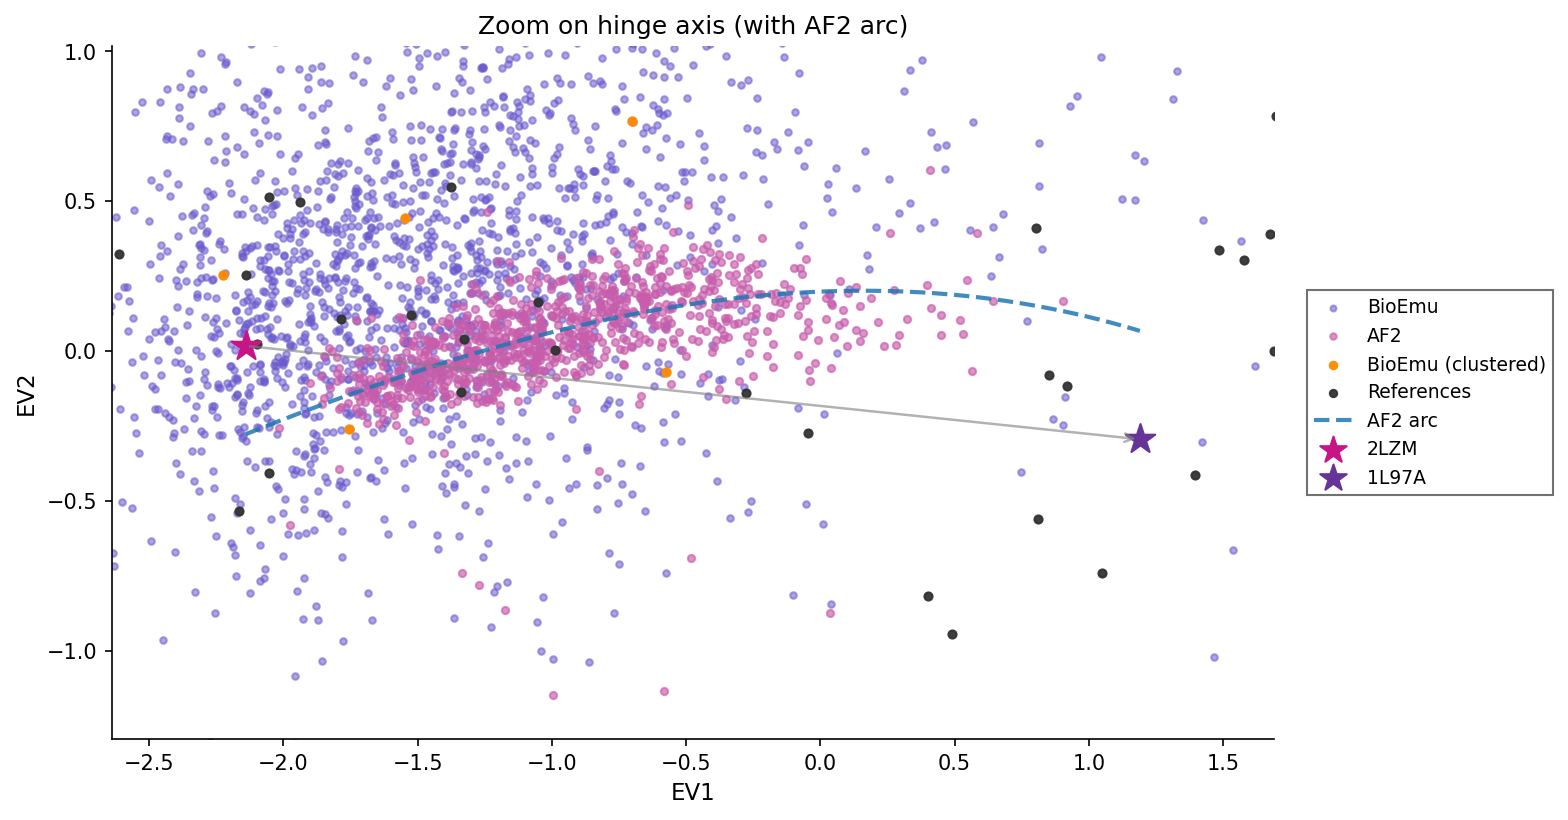

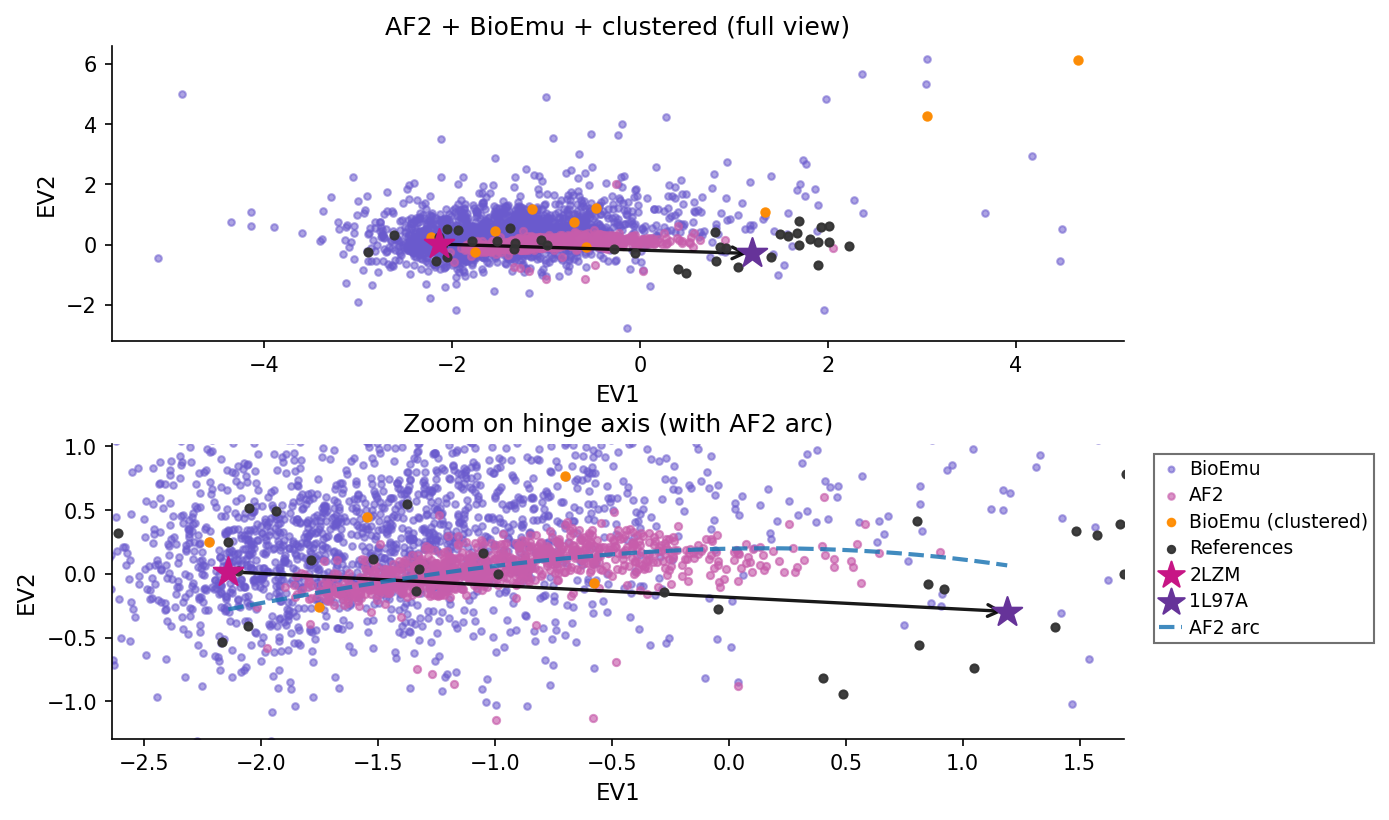


[Head] publishable_af2_outliers_by_U.csv


method U-depth  n_models  Identical (<1 Å) (#)  Similar (1–2 Å) (#)  \
0    AF2     U10        50                    43                    1   
1    AF2    U100        50                    50                    0   
2    AF2    U110        50                    50                    0   
3    AF2     U12        50                    44                    3   
4    AF2    U120        50                    50                    0   

   Distinct (>2 Å) (#)  RMSD > global thr (thr=0.33 Å) (#)  \
0                    6                                  50   
1                    0                                  50   
2                    0                                  50   
3                    3                                  50   
4                    0                                  50   

   PCA distance > cutoff (thr=0.45 EV) (#)  \
0                                       14   
1                                        0   
2                                        0   
3                                        4   
4                                        3   

   PCA hull outliers (scaled ×1.1) (#)  
0                                    3  
1                                    0  
2                                    0  
3                                    1  
4                                    0


[Head] publishable_grouped_outliers.csv


method                 Dataset  n_models  Identical (<1 Å) (#)  \
0                 AF2  U10–U18 (very shallow)       250                   234   
1                 AF2  U20–U28 (intermediate)       250                   247   
2                 AF2         U30–U150 (deep)       400                   400   
3              BioEmu            BioEmu (all)      1895                  1550   
4  BioEmu (clustered)      BioEmu (clustered)        10                     4   

   Similar (1–2 Å) (#)  Distinct (>2 Å) (#)  \
0                    4                   12   
1                    1                    2   
2                    0                    0   
3                  291                   54   
4                    4                    2   

   RMSD > global thr (thr=0.33 Å) (#)  \
0                                 249   
1                                 249   
2                                 399   
3                                1895   
4                                  10   

   PCA distance > cutoff (thr=0.45 EV) (#)  \
0                                       29   
1                                       13   
2                                        3   
3                                      498   
4                                        6   

   PCA hull outliers (scaled ×1.1) (#)  
0                                    4  
1                                    1  
2                                    0  
3                                  615  
4                                    6


[§3.5 outputs @ OUT35]
 - hull_compare_AF2_U10_28_vs_BioEmu.csv
 - publishable_af2_outliers_by_U.csv
 - publishable_grouped_outliers.csv
 - strict_any_outliers_rmsd1A.csv
 - strict_any_outliers_rmsd2A.csv
 - strict_any_outliers_rmsdThrA.csv
 - fig_outliers_strict_vs_any_global.{png,pdf}
 - rmsd_vs_refs/rmsd_vs_refs_wide.csv
 - rmsd_vs_refs/rmsd_vs_refs_long.csv
 - nearest_rmsd_refs.csv  (Å; also available as `rmsd_tbl` in memory)


In [19]:
# =========================
# §3.5 — AF2/BioEmu: RMSD vs refs (Å) → hull compare, outlier tables, figure, and RMSD exports
#   * RMSD buckets: <1 Å (Identical), 1–2 Å (Similar), >2 Å (Distinct)
#   * Two PCA outlier cols: distance (> cutoff) and hull (scaled hull)
#   * Computes RMSD matrices ONCE, converts to Å (nm auto/forced)
#   * Writes OUT35/nearest_rmsd_refs.csv (for S.4 coverage)
#   * AF2 U10–U28 pooled vs BioEmu hull-area comparison
#   * AF2 per-U publishable outlier table (new buckets + PCA distance + PCA hull)
#   * Grouped publishable table: AF2 (3 ranges), BioEmu (all), BioEmu (clustered if present)
#   * Strict vs Any outliers (RMSD 1Å, 2Å, global thr) → CSVs + figure
#   * RMSD exports (wide + long) under OUT35/rmsd_vs_refs/
# =========================
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from matplotlib.path import Path as MplPath
from scipy.interpolate import UnivariateSpline

# -------------------------
# I/O & required globals
# -------------------------
OUT35 = Path(globals().get("OUT35", "exports_panel3_5")); OUT35.mkdir(parents=True, exist_ok=True)

need = ["df_ref","labels_ref","X_ref","df_af2","X_af2","df_bio","X_bio"]
for v in need:
    assert v in globals(), f"[§3.5] Missing `{v}`."

HAS_BIOC = ("df_bioc" in globals() and "X_bioc" in globals() and df_bioc is not None and len(df_bioc))

# thresholds & options
try:
    RMSD_GLOBAL_THRESHOLD_A = float(p95_rmsd)  # from §3.2 if in memory
except NameError:
    # fallback: load from §3.2 outputs
    OUT32 = Path(globals().get("OUT32", "exports_panel3_2"))
    v = None
    for cand, col in [
        (OUT32 / "table_3_1_appendix_combined.csv", "pairwise_p95_rmsd_A"),
        (OUT32 / "ref_rmsd_stats.csv",               "p95_rmsd"),
        (OUT32 / "Table3_1_ref_rmsd_stats.csv",      "pairwise_p95_rmsd_A"),
    ]:
        if cand.exists():
            try:
                v = float(pd.read_csv(cand)[col].iloc[0]); break
            except Exception:
                pass
    if v is None: raise RuntimeError("Could not locate p95 RMSD from §3.2.")
    RMSD_GLOBAL_THRESHOLD_A = v

# New benchmark buckets
RMSD_IDENTICAL_MAX_A = 1.0   # < 1 Å → identical/noise
RMSD_SIMILAR_MAX_A   = 2.0   # 1–2 Å → similar but displaced
# > 2 Å → distinct state

PCA_GLOBAL_CUTOFF = globals().get("PCA_GLOBAL_CUTOFF", None)   # if None → auto p95 on AF2 PCA-nearest
HULL_SCALE        = float(globals().get("HULL_SCALE", 1.10))   # scaled ref hull for hull-outlier
FORCE_RMSD_UNITS  = globals().get("FORCE_RMSD_UNITS", None)    # "Å", "nm", or None (auto)

print(f"[§3.5] RMSD_GLOBAL_THRESHOLD_A = {RMSD_GLOBAL_THRESHOLD_A:.3f} Å")

# -------------------------
# Helpers
# -------------------------
def reshape_coords(X: np.ndarray) -> np.ndarray:
    n_atoms = X.shape[1] // 3
    return X.reshape(X.shape[0], n_atoms, 3)

def rmsd_to_refs(samples_xyz: np.ndarray, refs_xyz: np.ndarray) -> np.ndarray:
    diffs2 = (samples_xyz[:, None, :, :] - refs_xyz[None, :, :, :])**2
    msd = diffs2.sum(axis=3).mean(axis=2)
    return np.sqrt(msd, dtype=np.float64)

def scale_to_angstrom(arr_like, force=FORCE_RMSD_UNITS):
    a = np.asarray(arr_like, float)
    if force == "Å": return a, 1.0, "Å (forced)"
    if force == "nm": return a*10.0, 10.0, "nm (forced)"
    p95 = float(np.nanpercentile(a, 95))
    if p95 < 1.8: return a*10.0, 10.0, "nm (auto)"
    return a, 1.0, "Å (auto)"

def _u_to_num(u):
    m = re.search(r"U(\d+)", str(u))
    return int(m.group(1)) if m else np.nan

def _safe_hull_area(P):
    P = np.asarray(P, float)
    if P.shape[0] < 3: return np.nan
    try: return float(ConvexHull(P).volume)
    except Exception: return np.nan

# Anchors & ref names
ref_names = labels_ref["PDB"].astype(str).tolist()
names_low = [s.lower() for s in ref_names]
def _find_idx(code):
    code = code.lower()
    for i,s in enumerate(names_low):
        if code in s: return i
    raise ValueError(f"Reference containing '{code}' not found.")
ix_2lzm  = globals().get("ix_2lzm",  _find_idx("2lzm"))
ix_1l97a = globals().get("ix_1l97a", _find_idx("1l97a"))

# -------------------------
# Reference PCA hull (scaled) for hull-outlier flags
# -------------------------
EV_refs = df_ref[["EV1","EV2"]].to_numpy(float)
ref_hull = ConvexHull(EV_refs) if EV_refs.shape[0] >= 3 else None
if ref_hull is not None:
    poly   = EV_refs[ref_hull.vertices]
    center = poly.mean(axis=0)
    poly_scaled = center + HULL_SCALE * (poly - center)
    hull_path = MplPath(poly_scaled)
else:
    hull_path = None

# -------------------------
# Build RMSD matrices ONCE (Å), PCA nearest distances, hull flags
# -------------------------
R_ref = reshape_coords(X_ref)

def compute_block(method_name, df_scores, X_models):
    # PCA coords and nearest PCA distance
    if {"ev1","ev2"}.issubset(df_scores.columns):
        P = df_scores[["ev1","ev2"]].to_numpy(float)
    else:
        P = df_scores[["EV1","EV2"]].to_numpy(float)
    D_pca = cdist(P, EV_refs, metric="euclidean")
    nearest_pca = D_pca.min(axis=1)

    # RMSD matrix → Å
    R = reshape_coords(X_models)
    M_src = rmsd_to_refs(R, R_ref)                      # source units
    M_A, factor, tag = scale_to_angstrom(M_src)         # to Å
    # nearest RMSD (Å)
    nearest_rmsd = M_A.min(axis=1)
    nearest_names = np.array(ref_names)[M_A.argmin(axis=1)]

    # hull outlier
    if hull_path is not None:
        inside = hull_path.contains_points(P); out_hull = ~inside
    else:
        out_hull = np.zeros(P.shape[0], bool)

    # IDs + metadata
    model_ids = df_scores.get("model_id", pd.Series([f"{method_name}_{i:04d}" for i in range(len(df_scores))])).astype(str).values
    out_flags = pd.DataFrame({
        "model_id": model_ids,
        "method": method_name,
        "nearest_ref_RMSD": nearest_rmsd,
        "nearest_ref_name_rmsd": nearest_names,
        "nearest_ref_PCA": nearest_pca,
        "is_outlier_pca_hull": out_hull
    })
    if "U_level" in df_scores.columns:
        out_flags["U_level"] = df_scores["U_level"].values
        out_flags["U_num"]   = out_flags["U_level"].map(_u_to_num)

    # Wide RMSD per-reference (Å)
    wide = pd.DataFrame(M_A, columns=ref_names)
    wide.insert(0,"method",method_name)
    wide.insert(0,"model_id",model_ids)
    # convenience columns
    wide["rmsd_to_2LZM_A"]  = M_A[:, ix_2lzm]
    wide["rmsd_to_1L97A_A"] = M_A[:, ix_1l97a]
    wide["nearest_ref_RMSD"] = nearest_rmsd
    wide["nearest_ref_name"] = nearest_names
    if "U_level" in df_scores.columns:
        wide["U_level"] = df_scores["U_level"].values
        wide["U_num"]   = wide["U_level"].map(_u_to_num)

    return out_flags, wide, P, (factor, tag)

# AF2
af2_flags, af2_wide, af2_pts, (f_af2, tag_af2) = compute_block("AF2", df_af2, X_af2)
# BioEmu (all)
bio_flags, bio_wide, bio_pts, (f_bio, tag_bio) = compute_block("BioEmu", df_bio, X_bio)
# BioEmu (clustered)
if HAS_BIOC:
    bioc_flags, bioc_wide, bioc_pts, (f_bioc, tag_bioc) = compute_block("BioEmu (clustered)", df_bioc, X_bioc)
else:
    bioc_flags = pd.DataFrame(columns=["model_id","method","nearest_ref_RMSD","nearest_ref_name_rmsd","nearest_ref_PCA","is_outlier_pca_hull"])
    bioc_wide  = pd.DataFrame()

print(f"[§3.5] Units: AF2 {tag_af2}, BioEmu {tag_bio}" + (f", BioEmu(clu) {tag_bioc}" if HAS_BIOC else ""))

# -------------------------
# AF2 (U10–U28 pooled) vs BioEmu hull-area comparison (EV units^2)
# -------------------------
af2_tmp = df_af2[["ev1","ev2","U_level"]].copy()
af2_tmp["U_num"] = af2_tmp["U_level"].map(_u_to_num)
mask = af2_tmp["U_num"].between(10, 28, inclusive="both")
area_af2 = _safe_hull_area(af2_tmp.loc[mask, ["ev1","ev2"]].to_numpy(float))
n_af2    = int(mask.sum())

area_bio = _safe_hull_area(df_bio[["ev1","ev2"]].to_numpy(float))
n_bio    = int(len(df_bio))

ratio = (area_af2 / area_bio) if (np.isfinite(area_af2) and np.isfinite(area_bio) and area_bio > 0) else np.nan
df_hullcmp = pd.DataFrame([
    {"Dataset":"AF2 U10–U28 (pooled)","n_models":n_af2,"hull_area_ev12":area_af2,"AF2/BioEmu hull area ratio":ratio},
    {"Dataset":"BioEmu (all)",        "n_models":n_bio,"hull_area_ev12":area_bio,"AF2/BioEmu hull area ratio":ratio},
])
df_hullcmp.to_csv(OUT35/"hull_compare_AF2_U10_28_vs_BioEmu.csv", index=False)
print("[§3.5] Wrote hull comparison →", OUT35/"hull_compare_AF2_U10_28_vs_BioEmu.csv")

# -------------------------
# Outlier flags (per-sample) using global thresholds
# -------------------------
# PCA cutoff: if not provided, take p95 of AF2 nearest-PCA
if PCA_GLOBAL_CUTOFF is None:
    PCA_GLOBAL_CUTOFF = float(np.percentile(af2_flags["nearest_ref_PCA"], 95))

def add_cut_flags(df):
    df = df.copy()
    # RMSD buckets
    df["rmsd_lt_1A"]  = df["nearest_ref_RMSD"] < RMSD_IDENTICAL_MAX_A
    df["rmsd_1to2A"]  = (df["nearest_ref_RMSD"] >= RMSD_IDENTICAL_MAX_A) & (df["nearest_ref_RMSD"] <= RMSD_SIMILAR_MAX_A)
    df["rmsd_gt_2A"]  = df["nearest_ref_RMSD"] > RMSD_SIMILAR_MAX_A
    # Legacy/global & PCA
    df["is_rmsd_gt_thrA"] = df["nearest_ref_RMSD"] > RMSD_GLOBAL_THRESHOLD_A
    df["is_pca_gt_thr"]   = df["nearest_ref_PCA"] > PCA_GLOBAL_CUTOFF
    # hull already present: is_outlier_pca_hull
    return df

af2_flags = add_cut_flags(af2_flags)
bio_flags = add_cut_flags(bio_flags)
bioc_flags = add_cut_flags(bioc_flags) if HAS_BIOC else bioc_flags

flags_all = pd.concat([af2_flags, bio_flags, bioc_flags], ignore_index=True)
flags_all.to_csv(OUT35/"outlier_flags_per_sample.csv", index=False)

# -------------------------
# AF2 per-U publishable outlier table (RMSD buckets + PCA distance + PCA hull)
# -------------------------
col_rmsd_thr = f"RMSD > global thr (thr={RMSD_GLOBAL_THRESHOLD_A:.2f} Å) (#)"
col_pca_dist = f"PCA distance > cutoff (thr={PCA_GLOBAL_CUTOFF:.2f} EV) (#)"
col_pca_hull = f"PCA hull outliers (scaled ×{HULL_SCALE:g}) (#)"

af2_cols = ["method","U_level","model_id","rmsd_lt_1A","rmsd_1to2A","rmsd_gt_2A","is_rmsd_gt_thrA","is_pca_gt_thr","is_outlier_pca_hull"]
af2_tbl = (af2_flags[af2_cols]
           .groupby(["method","U_level"], dropna=False)
           .agg(n_models=("model_id","count"),
                **{"Identical (<1 Å) (#)": ("rmsd_lt_1A","sum")},
                **{"Similar (1–2 Å) (#)": ("rmsd_1to2A","sum")},
                **{"Distinct (>2 Å) (#)": ("rmsd_gt_2A","sum")},
                **{col_rmsd_thr: ("is_rmsd_gt_thrA","sum")},
                **{col_pca_dist: ("is_pca_gt_thr","sum")},
                **{col_pca_hull: ("is_outlier_pca_hull","sum")}
               )
           .reset_index())

af2_tbl.rename(columns={"U_level":"U-depth"}, inplace=True)
af2_tbl.to_csv(OUT35/"publishable_af2_outliers_by_U.csv", index=False)

# -------------------------
# Grouped table — AF2 ranges + BioEmu sets (same publishable headers)
# -------------------------
def summarize_publishable(df):
    g = (df.groupby("method", dropna=False)
           .agg(n_models=("model_id","count"),
                **{"Identical (<1 Å) (#)": ("rmsd_lt_1A","sum")},
                **{"Similar (1–2 Å) (#)": ("rmsd_1to2A","sum")},
                **{"Distinct (>2 Å) (#)": ("rmsd_gt_2A","sum")},
                **{col_rmsd_thr: ("is_rmsd_gt_thrA","sum")},
                **{col_pca_dist: ("is_pca_gt_thr","sum")},
                **{col_pca_hull: ("is_outlier_pca_hull","sum")}
               )
           .reset_index())
    return g

groups = [
    ("U10–U18 (very shallow)", 10, 18),
    ("U20–U28 (intermediate)", 20, 28),
    ("U30–U150 (deep)",        30, 150),
]
af2_grp_rows = []
for label, lo, hi in groups:
    sub = af2_flags[af2_flags["U_num"].between(lo, hi, inclusive="both")].copy()
    if sub.empty:
        af2_grp_rows.append({
            "method":"AF2","Dataset":label,"n_models":0,
            "Identical (<1 Å) (#)":0,"Similar (1–2 Å) (#)":0,"Distinct (>2 Å) (#)":0,
            col_rmsd_thr:0, col_pca_dist:0, col_pca_hull:0
        })
    else:
        s = summarize_publishable(sub); s.insert(1,"Dataset",label)
        af2_grp_rows.append(s.iloc[0].to_dict())
af2_grp_df = pd.DataFrame(af2_grp_rows)

bio_df  = summarize_publishable(bio_flags);  bio_df.insert(1,"Dataset","BioEmu (all)")
bioc_df = summarize_publishable(bioc_flags) if HAS_BIOC else pd.DataFrame()
if not bioc_df.empty:
    bioc_df.insert(1,"Dataset","BioEmu (clustered)")

grouped_pub = pd.concat([af2_grp_df, bio_df] + ([bioc_df] if not bioc_df.empty else []), ignore_index=True)
grouped_pub.to_csv(OUT35/"publishable_grouped_outliers.csv", index=False)

# -------------------------
# Strict vs Any outliers per RMSD threshold (1Å, 2Å, global) — CSVs + one figure (global)
# -------------------------
def strict_any_counts(df, rmsd_thr):
    f = df.copy()
    rmsd_flag = f["nearest_ref_RMSD"] > rmsd_thr
    strict = int((rmsd_flag & f["is_pca_gt_thr"] & f["is_outlier_pca_hull"]).sum())
    anyone = int((rmsd_flag | f["is_pca_gt_thr"] | f["is_outlier_pca_hull"]).sum())
    return strict, anyone, int(len(f))

def strict_any_table(rmsd_thr):
    rows = []
    # AF2 per U-depth
    for u, sub in af2_flags.groupby("U_level", dropna=False, sort=True):
        s, a, n = strict_any_counts(sub, rmsd_thr)
        rows.append({"category": f"AF2 {u}", "n_models": n, "strict_all3": s, "any_one": a})
    # BioEmu sets
    s, a, n = strict_any_counts(bio_flags, rmsd_thr)
    rows.append({"category": "BioEmu (all)", "n_models": n, "strict_all3": s, "any_one": a})
    if HAS_BIOC:
        s, a, n = strict_any_counts(bioc_flags, rmsd_thr)
        rows.append({"category": "BioEmu (clustered)", "n_models": n, "strict_all3": s, "any_one": a})
    return pd.DataFrame(rows)

tbl_strict_any_1A   = strict_any_table(RMSD_IDENTICAL_MAX_A)
tbl_strict_any_2A   = strict_any_table(RMSD_SIMILAR_MAX_A)
tbl_strict_any_thrA = strict_any_table(RMSD_GLOBAL_THRESHOLD_A)

tbl_strict_any_1A.to_csv(  OUT35/"strict_any_outliers_rmsd1A.csv", index=False)
tbl_strict_any_2A.to_csv(  OUT35/"strict_any_outliers_rmsd2A.csv", index=False)
tbl_strict_any_thrA.to_csv(OUT35/"strict_any_outliers_rmsdThrA.csv", index=False)

# -------------------------
# Write RMSD (Å) exports (wide + long) AND the nearest_rmsd_refs.csv used by S.4
# -------------------------
OUT_RMSD = OUT35 / "rmsd_vs_refs"; OUT_RMSD.mkdir(exist_ok=True, parents=True)

# Wide (Å)
parts_wide = [af2_wide, bio_wide] + ([bioc_wide] if HAS_BIOC and not bioc_wide.empty else [])
rmsd_wide = pd.concat(parts_wide, ignore_index=True) if parts_wide else pd.DataFrame()

wide_path = OUT_RMSD / "rmsd_vs_refs_wide.csv"
long_path = OUT_RMSD / "rmsd_vs_refs_long.csv"
if not rmsd_wide.empty:
    # order columns: id/meta, then per-reference
    meta_cols = [c for c in ["model_id","method","U_level","U_num","rmsd_to_2LZM_A","rmsd_to_1L97A_A","nearest_ref_RMSD","nearest_ref_name"]
                 if c in rmsd_wide.columns]
    ref_cols  = [c for c in ref_names if c in rmsd_wide.columns]
    rmsd_wide = rmsd_wide[meta_cols + ref_cols]
    rmsd_wide.to_csv(wide_path, index=False)

    # Long/tidy
    rmsd_long = rmsd_wide.melt(
        id_vars=meta_cols,
        value_vars=ref_cols,
        var_name="reference",
        value_name="RMSD_A"
    )
    rmsd_long.to_csv(long_path, index=False)
    print(f"[§3.5] RMSD exports → {wide_path.name}, {long_path.name}")
else:
    print("[§3.5] No RMSD wide data to export.")

# Also emit the “nearest_rmsd_refs.csv” expected by S.4 (Å)
# Keep one sheet with per-reference columns (so coverage cell can pick '1L97A')
nearest_path = OUT35 / "nearest_rmsd_refs.csv"
nearest_like = rmsd_wide.drop(columns=["rmsd_to_2LZM_A","rmsd_to_1L97A_A","nearest_ref_RMSD","nearest_ref_name"], errors="ignore")
nearest_like.to_csv(nearest_path, index=False)
print("[§3.5] Wrote S.4 input →", nearest_path)

# Provide rmsd_tbl in-memory for S.4 cells that `assert` it
rmsd_tbl = nearest_like.copy()

# === Figures: overlay (10×6) and zoomed hinge with AF2 arc ===
COL_REF     = globals().get("COL_REF", "#333333")
COL_AF2     = globals().get("COL_AF2", "#C75DAB")
COL_BIO     = globals().get("COL_BIO", "#6A5ACD")
COL_BIO_CLU = globals().get("COL_BIO_CLU", "#FF8C00")
COL_CLOSED  = globals().get("COL_CLOSED", "mediumvioletred")
COL_OPEN    = globals().get("COL_OPEN", "rebeccapurple")

STAR_KW  = dict(marker="*", s=220, zorder=6)
ARROW_KW = dict(arrowstyle="->", color="black", lw=1.6, mutation_scale=14, alpha=0.9)

def _find_ix_by_substr(ref_df, needle):
    hits = ref_df["PDB"].astype(str).str.contains(needle, case=False, na=False)
    if not hits.any():
        raise ValueError(f"PDB containing '{needle}' not found in df_ref['PDB'].")
    return int(hits.idxmax())

ix_2lzm = globals().get("ix_2lzm", _find_ix_by_substr(df_ref, "2lzm"))
ix_1l97a = globals().get("ix_1l97a", _find_ix_by_substr(df_ref, "1l97a"))

plt.rcParams.update({"figure.dpi":150, "savefig.dpi":300,
                     "axes.spines.top":False, "axes.spines.right":False})

# Figure A: overlay
fig, ax = plt.subplots(figsize=(10,6))
if 'df_bio' in globals() and df_bio is not None and len(df_bio):
    ax.scatter(df_bio["ev1"], df_bio["ev2"], s=10, c=COL_BIO, alpha=0.55, label="BioEmu", zorder=1)
if 'df_af2' in globals() and df_af2 is not None and len(df_af2):
    ax.scatter(df_af2["ev1"], df_af2["ev2"], s=12, c=COL_AF2, alpha=0.65, label="AF2", zorder=2)
if 'df_bioc' in globals() and df_bioc is not None and len(df_bioc):
    ax.scatter(df_bioc["ev1"], df_bioc["ev2"], s=16, c=COL_BIO_CLU, alpha=0.95, label="BioEmu (clustered)", zorder=3)
ax.scatter(df_ref["EV1"], df_ref["EV2"], s=15, c=COL_REF, alpha=0.95, label="References", zorder=4)
ax.scatter([df_ref.loc[ix_2lzm, "EV1"]], [df_ref.loc[ix_2lzm, "EV2"]], c=COL_CLOSED, label="2LZM", **STAR_KW)
ax.scatter([df_ref.loc[ix_1l97a, "EV1"]], [df_ref.loc[ix_1l97a, "EV2"]], c=COL_OPEN,  label="1L97A", **STAR_KW)
ax.annotate("", xy=(df_ref.loc[ix_1l97a,"EV1"], df_ref.loc[ix_1l97a,"EV2"]),
                 xytext=(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_2lzm,"EV2"]),
                 arrowprops=ARROW_KW)
ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
ax.set_title("AF2, BioEmu (all) and BioEmu (clustered) in the reference PCA space")
h, l = ax.get_legend_handles_labels(); uniq = dict(zip(l, h))
ax.legend([uniq[k] for k in uniq], list(uniq.keys()),
          frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
          fontsize=9, markerscale=0.9, handlelength=1.2, handletextpad=0.4,
          borderpad=0.3, labelspacing=0.4, loc="center left", bbox_to_anchor=(1.02, 0.5))
fig.savefig(OUT35/"fig_35_overlay_single.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT35/"fig_35_overlay_single.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Figure B: zoomed hinge + AF2 arc
fig, ax = plt.subplots(figsize=(10,6))
if df_bio is not None and len(df_bio):
    ax.scatter(df_bio["ev1"], df_bio["ev2"], s=10, c=COL_BIO, alpha=0.55, label="BioEmu", zorder=1)
if df_af2 is not None and len(df_af2):
    ax.scatter(df_af2["ev1"], df_af2["ev2"], s=12, c=COL_AF2, alpha=0.65, label="AF2", zorder=2)
if 'df_bioc' in globals() and df_bioc is not None and len(df_bioc):
    ax.scatter(df_bioc["ev1"], df_bioc["ev2"], s=16, c=COL_BIO_CLU, alpha=0.95, label="BioEmu (clustered)", zorder=3)
ax.scatter(df_ref["EV1"], df_ref["EV2"], s=15, c=COL_REF, alpha=0.95, label="References", zorder=4)

# AF2 arc via denoised spline over EV1 bins
arc_drawn = False
if df_af2 is not None and len(df_af2) >= 8:
    af2_sorted = df_af2.sort_values("ev1")
    x = af2_sorted["ev1"].to_numpy(float)
    y = af2_sorted["ev2"].to_numpy(float)
    q = np.linspace(0, 1, 41); xb = np.quantile(x, q)
    yb = []
    for k in range(len(q)-1):
        m = (x >= xb[k]) & (x <= xb[k+1])
        yb.append(np.median(y[m]) if m.sum() >= 3 else np.nan)
    xb_mid = 0.5*(xb[:-1] + xb[1:]); mask = ~np.isnan(yb)
    xb_mid = xb_mid[mask]; yb = np.asarray(yb)[mask]
    if len(xb_mid) >= 5:
        try:
            spl = UnivariateSpline(xb_mid, yb, k=3, s=len(xb_mid)/3.0)
            x0 = float(min(df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"]))
            x1 = float(max(df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"]))
            x_grid = np.linspace(x0, x1, 400)
            ax.plot(x_grid, spl(x_grid), "--", lw=2.0, alpha=0.85, zorder=5, label="AF2 arc")
            arc_drawn = True
        except Exception:
            pass

ax.scatter([df_ref.loc[ix_2lzm,"EV1"]],[df_ref.loc[ix_2lzm,"EV2"]],
           c=COL_CLOSED, label="2LZM", **STAR_KW)
ax.scatter([df_ref.loc[ix_1l97a,"EV1"]],[df_ref.loc[ix_1l97a,"EV2"]],
           c=COL_OPEN, label="1L97A", **STAR_KW)
ax.annotate("", xy=(df_ref.loc[ix_1l97a,"EV1"], df_ref.loc[ix_1l97a,"EV2"]),
                 xytext=(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_2lzm,"EV2"]),
                 arrowprops=dict(arrowstyle="->", lw=1.2, color="0.5", alpha=0.6), zorder=6)

x_vals = df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"].to_numpy(float)
y_vals = df_ref.loc[[ix_2lzm, ix_1l97a], "EV2"].to_numpy(float)
xlo, xhi = x_vals.min(), x_vals.max()
ylo, yhi = y_vals.min(), y_vals.max()
ax.set_xlim(xlo - 0.15*(xhi-xlo), xhi + 0.15*(xhi-xlo))
ax.set_ylim(ylo - 1.0, yhi + 1.0)

ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
title = "Zoom on hinge axis"
if arc_drawn: title += " (with AF2 arc)"
ax.set_title(title)

h, l = ax.get_legend_handles_labels(); uniq = dict(zip(l, h))
ax.legend([uniq[k] for k in uniq], list(uniq.keys()),
          frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
          fontsize=9, markerscale=0.9,
          loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.savefig(OUT35/"fig_35_overlay_zoom.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT35/"fig_35_overlay_zoom.pdf", dpi=300, bbox_inches="tight")
plt.show()

# === Figures: overlay + zoom, stacked vertically (10×6) with ONE legend outside (top-right of bottom plot) ===
from scipy.interpolate import UnivariateSpline

# Colours (fallbacks if not set above)
COL_REF     = globals().get("COL_REF", "#333333")
COL_AF2     = globals().get("COL_AF2", "#C75DAB")
COL_BIO     = globals().get("COL_BIO", "#6A5ACD")
COL_BIO_CLU = globals().get("COL_BIO_CLU", "#FF8C00")
COL_CLOSED  = globals().get("COL_CLOSED", "mediumvioletred")
COL_OPEN    = globals().get("COL_OPEN", "rebeccapurple")

STAR_KW  = dict(marker="*", s=220, zorder=6)
ARROW_KW = dict(arrowstyle="->", color="black", lw=1.6, mutation_scale=14, alpha=0.9)

def _find_ix_by_substr(ref_df, needle):
    hits = ref_df["PDB"].astype(str).str.contains(needle, case=False, na=False)
    if not hits.any():
        raise ValueError(f"PDB containing '{needle}' not found in df_ref['PDB'].")
    return int(hits.idxmax())

ix_2lzm  = globals().get("ix_2lzm",  _find_ix_by_substr(df_ref, "2lzm"))
ix_1l97a = globals().get("ix_1l97a", _find_ix_by_substr(df_ref, "1l97a"))

plt.rcParams.update({"figure.dpi":150, "savefig.dpi":300,
                     "axes.spines.top":False, "axes.spines.right":False})

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,6), sharex=False, sharey=False)
# Leave room on the right for the outside legend
plt.subplots_adjust(hspace=0.35, right=0.80)

def _scatter_layers(ax, with_labels=False):
    # BioEmu
    if 'df_bio' in globals() and df_bio is not None and len(df_bio):
        ax.scatter(df_bio["ev1"], df_bio["ev2"], s=10, c=COL_BIO, alpha=0.55,
                   label=("BioEmu" if with_labels else None), zorder=1)
    # AF2
    if 'df_af2' in globals() and df_af2 is not None and len(df_af2):
        ax.scatter(df_af2["ev1"], df_af2["ev2"], s=12, c=COL_AF2, alpha=0.65,
                   label=("AF2" if with_labels else None), zorder=2)
    # Clustered BioEmu
    if 'df_bioc' in globals() and df_bioc is not None and len(df_bioc):
        ax.scatter(df_bioc["ev1"], df_bioc["ev2"], s=16, c=COL_BIO_CLU, alpha=0.95,
                   label=("BioEmu (clustered)" if with_labels else None), zorder=3)
    # References
    ax.scatter(df_ref["EV1"], df_ref["EV2"], s=15, c=COL_REF, alpha=0.95,
               label=("References" if with_labels else None), zorder=4)
    # Anchors + arrow
    ax.scatter([df_ref.loc[ix_2lzm, "EV1"]], [df_ref.loc[ix_2lzm, "EV2"]],
               c=COL_CLOSED, label=("2LZM" if with_labels else None), **STAR_KW)
    ax.scatter([df_ref.loc[ix_1l97a, "EV1"]], [df_ref.loc[ix_1l97a, "EV2"]],
               c=COL_OPEN,  label=("1L97A" if with_labels else None), **STAR_KW)
    ax.annotate("", xy=(df_ref.loc[ix_1l97a,"EV1"], df_ref.loc[ix_1l97a,"EV2"]),
                     xytext=(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_2lzm,"EV2"]),
                     arrowprops=ARROW_KW)

# Top panel: full view (no legend labels here)
_scatter_layers(ax1, with_labels=False)
ax1.set_xlabel("EV1"); ax1.set_ylabel("EV2")
ax1.set_title("AF2 + BioEmu + clustered (full view)")

# Bottom panel: zoom on hinge; add AF2 arc + legend labels
_scatter_layers(ax2, with_labels=True)

# AF2 arc via denoised spline over EV1 bins
arc_drawn = False
if 'df_af2' in globals() and df_af2 is not None and len(df_af2) >= 8:
    af2_sorted = df_af2.sort_values("ev1")
    x = af2_sorted["ev1"].to_numpy(float)
    y = af2_sorted["ev2"].to_numpy(float)
    q = np.linspace(0, 1, 41); xb = np.quantile(x, q)
    yb = []
    for k in range(len(q)-1):
        m = (x >= xb[k]) & (x <= xb[k+1])
        yb.append(np.median(y[m]) if m.sum() >= 3 else np.nan)
    xb_mid = 0.5*(xb[:-1] + xb[1:])
    mask = ~np.isnan(yb)
    xb_mid = xb_mid[mask]; yb = np.asarray(yb)[mask]
    if len(xb_mid) >= 5:
        try:
            spl = UnivariateSpline(xb_mid, yb, k=3, s=len(xb_mid)/3.0)
            x0 = float(min(df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"]))
            x1 = float(max(df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"]))
            x_grid = np.linspace(x0, x1, 400)
            ax2.plot(x_grid, spl(x_grid), "--", lw=2.0, alpha=0.85, zorder=5, label="AF2 arc")
            arc_drawn = True
        except Exception:
            pass

# Zoom window on bottom panel
x_vals = df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"].to_numpy(float)
y_vals = df_ref.loc[[ix_2lzm, ix_1l97a], "EV2"].to_numpy(float)
xlo, xhi = x_vals.min(), x_vals.max()
ylo, yhi = y_vals.min(), y_vals.max()
ax2.set_xlim(xlo - 0.15*(xhi-xlo), xhi + 0.15*(xhi-xlo))
ax2.set_ylim(ylo - 1.0, yhi + 1.0)

ax2.set_xlabel("EV1"); ax2.set_ylabel("EV2")
title = "Zoom on hinge axis"
if arc_drawn: title += " (with AF2 arc)"
ax2.set_title(title)

# ONE legend outside (to the right, top-aligned) on the bottom panel
h2, l2 = ax2.get_legend_handles_labels()
uniq = dict(zip(l2, h2))
ax2.legend([uniq[k] for k in uniq], list(uniq.keys()),
           loc="upper left", bbox_to_anchor=(1.02, 1.0),
           frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
           fontsize=9, markerscale=0.9, handlelength=1.2, handletextpad=0.4,
           borderpad=0.3, labelspacing=0.4)

# Save combined stacked figure
fig.savefig(OUT35/"fig_35_overlay_stacked.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT35/"fig_35_overlay_stacked.pdf", dpi=300, bbox_inches="tight")
plt.show()

# -------------------------
# Peek heads of publishable tables
# -------------------------
pub_af2_path     = OUT35 / "publishable_af2_outliers_by_U.csv"
pub_grouped_path = OUT35 / "publishable_grouped_outliers.csv"

pub_af2 = pd.read_csv(pub_af2_path) if pub_af2_path.exists() else pd.DataFrame()
pub_grouped = pd.read_csv(pub_grouped_path) if pub_grouped_path.exists() else pd.DataFrame()

print("\n[Head] publishable_af2_outliers_by_U.csv")
display(pub_af2.head() if len(pub_af2) else pub_af2)

print("\n[Head] publishable_grouped_outliers.csv")
display(pub_grouped.head() if len(pub_grouped) else pub_grouped)

print("\n[§3.5 outputs @ OUT35]")
print(" - hull_compare_AF2_U10_28_vs_BioEmu.csv")
print(" - publishable_af2_outliers_by_U.csv")
print(" - publishable_grouped_outliers.csv")
print(" - strict_any_outliers_rmsd1A.csv")
print(" - strict_any_outliers_rmsd2A.csv")
print(" - strict_any_outliers_rmsdThrA.csv")
print(" - fig_outliers_strict_vs_any_global.{png,pdf}")
print(" - rmsd_vs_refs/rmsd_vs_refs_wide.csv")
print(" - rmsd_vs_refs/rmsd_vs_refs_long.csv")
print(" - nearest_rmsd_refs.csv  (Å; also available as `rmsd_tbl` in memory)")


[S.4] Methods: ['AF2 U10–U28', 'BioEmu']  |  Units: Å (auto), ×1 → Å


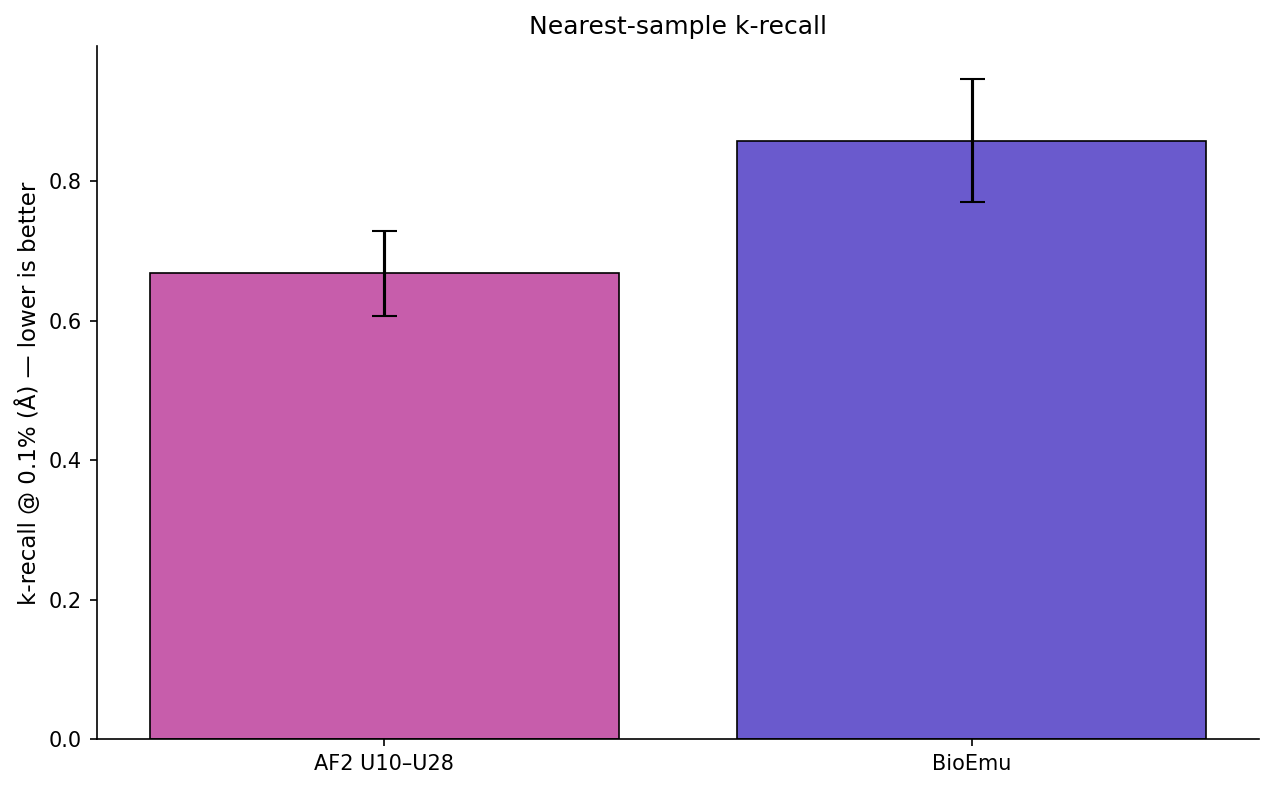


[S.4 coverage outputs — AF2 shallow only]
 Publishable summary:             exports_panel3_5/coverage_summary_publishable.csv
 Appendix curves (pointwise CI):  exports_panel3_5/coverage_curves_pointwise_with_95CI.csv
 Appendix summary (stats):        exports_panel3_5/coverage_summary_appendix.csv
 Coverage@thresholds (pub):       exports_panel3_5/coverage_at_thresholds_publishable.csv
 Coverage@thresholds (app):       exports_panel3_5/coverage_at_thresholds_appendix.csv
 Figure (curves):                 exports_panel3_5/coverage_curves_unsmoothed_shaded.png
 Figure (k-recall):               exports_panel3_5/k_recall_bar.png
 Notes: AF2 filtered to U10–U28 using U_num/U_level (units=Å (auto), ×1 → Å).


In [8]:
# ==============================================================
# S.4 — Coverage curves (unsmoothed) + Coverage@3Å + k-recall
#  - Uses ONLY AF2 shallow (U10–U28) + BioEmu (+ AFCluster if present)
#  - Light physical filtering + nm→Å normalization
#  - 95% bootstrap CIs for curves, Coverage@3Å, and k-recall@0.1%
#  - Publishable + appendix CSVs
#  - Plots: coverage curves (shaded CI), k-recall bar chart
# ==============================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------
# I/O and config
# -------------------------
OUT35 = Path(globals().get("OUT35", "exports_panel3_5")); OUT35.mkdir(parents=True, exist_ok=True)
NEAREST_RMSD_CSV = OUT35 / "nearest_rmsd_refs.csv"   # produced in §3.5

# Params
DOMAIN_MOTION_THRESHOLD_A = 3.0                       # Coverage@3 Å (kept for comparability)
TAU_MIN_A, TAU_MAX_A, TAU_STEP_A = 0.5, 6.0, 0.1      # τ-grid for coverage curves (no smoothing)
N_BOOT = 1000
RNG_SEED = 17
MAX_PHYS_A = 50.0                                     # ultra-light physical sanity cap
FORCE_UNITS = globals().get("FORCE_RMSD_UNITS", None) # "Å", "nm", or None (auto)

HOUSE_COL = {
    "AF2 U10–U28": "#C75DAB",   # shallow AF2 only
    "BioEmu":      "#6A5ACD",
    "AFCluster":   "#2ca02c",   # drawn only if present (alias for BioEmu clustered)
}

# Optional: alias method names for display/aggregation
ALIASES = {
    "ClusteredBioEmu": "AFCluster"   # show clustered BioEmu as AFCluster in plots/tables
}

# -------------------------
# Helpers
# -------------------------
rng = np.random.default_rng(RNG_SEED)
taus = np.arange(TAU_MIN_A, TAU_MAX_A + 1e-12, TAU_STEP_A)

def _detect_scale_to_angstrom(arr_like, force=FORCE_UNITS):
    """Heuristic nm→Å: if p95 < 1.8, treat as nm and ×10; else Å. Honors FORCE_UNITS."""
    a = np.asarray(arr_like, float)
    if force == "nm":
        return a * 10.0, "nm (forced)", 10.0
    if force == "Å":
        return a, "Å (forced)", 1.0
    p95 = np.nanpercentile(a, 95)
    if p95 < 1.8:
        return a * 10.0, "nm (auto)", 10.0
    return a, "Å (auto)", 1.0

def _coverage(vals_A, tau_A):
    v = np.asarray(vals_A, float)
    if v.size == 0: return np.nan
    return float((v <= tau_A).mean() * 100.0)

def bootstrap_curve(r_A, taus, nboot=N_BOOT, rng=None):
    """Per-τ bootstrap median and 95% CI of coverage; NO smoothing."""
    if rng is None: rng = np.random.default_rng()
    r = np.asarray(r_A, float); n = r.size
    if n == 0:
        return pd.DataFrame({"tau_A":taus, "coverage_median":np.nan,
                             "coverage_lo":np.nan, "coverage_hi":np.nan})
    boots = np.empty((nboot, len(taus)), float)
    for b in range(nboot):
        idx = rng.integers(0, n, size=n)
        s = r[idx]
        boots[b,:] = [ _coverage(s, t) for t in taus ]
    return pd.DataFrame({
        "tau_A": taus,
        "coverage_median": np.median(boots, axis=0),
        "coverage_lo":     np.percentile(boots, 2.5, axis=0),
        "coverage_hi":     np.percentile(boots, 97.5, axis=0),
    })

def summary_at_3A_and_krec(r_A, k_frac=0.001, nboot=N_BOOT, rng=None):
    """Coverage@3Å + k-recall@k_frac with 95% CIs (median-of-boot)."""
    if rng is None: rng = np.random.default_rng()
    r = np.asarray(r_A, float); n = r.size
    if n == 0:
        return dict(n_models=0, median_rmsd=np.nan,
                    coverage_at_3A=np.nan, coverage_lo=np.nan, coverage_hi=np.nan,
                    k_recall=np.nan, krec_lo=np.nan, krec_hi=np.nan)
    k = max(1, int(np.ceil(k_frac * n)))
    cov_b = np.empty(nboot, float)
    krc_b = np.empty(nboot, float)
    for b in range(nboot):
        idx = rng.integers(0, n, size=n)
        s = r[idx]
        cov_b[b] = _coverage(s, DOMAIN_MOTION_THRESHOLD_A)
        krc_b[b] = np.sort(s)[:k].mean()
    return dict(
        n_models        = n,
        median_rmsd     = float(np.median(r)),
        coverage_at_3A  = float(np.median(cov_b)),
        coverage_lo     = float(np.percentile(cov_b, 2.5)),
        coverage_hi     = float(np.percentile(cov_b, 97.5)),
        k_recall        = float(np.median(krc_b)),
        krec_lo         = float(np.percentile(krc_b, 2.5)),
        krec_hi         = float(np.percentile(krc_b, 97.5)),
    )

def _find_col_case_insensitive(df, key="1l97a"):
    key = str(key).lower()
    for c in df.columns:
        if str(c).lower() == key:
            return c
    for c in df.columns:
        if key in str(c).lower():
            return c
    raise KeyError(f"Could not locate a column for reference '{key}' in: {list(df.columns)[:10]} ...")

def _apply_light_filters(r_A, max_phys=MAX_PHYS_A):
    """Drop NaN/inf/negatives and clip gigantic values (> max_phys Å)."""
    r = np.asarray(r_A, float)
    m = np.isfinite(r) & (r >= 0.0)
    r = r[m]
    if r.size and np.nanmax(r) > max_phys:
        r = r[r <= max_phys]
    return r

def _u_to_num(u):
    import re
    m = re.search(r"U(\d+)", str(u))
    return int(m.group(1)) if m else np.nan

# -------------------------
# Ingest or load `rmsd_tbl` with per-reference cols; build 1L97A column in Å
# -------------------------
if "rmsd_tbl" in globals() and isinstance(rmsd_tbl, pd.DataFrame) and not rmsd_tbl.empty:
    df_in = rmsd_tbl.copy()
else:
    assert NEAREST_RMSD_CSV.exists(), f"Missing RMSD table: {NEAREST_RMSD_CSV}"
    df_in = pd.read_csv(NEAREST_RMSD_CSV)

# Ensure method/model_id present
required_cols = {"method","model_id"}
missing = required_cols - set(df_in.columns)
if missing:
    raise RuntimeError(f"RMSD table is missing required columns: {missing}")

# If AF2 rows lack U_level/U_num, merge from df_af2 by model_id (to filter U10–U28)
if "U_level" not in df_in.columns and "df_af2" in globals():
    try:
        df_in = df_in.merge(df_af2[["model_id","U_level"]], on="model_id", how="left")
    except Exception:
        pass
if "U_num" not in df_in.columns and "U_level" in df_in.columns:
    df_in["U_num"] = df_in["U_level"].map(_u_to_num)

# Build 1L97A column, normalize units to Å
col_1l97a = _find_col_case_insensitive(df_in, "1L97A")
r_raw = df_in[col_1l97a].to_numpy(float)
r_A, unit_tag, factor = _detect_scale_to_angstrom(r_raw, FORCE_UNITS)
df_in["rmsd_to_1l97a_A"] = r_A

# -------------------------
# Filter to AF2 shallow only (U10–U28). Keep BioEmu / ClusteredBioEmu.
# -------------------------
df = df_in.loc[:, ["model_id","method","rmsd_to_1l97a_A","U_level","U_num"] if "U_level" in df_in.columns else ["model_id","method","rmsd_to_1l97a_A"]].copy()

def _is_af2_shallow(row):
    if row["method"] != "AF2":
        return False
    if "U_num" in row and np.isfinite(row["U_num"]):
        return (10 <= row["U_num"] <= 28)
    if "U_level" in row and isinstance(row["U_level"], str):
        try:
            u = int(row["U_level"].lstrip("U"))
            return 10 <= u <= 28
        except Exception:
            return False
    # If no U info, conservatively drop from shallow filter
    return False

m_af2 = df["method"].eq("AF2")
keep_af2_shallow = df.apply(_is_af2_shallow, axis=1) if m_af2.any() else pd.Series([], dtype=bool)
keep_non_af2 = ~m_af2

df = df.loc[ keep_non_af2 | keep_af2_shallow ].copy()

# Map aliases and relabel AF2 shallow
df["method_disp"] = df["method"].map(ALIASES).fillna(df["method"])
df.loc[df["method"].eq("AF2"), "method_disp"] = "AF2 U10–U28"

present_methods = [m for m in ["AF2 U10–U28","BioEmu","AFCluster"] if m in df["method_disp"].unique().tolist()]
if not present_methods:
    raise RuntimeError("No recognized methods present after AF2 shallow filtering (expect AF2 U10–U28 and/or BioEmu/AFCluster).")

print(f"[S.4] Methods: {present_methods}  |  Units: {unit_tag}, ×{factor:g} → Å")

# Light filtering (per method)
good = np.isfinite(df["rmsd_to_1l97a_A"]) & (df["rmsd_to_1l97a_A"] >= 0.0) & (df["rmsd_to_1l97a_A"] <= MAX_PHYS_A)
n_dropped = int((~good).sum())
if n_dropped:
    print(f"[S.4] Dropping {n_dropped} rows failing light physical filters (non-finite / <0 / >{MAX_PHYS_A} Å).")
df = df.loc[good].copy()

# -------------------------
# Compute coverage curves + publishable summary
# -------------------------
curves = []
summ   = []
for m in present_methods:
    r = df.loc[df["method_disp"].eq(m), "rmsd_to_1l97a_A"].to_numpy(float)
    r = _apply_light_filters(r, MAX_PHYS_A)
    ci_curve = bootstrap_curve(r, taus, nboot=N_BOOT, rng=rng)
    ci_curve["method"] = m
    curves.append(ci_curve)
    s = summary_at_3A_and_krec(r, k_frac=0.001, nboot=N_BOOT, rng=rng); s["method"] = m
    summ.append(s)

df_cov_ci = pd.concat(curves, ignore_index=True) if curves else pd.DataFrame()

# Publishable: compact, with ± formatting
def _pm(lo, hi, center=None, ndp=2):
    if center is None: center = (lo+hi)/2
    err = max(0.0, (hi - lo) / 2.0)
    return f"{center:.{ndp}f} ± {err:.{ndp}f}"

pub_rows = []
for s in summ:
    pub_rows.append({
        "method": s["method"],
        "n_models": s["n_models"],
        "median_rmsd (Å)": f"{s['median_rmsd']:.2f}",
        "k-recall@0.1% (Å)": _pm(s["krec_lo"], s["krec_hi"], s["k_recall"], ndp=3),
    })
df_publishable = pd.DataFrame(pub_rows)

# Appendix: full numeric medians + CIs
df_appendix = pd.DataFrame(summ, columns=[
    "method","n_models","median_rmsd","coverage_at_3A","coverage_lo","coverage_hi",
    "k_recall","krec_lo","krec_hi"
])

# -------------------------
# Save CSVs
# -------------------------
pub_csv = OUT35/"coverage_summary_publishable.csv"
app_csv = OUT35/"coverage_curves_pointwise_with_95CI.csv"
app_sum_csv = OUT35/"coverage_summary_appendix.csv"

df_publishable.to_csv(pub_csv, index=False)
df_cov_ci.to_csv(app_csv, index=False)
df_appendix.to_csv(app_sum_csv, index=False)


THRESHOLDS_REPORT_A = [1,2]
# -------------------------
# Plots
# -------------------------
plt.rcParams.update({
    "figure.dpi":150, "savefig.dpi":300,
    "axes.spines.top":False, "axes.spines.right":False
})

# 1) Coverage curves (unsmoothed, shaded 95% CI)
fig, ax = plt.subplots(figsize=(10, 6))
for m in present_methods:
    g = df_cov_ci[df_cov_ci["method"]==m]
    if g.empty: continue
    col = HOUSE_COL.get(m, "0.6")
    ax.fill_between(g["tau_A"], g["coverage_lo"], g["coverage_hi"], color=col, alpha=0.18, linewidth=0)
    ax.plot(g["tau_A"], g["coverage_median"], color=col, lw=2.2, label=m)

# --- L-shaped guides at τ = 1.0 Å and 2.0 Å (uses AF2 curve) ---
# 1) lock axes so guides go exactly to the spines
ax.set_xlim(TAU_MIN_A, TAU_MAX_A)
ax.set_ylim(0.0, 100.0)  # coverage is a percentage

left, right = ax.get_xlim()
bottom, top = ax.get_ylim()

# 2) choose which method to anchor the guides to (AF2 preferred)
ref_method = "AF2" if "AF2" in present_methods else present_methods[0]
g_ref = df_cov_ci[df_cov_ci["method"] == ref_method].sort_values("tau_A")

if not g_ref.empty:
    x_ref = g_ref["tau_A"].to_numpy(float)
    y_med = g_ref["coverage_median"].to_numpy(float)

    guide_ls  = (0, (4, 3))
    guide_col = "0.25"

    for t in THRESHOLDS_REPORT_A:  # e.g. [1.0, 2.0]
        y_t = float(np.interp(t, x_ref, y_med))
        y_t = float(np.clip(y_t, bottom, top))  # stay within current axes

        # vertical: from x=t down to the bottom spine (y=bottom)
        ax.plot([t, t], [bottom, y_t], color=guide_col, linestyle=guide_ls, linewidth=1.2, zorder=0)

        # horizontal: from the left spine (x=left) to x=t at y=y_t
        ax.plot([left, t], [y_t, y_t], color=guide_col, linestyle=guide_ls, linewidth=1.2, zorder=0)

ax.set_xlabel("RMSD to 1L97A (Å)")
ax.set_ylabel("Coverage (%)")
ax.set_title("Coverage curves (unsmoothed) with 95% bootstrap CIs — AF2 U10–U28 only")
ax.legend(frameon=True, facecolor="white", edgecolor="0.3")
fig_cov = OUT35/"coverage_curves_unsmoothed_shaded.png"
fig.savefig(fig_cov, bbox_inches="tight")
plt.show()

# 2) k-recall bar chart (median with 95% CI error bars)
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(present_methods))
heights = [ next(s["k_recall"] for s in summ if s["method"]==m) for m in present_methods ]
errs = [ (next(s["krec_hi"] for s in summ if s["method"]==m) -
          next(s["krec_lo"] for s in summ if s["method"]==m)) / 2.0 for m in present_methods ]
cols = [ HOUSE_COL.get(m, "0.6") for m in present_methods ]

ax.bar(x, heights, yerr=errs, capsize=6, color=cols, edgecolor="black", linewidth=0.8)
ax.set_xticks(x, present_methods)
ax.set_ylabel("k-recall @ 0.1% (Å) — lower is better")
ax.set_title("Nearest-sample k-recall")
fig_krec = OUT35/"k_recall_bar.png"
fig.savefig(fig_krec, bbox_inches="tight")
plt.show()

# -------------------------
# Coverage at report thresholds (1.0 Å, 2.0 Å) — separate table
# -------------------------
THRESHOLDS_REPORT_A = [1.0, 2.0]

def _cov_at_thresholds(method, taus):
    """Interpolate median/CI coverage at specific τ (Å) from df_cov_ci."""
    g = df_cov_ci[df_cov_ci["method"] == method].sort_values("tau_A")
    if g.empty:
        return None
    x = g["tau_A"].to_numpy(float)
    med = g["coverage_median"].to_numpy(float)
    lo  = g["coverage_lo"].to_numpy(float)
    hi  = g["coverage_hi"].to_numpy(float)
    row_pub, row_app = {"method": method}, {"method": method}
    for t in taus:
        m = float(np.interp(t, x, med))
        l = float(np.interp(t, x, lo))
        h = float(np.interp(t, x, hi))
        row_pub[f"coverage@{t:.1f}Å (%)"] = f"{m:.1f} ± {((h-l)/2):.1f}"
        row_app[f"coverage@{t:.1f}Å_median"] = m
        row_app[f"coverage@{t:.1f}Å_lo"]     = l
        row_app[f"coverage@{t:.1f}Å_hi"]     = h
    return row_pub, row_app

pub_rows, app_rows = [], []
for m in present_methods:
    out = _cov_at_thresholds(m, THRESHOLDS_REPORT_A)
    if out is None: 
        continue
    rp, ra = out
    pub_rows.append(rp); app_rows.append(ra)

cov_thresh_pub = pd.DataFrame(pub_rows)
cov_thresh_app = pd.DataFrame(app_rows)
cov_pub_csv = OUT35 / "coverage_at_thresholds_publishable.csv"
cov_app_csv = OUT35 / "coverage_at_thresholds_appendix.csv"
cov_thresh_pub.to_csv(cov_pub_csv, index=False)
cov_thresh_app.to_csv(cov_app_csv, index=False)

# -------------------------
# Final “everything saved” summary
# -------------------------
print("\n[S.4 coverage outputs — AF2 shallow only]")
print(" Publishable summary:            ", pub_csv)
print(" Appendix curves (pointwise CI): ", app_csv)
print(" Appendix summary (stats):       ", app_sum_csv)
print(" Coverage@thresholds (pub):      ", cov_pub_csv)
print(" Coverage@thresholds (app):      ", cov_app_csv)
print(" Figure (curves):                ", fig_cov)
print(" Figure (k-recall):              ", fig_krec)
print(f" Notes: AF2 filtered to U10–U28 using U_num/U_level (units={unit_tag}, ×{factor:g} → Å).")


### <span style="color: #FF0099;"> 3.6 Seed and RMSD for all

In [9]:
# ==============================================================
# §3.6 — Seeds & Outliers (axis corridor + relaxed PCA hull)
# ==============================================================

# --- Helpers: reshape + RMSD-to-all-refs -------------------------------------
def reshape_coords(X: np.ndarray) -> np.ndarray:
    n_atoms = X.shape[1] // 3
    return X.reshape(X.shape[0], n_atoms, 3)

R_ref = reshape_coords(X_ref)
R_af2 = reshape_coords(X_af2)
R_bio = reshape_coords(X_bio) if X_bio is not None else None

def rmsd_to_refs(samples_xyz: np.ndarray, refs_xyz: np.ndarray) -> np.ndarray:
    diffs2 = (samples_xyz[:, None, :, :] - refs_xyz[None, :, :, :])**2
    msd = diffs2.sum(axis=3).mean(axis=2)
    return np.sqrt(msd, dtype=np.float64)

def nearest_ref_rmsd(samples_xyz: np.ndarray, refs_xyz: np.ndarray) -> np.ndarray:
    return rmsd_to_refs(samples_xyz, refs_xyz).min(axis=1)

# --- EV tables (shared PCA space) --------------------------------------------
EV_ref = df_ref[["EV1","EV2"]].copy()
EV_ref["PDB"] = df_ref["PDB"].values

# Enforce *deterministic PC1 orientation*: EV1(open) > EV1(2LZM).
# Do this ONCE right after fitting in your init; if not, do it here safely:
def _orient_ev1(ev_ref_df, scores_af2_arr, scores_bio_arr=None):
    names_low = ev_ref_df["PDB"].str.lower().tolist()
    def _ix(code):
        code = code.lower()
        for i,s in enumerate(names_low):
            if code in s: return i
        raise ValueError(f"Reference '{code}' not found in labels.")
    ix_closed = _ix("2lzm")
    # Pick open anchor via k-means over references (same as below), just to get orientation target.
    kmeans_tmp = KMeans(n_clusters=2, random_state=0).fit(ev_ref_df[["EV1","EV2"]])
    ev_ref_df = ev_ref_df.copy()
    ev_ref_df["cluster"] = kmeans_tmp.labels_
    cluster_open = ev_ref_df.groupby("cluster")["EV1"].mean().idxmax()
    open_centroid = ev_ref_df.loc[ev_ref_df["cluster"]==cluster_open, ["EV1","EV2"]].mean().to_numpy()
    sub = ev_ref_df[ev_ref_df["cluster"]==cluster_open]
    d = np.linalg.norm(sub[["EV1","EV2"]].to_numpy() - open_centroid, axis=1)
    ix_open = sub.iloc[d.argmin()].name

    if ev_ref_df.loc[ix_open,"EV1"] <= ev_ref_df.loc[ix_closed,"EV1"]:
        # flip EV1 for all objects we keep in memory
        ev_ref_df["EV1"] *= -1.0
        scores_af2_arr = scores_af2_arr.copy()
        scores_af2_arr[:,0] *= -1.0
        if scores_bio_arr is not None:
            scores_bio_arr = scores_bio_arr.copy()
            scores_bio_arr[:,0] *= -1.0
        return ev_ref_df, scores_af2_arr, scores_bio_arr
    return ev_ref_df, scores_af2_arr, scores_bio_arr

EV_ref, scores_af2, scores_bio = _orient_ev1(EV_ref, scores_af2, scores_bio if X_bio is not None else None)

EV_af2 = scores_af2[:, :2]
EV_bio = (scores_bio[:, :2] if (scores_bio is not None) else None)

# Find 2LZM and a data-driven open anchor (kmeans on references)
def _match_ref(df, code):
    code = str(code).lower()
    m = df["PDB"].str.lower().eq(code)
    if not m.any(): m = df["PDB"].str.lower().str.contains(code)
    return df.loc[m, ["EV1","EV2","PDB"]].iloc[0]

pt_2lzm = _match_ref(EV_ref.assign(PDB=EV_ref["PDB"]), "2lzm")

kmeans = KMeans(n_clusters=2, random_state=0).fit(EV_ref[["EV1","EV2"]])
EV_ref = EV_ref.copy()
EV_ref["cluster"] = kmeans.labels_
cluster_open = EV_ref.groupby("cluster")["EV1"].mean().idxmax()
open_centroid = EV_ref.loc[EV_ref["cluster"]==cluster_open, ["EV1","EV2"]].mean().to_numpy()
sub = EV_ref[EV_ref["cluster"]==cluster_open].copy()
d = np.linalg.norm(sub[["EV1","EV2"]].to_numpy() - open_centroid, axis=1)
pt_open = sub.iloc[d.argmin()]
print(f"Chosen open reference: {pt_open['PDB']} at (EV1,EV2)=({pt_open['EV1']:.6f},{pt_open['EV2']:.6f})")

# --- EV2 envelope along AF2 EV1 via spline -----------------------------------
df_af2_env = pd.DataFrame({"EV1": EV_af2[:,0], "EV2": EV_af2[:,1]}).sort_values("EV1")
x = df_af2_env["EV1"].to_numpy(); y = df_af2_env["EV2"].to_numpy()
arc_spline = UnivariateSpline(x, y, s=len(x)*0.1)
y_arc = arc_spline(x)
resid = y - y_arc
half_width = (np.percentile(resid,95) - np.percentile(resid,5))/2

def ev2_center(ev1): return arc_spline(np.asarray(ev1, dtype=float))
def ev2_lo_fun(ev1):  return ev2_center(ev1) - half_width
def ev2_hi_fun(ev1):  return ev2_center(ev1) + half_width

# --- EV1 tail cutoff & inter-reference RMSD 95th ------------------------------
AF2_TAIL_P = 0.98
af2_ev1_tail_cut = float(np.quantile(EV_af2[:, 0], AF2_TAIL_P))
ref_vs_ref = rmsd_to_refs(R_ref, R_ref)
tri = np.triu(np.ones_like(ref_vs_ref, dtype=bool), k=1)
inter_ref_vals = ref_vs_ref[tri]
ref_rmsd_cut = float(np.percentile(inter_ref_vals, 95))
print(f"EV1 tail cut @ {AF2_TAIL_P*100:.0f}th: {af2_ev1_tail_cut:.3f}   |   Inter-ref RMSD 95th: {ref_rmsd_cut:.3f} Å")

# --- Score all AF2/BioEmu; apply gates ---------------------------------------
rmsd_af2_all = rmsd_to_refs(R_af2, R_ref)
rmsd_bio_all = rmsd_to_refs(R_bio, R_ref) if R_bio is not None else None

ref_names  = df_ref["PDB"].astype(str).tolist()
names_low  = [s.lower() for s in ref_names]
def _find_idx(code: str) -> int:
    code = code.lower()
    for i, s in enumerate(names_low):
        if code in s: return i
    raise ValueError(f"Reference '{code}' not found.")
idx_2lzm = _find_idx("2lzma")
idx_open = _find_idx(str(pt_open["PDB"]))

# AF2 rows
af2_meta = df_af2[["model_id"]].copy()
af2_meta["method"] = "AF2"
if "U_level" in df_af2.columns:
    af2_meta["U_level"] = df_af2["U_level"].values
df_af2_rows = af2_meta.copy()
df_af2_rows["rmsd_to_2LZM"] = rmsd_af2_all[:, idx_2lzm]
df_af2_rows["rmsd_to_open"] = rmsd_af2_all[:, idx_open]
df_af2_rows["ev1"] = EV_af2[:,0]; df_af2_rows["ev2"] = EV_af2[:,1]

# BioEmu rows (if present)
if R_bio is not None:
    df_bio_rows = pd.DataFrame({
        "model_id": [f"BioEmu_{i:04d}" for i in range(R_bio.shape[0])],
        "method": "BioEmu",
        "rmsd_to_2LZM": rmsd_bio_all[:, idx_2lzm],
        "rmsd_to_open": rmsd_bio_all[:, idx_open],
        "ev1": EV_bio[:,0], "ev2": EV_bio[:,1]
    })
else:
    df_bio_rows = pd.DataFrame(columns=["model_id","method","rmsd_to_2LZM","rmsd_to_open","ev1","ev2"])

all_models = pd.concat([df_af2_rows, df_bio_rows], ignore_index=True)

# Gates
min_af2 = rmsd_af2_all.min(axis=1)
min_bio = rmsd_bio_all.min(axis=1) if rmsd_bio_all is not None else np.array([])
all_models["nearest_reference_RMSD"] = np.r_[min_af2, min_bio]
all_models["ok_manifold"] = all_models["nearest_reference_RMSD"] <= ref_rmsd_cut

ev2_lo_at_x = ev2_lo_fun(all_models["ev1"].to_numpy(float))
ev2_hi_at_x = ev2_hi_fun(all_models["ev1"].to_numpy(float))
all_models["ok_ev2"]  = (all_models["ev2"].to_numpy() >= ev2_lo_at_x) & (all_models["ev2"].to_numpy() <= ev2_hi_at_x)
all_models["ok_tail"] = all_models["ev1"] >= af2_ev1_tail_cut

sel_mask = all_models["ok_ev2"] & all_models["ok_manifold"] & all_models["ok_tail"]
selected = (all_models[sel_mask].copy()
            .sort_values(["ev1","rmsd_to_open"], ascending=[False, True])
            .reset_index(drop=True))

all_models.to_csv(OUT35/"allsamples_scored.csv", index=False)
selected.to_csv(OUT35/"seed_candidates_no_diversity.csv", index=False)
print("Selected total:", len(selected), " | AF2:", int((selected['method']=='AF2').sum()),
      " | BioEmu:", int((selected['method']=='BioEmu').sum()))


# --- Outliers: RMSD-axis & relaxed reference hull in PCA ---------------------
# anchor EVs
ev_closed = df_ref.loc[ix_2lzm,  ["EV1","EV2"]].to_numpy(float)
ev_open   = pt_open[["EV1","EV2"]].to_numpy(float)

# wide tables (RMSD to all references)
ref_cols = ref_names
af2_wide = pd.DataFrame(rmsd_af2_all, columns=ref_cols)
af2_wide.insert(0,"method","AF2")
af2_wide.insert(0,"model_id",df_af2["model_id"].values)
if "U_level" in df_af2.columns: af2_wide["U_level"] = df_af2["U_level"].values

if rmsd_bio_all is not None:
    bio_wide = pd.DataFrame(rmsd_bio_all, columns=ref_cols)
    bio_wide.insert(0,"method","BioEmu")
    bio_wide.insert(0,"model_id",[f"BioEmu_{i:04d}" for i in range(rmsd_bio_all.shape[0])])
else:
    bio_wide = pd.DataFrame(columns=["model_id","method"]+ref_cols)

all_wide = pd.concat([af2_wide,bio_wide],ignore_index=True)

# attach EVs
ev_af2_df = pd.DataFrame(EV_af2,columns=["ev1","ev2"]); ev_af2_df.insert(0,"model_id",af2_wide["model_id"])
if EV_bio is not None:
    ev_bio_df = pd.DataFrame(EV_bio,columns=["ev1","ev2"]); ev_bio_df.insert(0,"model_id",bio_wide["model_id"])
else:
    ev_bio_df = pd.DataFrame(columns=["model_id","ev1","ev2"])
all_wide = all_wide.merge(pd.concat([ev_af2_df,ev_bio_df], ignore_index=True), on="model_id", how="left")

# RMSD axis corridor
coords_rmsd = np.stack([all_wide[ref_cols].to_numpy(float)[:,idx_2lzm],
                        all_wide[ref_cols].to_numpy(float)[:,idx_open]], axis=1)
p_closed = np.array([0.0, np.median(all_wide[ref_cols].to_numpy(float)[:,idx_open])])
p_open   = np.array([np.median(all_wide[ref_cols].to_numpy(float)[:,idx_2lzm]), 0.0])
axis_vec = p_open - p_closed
axis_len = float(np.linalg.norm(axis_vec)); axis_vec /= max(axis_len, 1e-12)
proj_rmsd = (coords_rmsd - p_closed) @ axis_vec
perp_rmsd = np.abs(np.cross(axis_vec, coords_rmsd - p_closed))
RMSD_PERP_Q, RMSD_PERP_MIN = 99.0, 3.0
RMSD_PERP_CUT = max(float(np.percentile(perp_rmsd, RMSD_PERP_Q)), RMSD_PERP_MIN)
LMF = 0.05
LONG_MIN, LONG_MAX = -LMF*axis_len, (1.0+LMF)*axis_len

all_wide["rmsd_axis_progress"]  = proj_rmsd
all_wide["rmsd_axis_deviation"] = perp_rmsd
all_wide["is_outlier_rmsd_axis"] = ((perp_rmsd > RMSD_PERP_CUT) | (proj_rmsd < LONG_MIN) | (proj_rmsd > LONG_MAX))

# PCA axis & relaxed convex hull
axis_vec_pca = ev_open - ev_closed
axis_len_pca = float(np.linalg.norm(axis_vec_pca)); axis_vec_pca /= max(axis_len_pca, 1e-12)
coords_pca = all_wide[["ev1","ev2"]].to_numpy(float)
proj_pca = (coords_pca - ev_closed) @ axis_vec_pca
perp_pca = np.abs(np.cross(axis_vec_pca, coords_pca - ev_closed))
PCA_PERP_Q = 95.0; PCA_PERP_CUT = float(np.percentile(perp_pca, PCA_PERP_Q))
PCA_LONG_MIN, PCA_LONG_MAX = -0.05*axis_len_pca, 1.05*axis_len_pca
all_wide["pca_axis_progress"]  = proj_pca
all_wide["pca_axis_deviation"] = perp_pca
all_wide["is_outlier_pca_axis"] = ((perp_pca > PCA_PERP_CUT) | (proj_pca < PCA_LONG_MIN) | (proj_pca > PCA_LONG_MAX))

R = EV_ref[["EV1","EV2"]].to_numpy(float)
if R.shape[0] >= 3 and np.linalg.matrix_rank(R - R.mean(0)) >= 2:
    hull = ConvexHull(R); poly = R[hull.vertices]
    centroid = poly.mean(axis=0); HULL_SCALE = 1.10
    poly_scaled = centroid + HULL_SCALE * (poly - centroid)

    edges = np.linalg.norm(np.roll(poly_scaled, -1, axis=0) - poly_scaled, axis=1)
    HULL_MARGIN_EV = max(0.05 * np.median(edges), 0.02)

    path_scaled = MplPath(poly_scaled)
    inside_scaled = path_scaled.contains_points(coords_pca)

    def _ptseg_dist(p, a, b):
        ap = p - a; ab = b - a
        t = np.clip((ap @ ab) / (ab @ ab + 1e-12), 0.0, 1.0)
        proj = a + t[:, None] * ab
        return np.sqrt(np.sum((p - proj)**2, axis=1))

    def _dist_to_edges(points, poly_vertices):
        K = poly_vertices.shape[0]; dmin = np.full(points.shape[0], np.inf)
        for i in range(K):
            a = poly_vertices[i]; b = poly_vertices[(i+1) % K]
            d = _ptseg_dist(points, a, b); dmin = np.minimum(dmin, d)
        return dmin

    outside_idx = np.where(~inside_scaled)[0]
    dist_to_edges = np.zeros(coords_pca.shape[0], dtype=float)
    dist_to_edges[outside_idx] = _dist_to_edges(coords_pca[outside_idx], poly_scaled)
    inside_with_margin = inside_scaled | (dist_to_edges <= HULL_MARGIN_EV)
    all_wide["is_outlier_pca_hull"] = ~inside_with_margin
else:
    all_wide["is_outlier_pca_hull"] = False

# compatibility columns + exports
all_wide["is_outlier_rmsd_clustered"] = all_wide["is_outlier_rmsd_axis"]
all_wide["is_outlier_pca_clustered"]  = all_wide["is_outlier_pca_axis"]
for col in ["pca_cluster","rmsd_cluster"]: all_wide[col] = "axis"
for col in ["rmsd_medoid_ref_id","rmsd_medoid_dist","rmsd_cluster_radius","pca_dist_to_centroid","pca_cluster_radius"]:
    if col not in all_wide.columns: all_wide[col] = np.nan

# census
def _count(flag: str):
    tot = int(all_wide[flag].fillna(False).astype(bool).sum())
    a = int(all_wide.query("method=='AF2'")[flag].fillna(False).astype(bool).sum()) if "AF2" in all_wide["method"].unique() else 0
    b = int(all_wide.query("method=='BioEmu'")[flag].fillna(False).astype(bool).sum()) if "BioEmu" in all_wide["method"].unique() else 0
    print(f"{flag}: total={tot}   AF2={a}   BioEmu={b}")

print("Outlier census (axis corridor + relaxed hull):")
for c in ["is_outlier_rmsd_clustered","is_outlier_pca_clustered","is_outlier_pca_hull"]:
    _count(c)

# merged outliers + full tables
outlier_flags = ["is_outlier_rmsd_clustered","is_outlier_pca_clustered","is_outlier_pca_hull"]
all_wide["is_outlier_any"] = all_wide[outlier_flags].fillna(False).any(axis=1)

outliers_merged = all_wide.loc[all_wide["is_outlier_any"],
    ["model_id","method","ev1","ev2"] + outlier_flags + ["is_outlier_any"]
]
outliers_merged.to_csv(OUT35/"allsamples_outliers_merged.csv", index=False)

cols_keep = ["model_id","method","ev1","ev2","pca_cluster","rmsd_cluster"] + ref_cols + [
    "rmsd_axis_progress","rmsd_axis_deviation","is_outlier_rmsd_axis","is_outlier_rmsd_clustered",
    "pca_axis_progress","pca_axis_deviation","is_outlier_pca_axis","is_outlier_pca_clustered",
    "is_outlier_pca_hull","is_outlier_any"
]
big = all_wide[[c for c in cols_keep if c in all_wide.columns]].copy()
big.to_csv(OUT35/"allsamples_vs_allrefs_rmsd.csv", index=False)
selected.to_csv(OUT35/"seeds_selected.csv", index=False)
print(f"[✓] Wrote {OUT35/'allsamples_vs_allrefs_rmsd.csv'}  shape={big.shape}")
print(f"[✓] Wrote {OUT35/'allsamples_outliers_merged.csv'}  n={len(outliers_merged)}")
print(f"[✓] Wrote {OUT35/'seeds_selected.csv'}  n={len(selected)}")



# --- Ranked seed panel + per-method summary ----------------------------------
def _p95(series: pd.Series) -> float:
    x = series.dropna()
    return float(np.percentile(x, 95)) if len(x) else np.nan

panel = selected.copy()
panel["rmsd_to_open_filled"] = panel["rmsd_to_open"].fillna(np.inf)
panel = (panel.sort_values(["ev1", "rmsd_to_open_filled"], ascending=[False, True])
         .drop(columns=["rmsd_to_open_filled"]).reset_index(drop=True))
# bring axis metrics
have = [c for c in ["rmsd_axis_progress","rmsd_axis_deviation","is_outlier_rmsd_axis","is_outlier_rmsd_clustered",
                    "pca_axis_progress","pca_axis_deviation","is_outlier_pca_axis","is_outlier_pca_clustered",
                    "is_outlier_pca_hull"] if c in all_wide.columns]
panel = panel.merge(all_wide[["model_id"] + have], on="model_id", how="left")
panel["is_outlier_any"] = panel[[c for c in ["is_outlier_rmsd_clustered","is_outlier_pca_clustered","is_outlier_pca_hull"] if c in panel.columns]].fillna(False).any(axis=1)
panel.insert(0, "rank_overall", np.arange(1, len(panel) + 1))
panel["rank_within_method"] = panel.groupby("method")["rank_overall"].rank(method="first").astype(int)
if "U_level" in df_af2.columns:
    panel = panel.merge(df_af2[["model_id","U_level"]], on="model_id", how="left")

cols = ["rank_overall","rank_within_method","model_id","method","U_level","ev1","ev2",
        "rmsd_to_2LZM","rmsd_to_open","rmsd_axis_progress","rmsd_axis_deviation","is_outlier_rmsd_axis","is_outlier_rmsd_clustered",
        "pca_axis_progress","pca_axis_deviation","is_outlier_pca_axis","is_outlier_pca_clustered","is_outlier_pca_hull","is_outlier_any"]
panel = panel[[c for c in cols if c in panel.columns]].copy()

summary = (panel.assign(
    outlier_RMSD_clustered = panel.get("is_outlier_rmsd_clustered", False).fillna(False).astype(int),
    outlier_PCA_clustered  = panel.get("is_outlier_pca_clustered", False).fillna(False).astype(int),
    outlier_PCA_hull       = panel.get("is_outlier_pca_hull", False).fillna(False).astype(int)
).groupby("method", as_index=False).agg(
    n_seeds=("model_id","count"),
    n_outlier_rmsd_clustered=("outlier_RMSD_clustered","sum"),
    n_outlier_pca_clustered=("outlier_PCA_clustered","sum"),
    n_outlier_pca_hull=("outlier_PCA_hull","sum"),
    median_RMSD_axis_dev=("rmsd_axis_deviation","median"),
    q95_RMSD_axis_dev=("rmsd_axis_deviation", _p95),
    median_PCA_axis_dev=("pca_axis_deviation","median"),
    q95_PCA_axis_dev=("pca_axis_deviation", _p95)
))

panel.to_csv(OUT35/"seed_panel_final.csv", index=False)
summary.to_csv(OUT35/"seed_panel_summary.csv", index=False)
print(f"[✓] Wrote {OUT35/'seed_panel_final.csv'}  n={len(panel)}")
print(f"[✓] Wrote {OUT35/'seed_panel_summary.csv'}")
display(panel.head(20))


# ==============================================================
# §3.6 — Seed conformer selection (axis corridor + relaxed PCA hull)
# ==============================================================

# (… your scoring, orientation, gating, outlier census, relaxed hull plot …)
# Up to: outliers_merged, all_wide, selected already computed

# --- Ranked seed panel + per-method summary ----------------------------------
def _p95(series: pd.Series) -> float:
    x = series.dropna()
    return float(np.percentile(x, 95)) if len(x) else np.nan

panel = selected.copy()
panel["rmsd_to_open_filled"] = panel["rmsd_to_open"].fillna(np.inf)
panel = (panel.sort_values(["ev1", "rmsd_to_open_filled"], ascending=[False, True])
         .drop(columns=["rmsd_to_open_filled"]).reset_index(drop=True))

# bring axis/outlier info
have = [c for c in ["rmsd_axis_progress","rmsd_axis_deviation","is_outlier_rmsd_axis","is_outlier_rmsd_clustered",
                    "pca_axis_progress","pca_axis_deviation","is_outlier_pca_axis","is_outlier_pca_clustered",
                    "is_outlier_pca_hull"] if c in all_wide.columns]
panel = panel.merge(all_wide[["model_id"] + have], on="model_id", how="left")

# Flag any outlier membership
panel["is_outlier_any"] = panel[[c for c in 
    ["is_outlier_rmsd_clustered","is_outlier_pca_clustered","is_outlier_pca_hull"] 
    if c in panel.columns]].fillna(False).any(axis=1)

# Add rank columns
panel.insert(0, "rank_overall", np.arange(1, len(panel) + 1))
panel["rank_within_method"] = panel.groupby("method")["rank_overall"].rank(method="first").astype(int)

# Add U_level if present (AF2 only)
if "U_level" in df_af2.columns:
    panel = panel.merge(df_af2[["model_id","U_level"]], on="model_id", how="left")

# Final columns for paper
cols = ["rank_overall","rank_within_method","model_id","method","U_level","ev1","ev2",
        "rmsd_to_2LZM","rmsd_to_open",
        "rmsd_axis_progress","rmsd_axis_deviation","is_outlier_rmsd_axis","is_outlier_rmsd_clustered",
        "pca_axis_progress","pca_axis_deviation","is_outlier_pca_axis","is_outlier_pca_clustered",
        "is_outlier_pca_hull","is_outlier_any"]
panel = panel[[c for c in cols if c in panel.columns]]

# Summary by method
summary = (panel.assign(
    outlier_RMSD_clustered = panel.get("is_outlier_rmsd_clustered", False).fillna(False).astype(int),
    outlier_PCA_clustered  = panel.get("is_outlier_pca_clustered", False).fillna(False).astype(int),
    outlier_PCA_hull       = panel.get("is_outlier_pca_hull", False).fillna(False).astype(int)
).groupby("method", as_index=False).agg(
    n_seeds=("model_id","count"),
    n_outlier_rmsd_clustered=("outlier_RMSD_clustered","sum"),
    n_outlier_pca_clustered=("outlier_PCA_clustered","sum"),
    n_outlier_pca_hull=("outlier_PCA_hull","sum"),
    median_RMSD_axis_dev=("rmsd_axis_deviation","median"),
    q95_RMSD_axis_dev=("rmsd_axis_deviation", _p95),
    median_PCA_axis_dev=("pca_axis_deviation","median"),
    q95_PCA_axis_dev=("pca_axis_deviation", _p95)
))

# --- Exports (2 core files + appendix) ---------------------------------------
panel.to_csv(OUT35/"seed_panel_final.csv", index=False)
summary.to_csv(OUT35/"seed_panel_summary.csv", index=False)
outliers_merged.to_csv(OUT35/"seed_outliers.csv", index=False)  # appendix-style

print(f"[§3.6] Wrote {OUT35/'seed_panel_final.csv'} (n={len(panel)})")
print(f"[§3.6] Wrote {OUT35/'seed_panel_summary.csv'}")
print(f"[§3.6] Wrote {OUT35/'seed_outliers.csv'} (n={len(outliers_merged)})")


Chosen open reference: 1l97a at (EV1,EV2)=(1.190415,-0.294629)
EV1 tail cut @ 98th: 0.237   |   Inter-ref RMSD 95th: 0.330 Å
Selected total: 17  | AF2: 14  | BioEmu: 3
Outlier census (axis corridor + relaxed hull):
is_outlier_rmsd_clustered: total=485   AF2=8   BioEmu=477
is_outlier_pca_clustered: total=339   AF2=2   BioEmu=337
is_outlier_pca_hull: total=565   AF2=4   BioEmu=561
[✓] Wrote exports_panel3_5/allsamples_vs_allrefs_rmsd.csv  shape=(2795, 55)
[✓] Wrote exports_panel3_5/allsamples_outliers_merged.csv  n=904
[✓] Wrote exports_panel3_5/seeds_selected.csv  n=17
[✓] Wrote exports_panel3_5/seed_panel_final.csv  n=17
[✓] Wrote exports_panel3_5/seed_panel_summary.csv


rank_overall  rank_within_method     model_id  method       ev1       ev2  \
0              1                   1     AF2_0044     AF2  2.055759 -0.112695   
1              2                   1  BioEmu_0694  BioEmu  1.620064 -0.050804   
2              3                   2     AF2_0310     AF2  0.903796  0.168173   
3              4                   2  BioEmu_1049  BioEmu  0.767988  0.100424   
4              5                   3     AF2_0311     AF2  0.642222  0.167255   
5              6                   3  BioEmu_1855  BioEmu  0.634937  0.251336   
6              7                   4     AF2_0313     AF2  0.547044  0.237843   
7              8                   5     AF2_0002     AF2  0.529612  0.057246   
8              9                   6     AF2_0167     AF2  0.521207  0.102103   
9             10                   7     AF2_0163     AF2  0.450852  0.053595   
10            11                   8     AF2_0189     AF2  0.448527  0.119064   
11            12                   9     AF2_0475     AF2  0.411980  0.144841   
12            13                  10     AF2_0611     AF2  0.396729  0.219227   
13            14                  11     AF2_0346     AF2  0.323118  0.107493   
14            15                  12     AF2_0162     AF2  0.293354  0.052911   
15            16                  13     AF2_0185     AF2  0.280732  0.018746   
16            17                  14     AF2_0645     AF2  0.274986  0.203845   

    rmsd_to_2LZM  rmsd_to_open  rmsd_axis_progress  rmsd_axis_deviation  \
0       0.414350      0.258431            0.135397             0.393862   
1       0.310680      0.108756            0.227853             0.237012   
2       0.243406      0.066773            0.237781             0.158336   
3       0.239709      0.092043            0.213287             0.165569   
4       0.223179      0.075058            0.221782             0.143442   
5       0.235474      0.108353            0.196704             0.168559   
6       0.215862      0.081873            0.212528             0.139654   
7       0.215016      0.078590            0.215154             0.137511   
8       0.213352      0.078963            0.214118             0.136157   
9       0.208539      0.081975            0.209367             0.133049   
10      0.250666      0.164119            0.152437             0.205722   
11      0.207421      0.089436            0.202124             0.135160   
12      0.203846      0.086577            0.203221             0.130716   
13      0.197618      0.088112            0.199218             0.125705   
14      0.196065      0.090370            0.196517             0.125241   
15      0.197239      0.093985            0.193727             0.127821   
16      0.195111      0.095006            0.191908             0.126317   

    is_outlier_rmsd_axis  is_outlier_rmsd_clustered  pca_axis_progress  \
0                  False                      False           4.190077   
1                  False                      False           3.750511   
2                  False                      False           3.016962   
3                  False                      False           2.888054   
4                  False                      False           2.756611   
5                  False                      False           2.741527   
6                  False                      False           2.655273   
7                  False                      False           2.654736   
8                  False                      False           2.642190   
9                  False                      False           2.576659   
10                 False                      False           2.568246   
11                 False                      False           2.529457   
12                 False                      False           2.507344   
13                 False                      False           2.444460   
14                 False                      False           2.419909   
15        

[§3.6] Wrote exports_panel3_5/seed_panel_final.csv (n=17)
[§3.6] Wrote exports_panel3_5/seed_panel_summary.csv
[§3.6] Wrote exports_panel3_5/seed_outliers.csv (n=904)


### <span style="color: #FF0099;"> FIGURES_EXPORT — final figure panels for paper

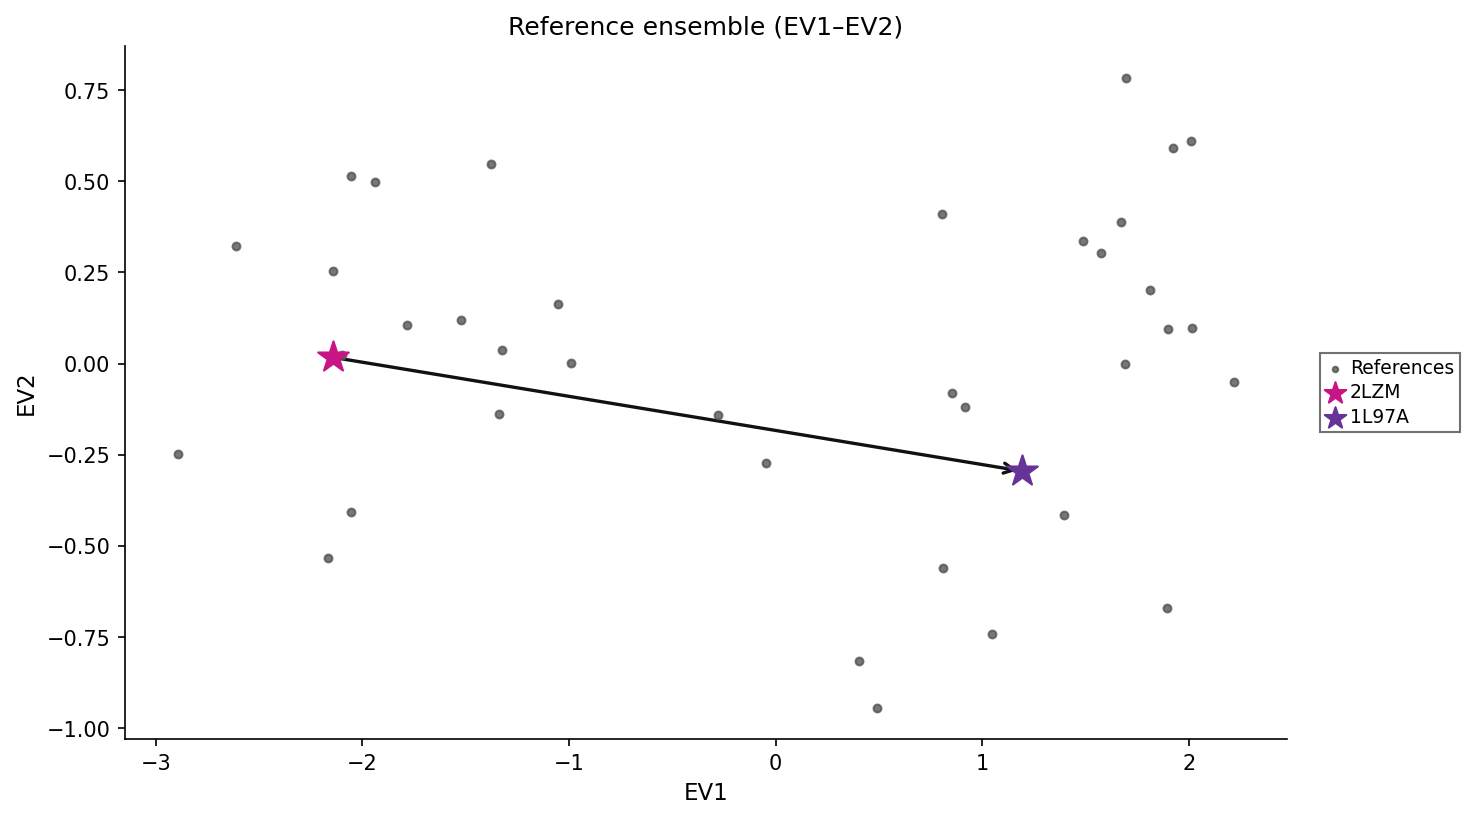

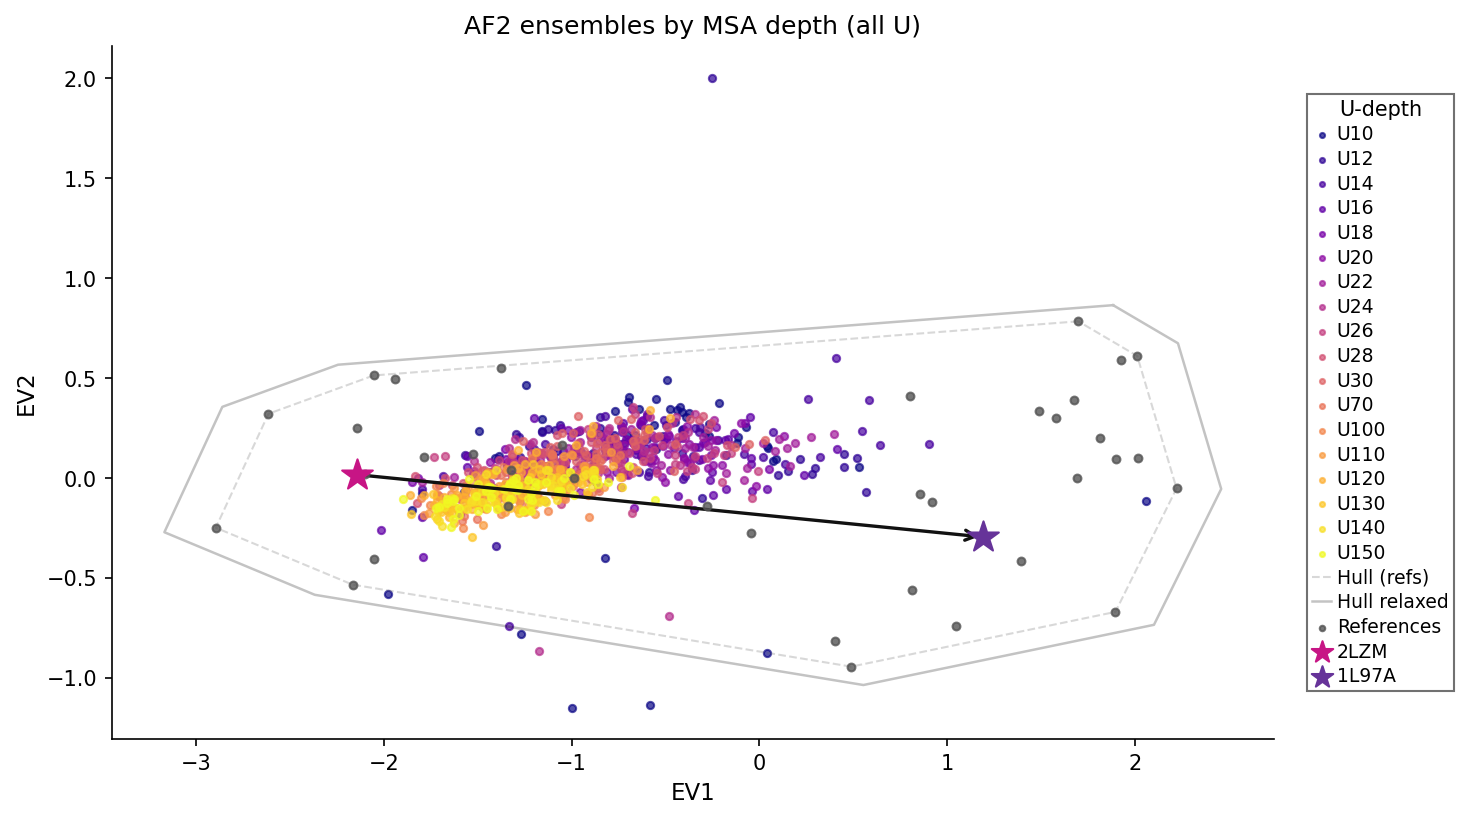

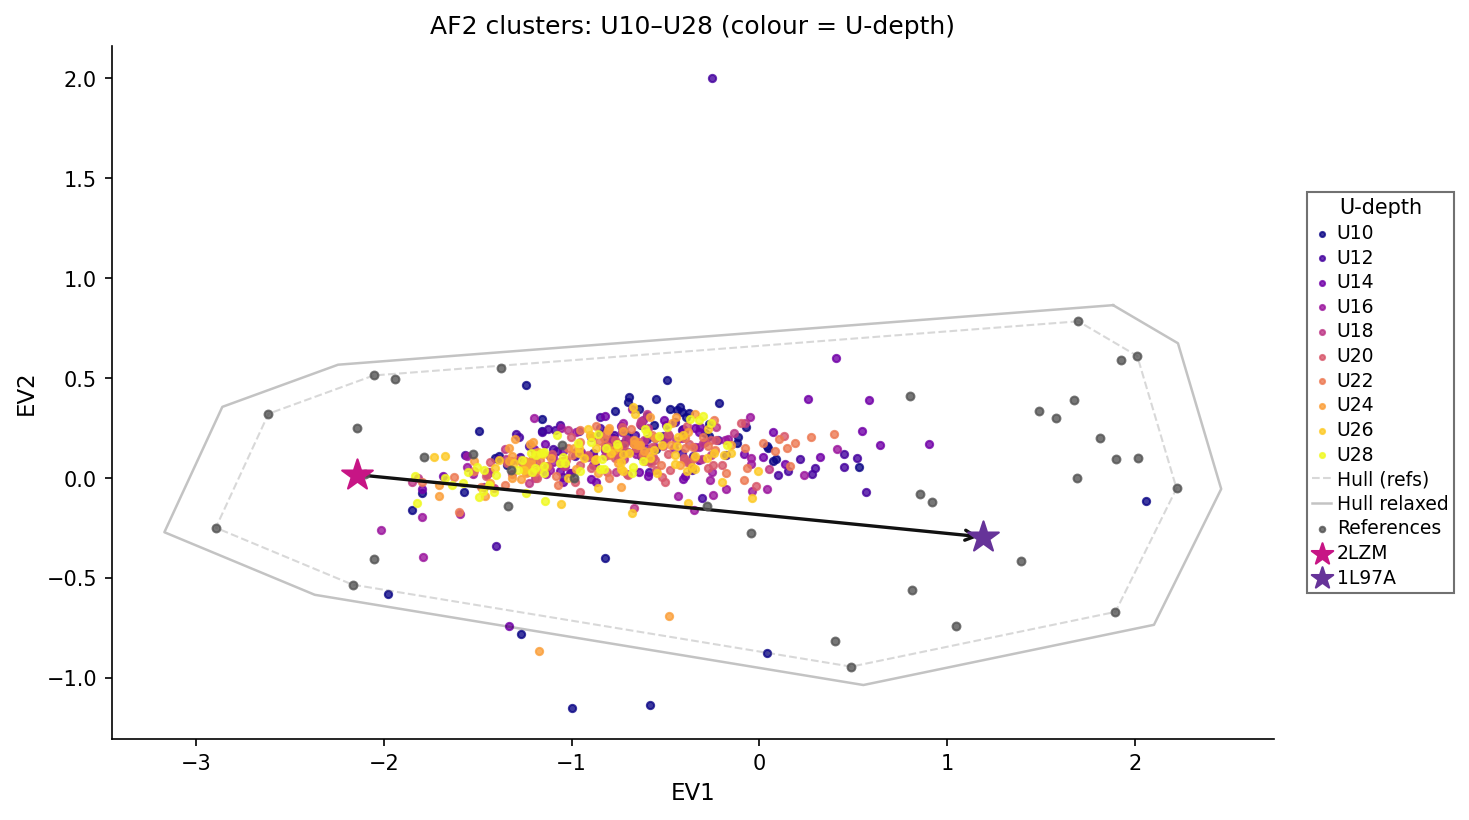

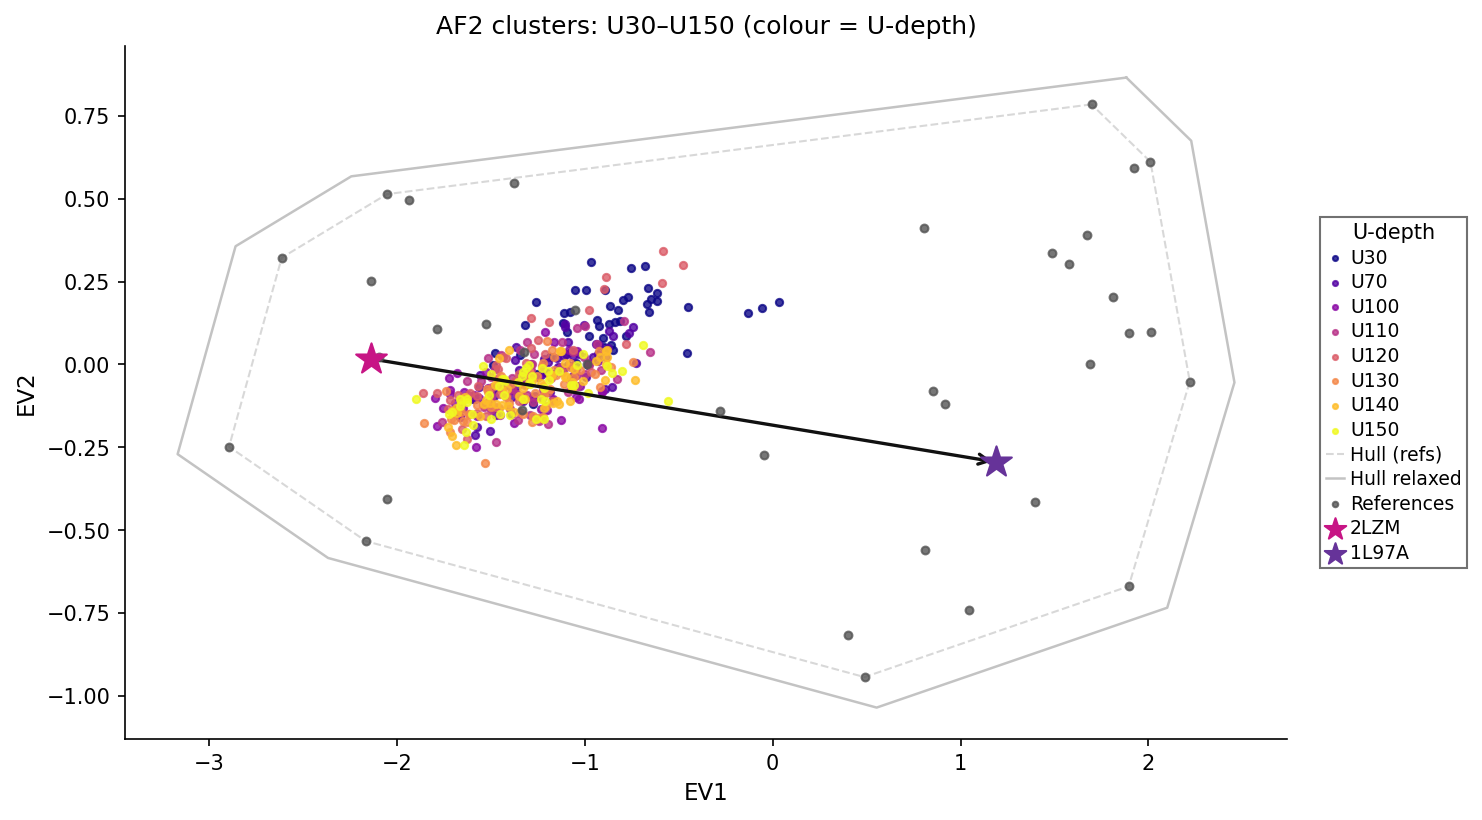

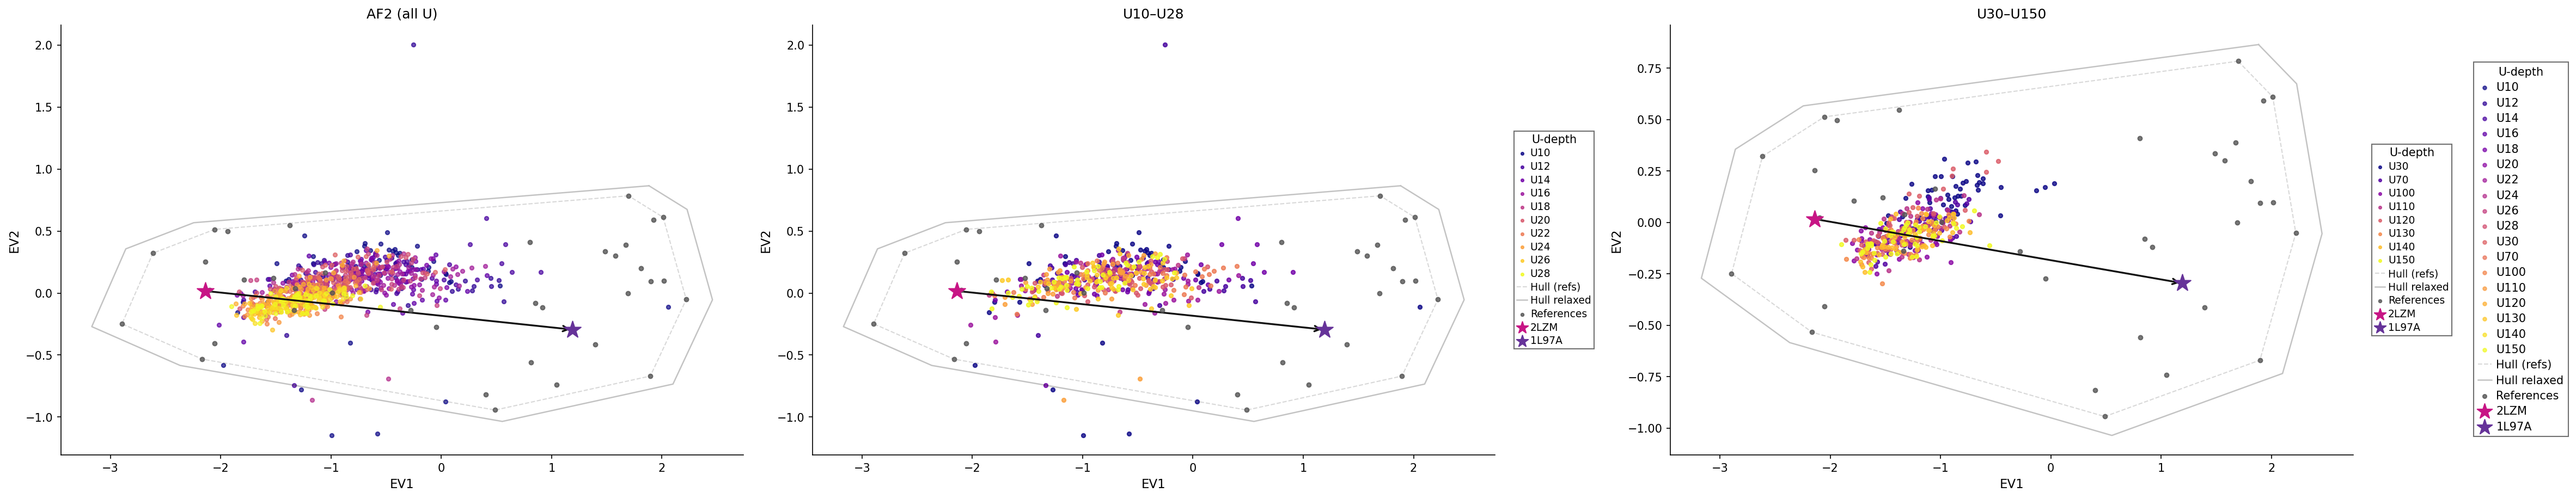

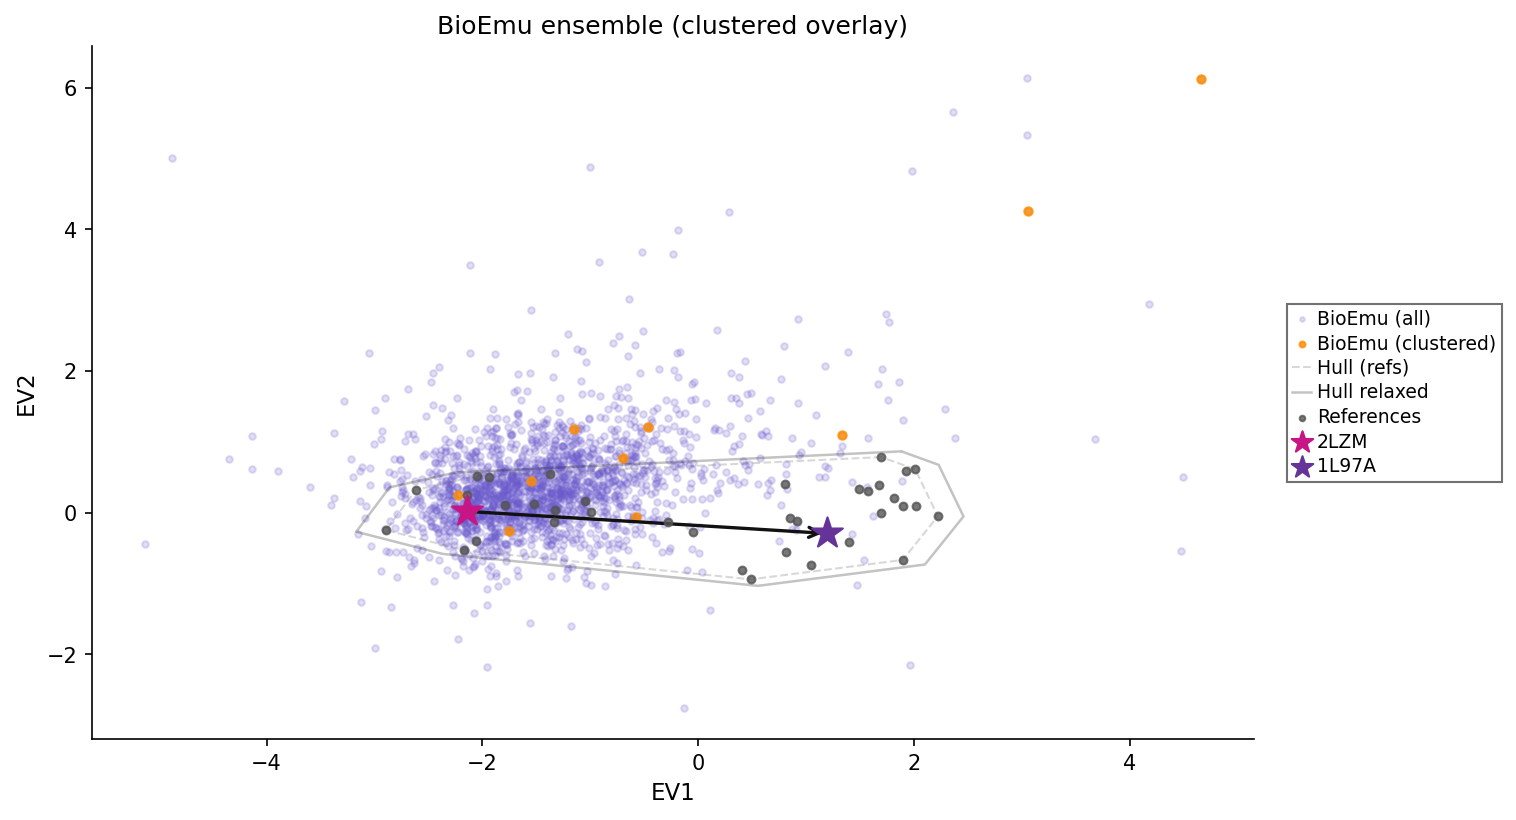

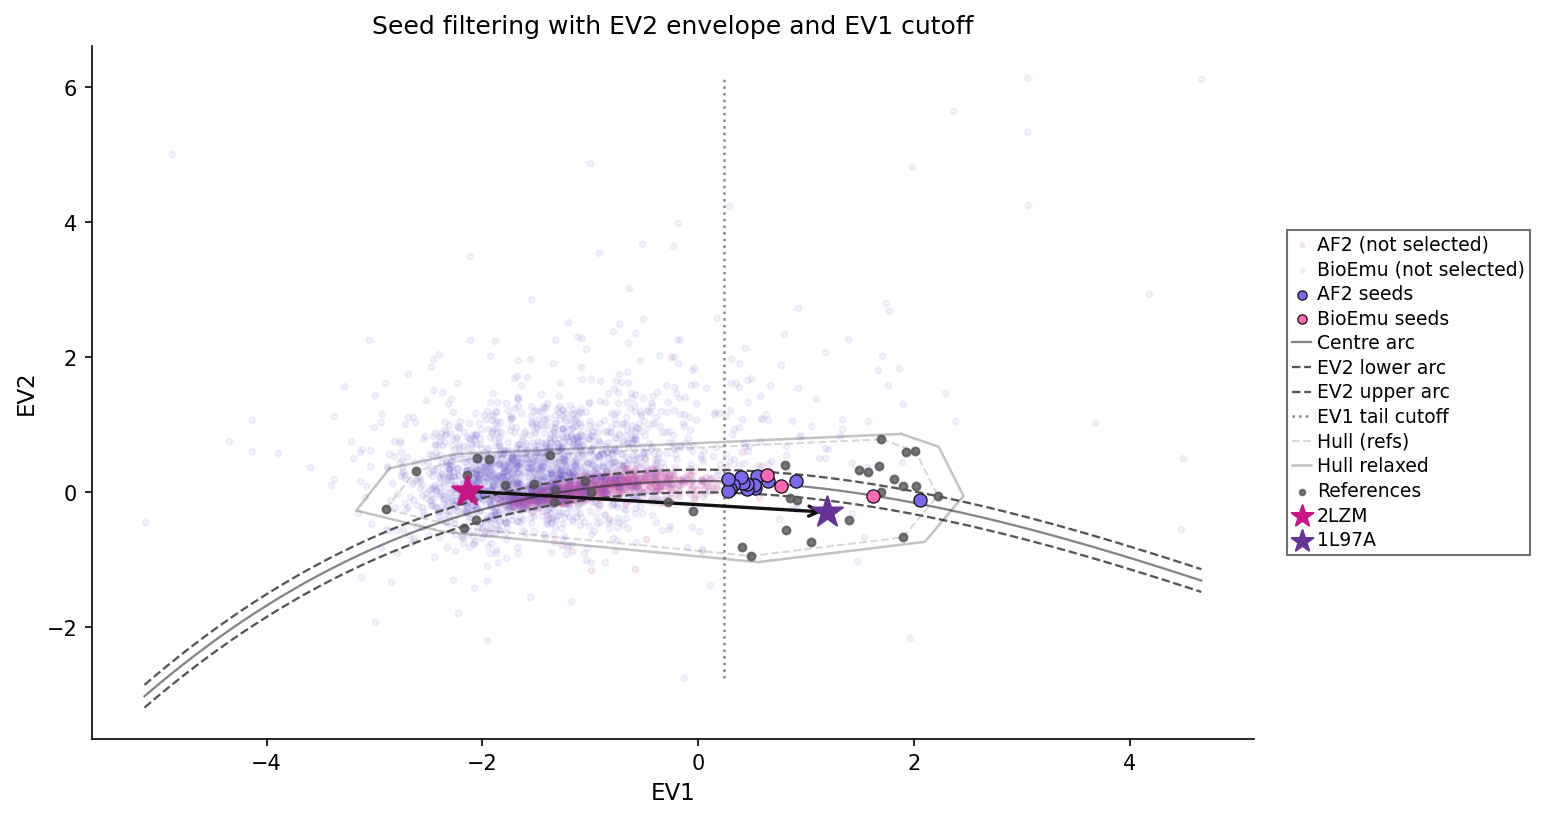

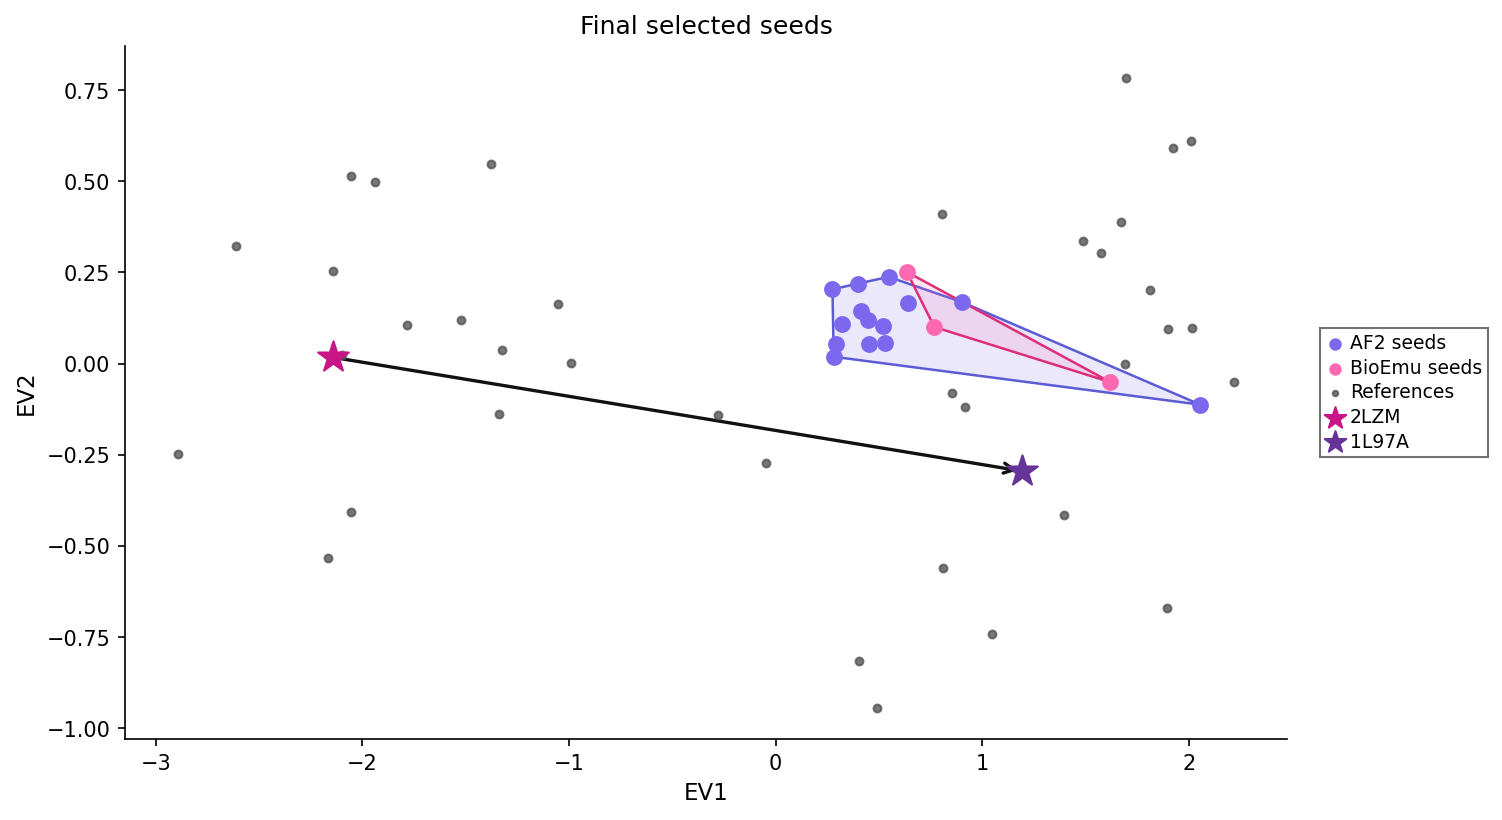

In [10]:
# ==============================================================
# FIGURES_EXPORT — final paper figures (consistent colours + bounds)
# ==============================================================

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull

FIGDIR = Path("figs_export")
FIGDIR.mkdir(exist_ok=True)

# --- Consistent colours ---
COL_REF       = "#555555"          # neutral grey for references
COL_AF2       = "#C75DAB"          # AF2 background (pink-magenta)
COL_AF2_SEED  = "#7B68EE"          # AF2 seeds (soft purple)
COL_BIO       = "#6A5ACD"          # BioEmu background (slate blue-purple)
COL_BIO_CLU   = "#FF8C00"          # BioEmu (clustered) — ORANGE
COL_BIO_SEED  = "#FF69B4"          # BioEmu seeds (hot pink)
COL_CLOSED    = "mediumvioletred"  # 2LZM star
COL_OPEN      = "rebeccapurple"    # 1L97A star

STAR_KW  = dict(marker="*", s=240, zorder=6)
ARROW_KW = dict(arrowstyle="->", color="#111111", lw=1.6, mutation_scale=12)

# --- Legend helper: outside on the right, de-duplicated
def legend_outside(ax, title=None):
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    if not uniq: return
    ax.legend(
        [uniq[k] for k in uniq], list(uniq.keys()),
        frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
        fontsize=9, markerscale=0.7, handlelength=1.0, handletextpad=0.3,
        borderpad=0.3, labelspacing=0.3,
        loc="center left", bbox_to_anchor=(1.02, 0.5),
        title=title
    )

def _add_refs_last(ax, df_ref):
    """Plot references and anchors LAST so they sit on top, with arrow 2LZM→1L97A."""
    ax.scatter(df_ref["EV1"], df_ref["EV2"], s=14, c=COL_REF, alpha=0.8, label="References", zorder=4)
    ax.scatter([df_ref.loc[ix_2lzm, "EV1"]], [df_ref.loc[ix_2lzm, "EV2"]],
               c=COL_CLOSED, label="2LZM", **STAR_KW)
    ax.scatter([df_ref.loc[ix_1l97a, "EV1"]], [df_ref.loc[ix_1l97a, "EV2"]],
               c=COL_OPEN, label="1L97A", **STAR_KW)
    ax.annotate("",
        xy=(df_ref.loc[ix_1l97a,"EV1"], df_ref.loc[ix_1l97a,"EV2"]),
        xytext=(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_2lzm,"EV2"]),
        arrowprops=ARROW_KW)

def _plot_relaxed_ref_hull(ax):
    """Optional relaxed reference hull outline for context."""
    R = df_ref[["EV1","EV2"]].to_numpy(float)
    if R.shape[0] < 3 or np.linalg.matrix_rank(R - R.mean(0)) < 2:
        return
    hull = ConvexHull(R)
    poly = R[hull.vertices]
    ring = np.vstack([poly, poly[0]])
    ax.plot(ring[:,0], ring[:,1], ls="--", lw=1.0, c="#666666", alpha=0.25, label="Hull (refs)")
    centroid = poly.mean(axis=0)
    ring_s = centroid + 1.10 * (ring - centroid)
    ax.plot(ring_s[:,0], ring_s[:,1], ls="-", lw=1.2, c="#111111", alpha=0.25, label="Hull relaxed")

def _title_axes(ax, title):
    ax.set_title(title)
    ax.set_xlabel("EV1")
    ax.set_ylabel("EV2")

def _u_to_int(u):
    import re
    if isinstance(u, str):
        m = re.search(r"U(\d+)", u)
        if m: return int(m.group(1))
    return np.nan

# --------------------------
# Figure 3a — Reference PCA (10x6)
# --------------------------
fig, ax = plt.subplots(figsize=(10,6))
_add_refs_last(ax, df_ref)
_title_axes(ax, "Reference ensemble (EV1–EV2)")
legend_outside(ax)
fig.savefig(FIGDIR/"Figure3a_reference.png", dpi=300, bbox_inches="tight")
fig.savefig(FIGDIR/"Figure3a_reference.pdf", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------
# Figure 3b.1 — AF2 ensembles (all U; 10x6)
# --------------------------
fig, ax = plt.subplots(figsize=(10,6))
if "U_level" in df_af2.columns:
    u_levels = sorted(df_af2["U_level"].dropna().unique(), key=lambda u: int(str(u).replace("U","")))
    cmap = plt.cm.plasma
    col_map = {u: cmap(i/(max(len(u_levels)-1,1))) for i,u in enumerate(u_levels)}
    for u in u_levels:
        d = df_af2[df_af2["U_level"]==u]
        ax.scatter(d["ev1"], d["ev2"], s=12, c=[col_map[u]], alpha=0.7, label=str(u))
else:
    ax.scatter(df_af2["ev1"], df_af2["ev2"], s=12, c=COL_AF2, alpha=0.7, label="AF2")
_plot_relaxed_ref_hull(ax)
_add_refs_last(ax, df_ref)
_title_axes(ax, "AF2 ensembles by MSA depth (all U)")
legend_outside(ax, title="U-depth")
fig.savefig(FIGDIR/"Figure3b1_AF2_allU.png", dpi=300, bbox_inches="tight")
fig.savefig(FIGDIR/"Figure3b1_AF2_allU.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Helper: AF2 clusters within a U-range (one colour per U; clusters share the U colour)
def _plot_af2_clusters_by_urange(ax, u_lo, u_hi, title):
    if "U_level" not in df_af2.columns:
        ax.text(0.02, 0.96, "No U_level in df_af2", transform=ax.transAxes, ha="left", va="top")
        return
    af2c = df_af2.rename(columns={"ev1":"EV1","ev2":"EV2"}).copy()
    af2c["U_num"] = af2c["U_level"].map(_u_to_int)
    m = af2c["U_num"].between(u_lo, u_hi, inclusive="both")
    sub = af2c[m].copy()
    if sub.empty:
        ax.text(0.02, 0.96, f"No AF2 models in U{u_lo}–U{u_hi}", transform=ax.transAxes, ha="left", va="top")
        return
    u_levels = sorted(sub["U_level"].unique(), key=_u_to_int)
    cmap = plt.cm.plasma
    col_map = {u: cmap(i/(max(len(u_levels)-1,1))) for i,u in enumerate(u_levels)}
    for u in u_levels:
        d = sub[sub["U_level"] == u]
        ax.scatter(d["EV1"], d["EV2"], s=12, c=[col_map[u]], alpha=0.8, label=str(u))
    _plot_relaxed_ref_hull(ax)
    _add_refs_last(ax, df_ref)
    _title_axes(ax, title)
    legend_outside(ax, title="U-depth")

# --------------------------
# Figure 3b.2 — AF2 clusters U10–U28 (10x6)
# --------------------------
fig, ax = plt.subplots(figsize=(10,6))
_plot_af2_clusters_by_urange(ax, 10, 28, "AF2 clusters: U10–U28 (colour = U-depth)")
fig.savefig(FIGDIR/"Figure3b2_AF2_U10_U28.png", dpi=300, bbox_inches="tight")
fig.savefig(FIGDIR/"Figure3b2_AF2_U10_U28.pdf", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------
# Figure 3b.3 — AF2 clusters U30–U150 (10x6)
# --------------------------
fig, ax = plt.subplots(figsize=(10,6))
_plot_af2_clusters_by_urange(ax, 30, 150, "AF2 clusters: U30–U150 (colour = U-depth)")
fig.savefig(FIGDIR/"Figure3b3_AF2_U30_U150.png", dpi=300, bbox_inches="tight")
fig.savefig(FIGDIR/"Figure3b3_AF2_U30_U150.pdf", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------
# Figure 3b — combined 3-panel (all U, U10–U28, U30–U150) w/ ONE outside legend
# --------------------------
fig, axs = plt.subplots(1, 3, figsize=(30,6), constrained_layout=True)

# Panel 1: all U
ax0 = axs[0]
if "U_level" in df_af2.columns:
    u_levels = sorted(df_af2["U_level"].dropna().unique(), key=lambda u: int(str(u).replace("U","")))
    cmap = plt.cm.plasma
    col_map = {u: cmap(i/(max(len(u_levels)-1,1))) for i,u in enumerate(u_levels)}
    for u in u_levels:
        d = df_af2[df_af2["U_level"]==u]
        ax0.scatter(d["ev1"], d["ev2"], s=12, c=[col_map[u]], alpha=0.7, label=str(u))
else:
    ax0.scatter(df_af2["ev1"], df_af2["ev2"], s=12, c=COL_AF2, alpha=0.7, label="AF2")
_plot_relaxed_ref_hull(ax0); _add_refs_last(ax0, df_ref); _title_axes(ax0, "AF2 (all U)")

# Panel 2: U10–U28
ax1 = axs[1]
_plot_af2_clusters_by_urange(ax1, 10, 28, "U10–U28")

# Panel 3: U30–U150
ax2 = axs[2]
_plot_af2_clusters_by_urange(ax2, 30, 150, "U30–U150")

# Single shared legend outside (collect from ax0 so colours are complete)
h, l = ax0.get_legend_handles_labels()
uniq = dict(zip(l, h))
fig.legend(
    [uniq[k] for k in uniq], list(uniq.keys()),
    frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
    fontsize=10, markerscale=0.9, handlelength=1.2, handletextpad=0.4,
    borderpad=0.4, labelspacing=0.4,
    loc="center left", bbox_to_anchor=(1.005, 0.5), title="U-depth"
)
fig.savefig(FIGDIR/"Figure3b_AF2_combined.png", dpi=300, bbox_inches="tight")
fig.savefig(FIGDIR/"Figure3b_AF2_combined.pdf", dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------------------
# Figure 3c — BioEmu + clustered BioEmu (10x6)
# -----------------------------------------
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_bio["ev1"], df_bio["ev2"], s=10, c=COL_BIO, alpha=0.20, label="BioEmu (all)")
if "df_bioc" in globals() and df_bioc is not None and len(df_bioc):
    ax.scatter(df_bioc["ev1"], df_bioc["ev2"], s=16, c=COL_BIO_CLU, alpha=0.8, label="BioEmu (clustered)")
_plot_relaxed_ref_hull(ax)
_add_refs_last(ax, df_ref)
_title_axes(ax, "BioEmu ensemble (clustered overlay)")
legend_outside(ax)
fig.savefig(OUT34/"Figure3c_BioEmu.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT34/"Figure3c_BioEmu.pdf", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------------------------------
# Figure 4a — Seed filtering with envelope + cutoff (8x7)
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10,6))
nonseed = ~df_af2["model_id"].isin(selected["model_id"])
ax.scatter(df_af2.loc[nonseed,"ev1"], df_af2.loc[nonseed,"ev2"], s=8, c=COL_AF2, alpha=0.12, label="AF2 (not selected)")
ax.scatter(df_bio["ev1"], df_bio["ev2"], s=8, c=COL_BIO, alpha=0.08, label="BioEmu (not selected)")

sel_af2 = selected.query("method=='AF2'")
sel_bio = selected.query("method=='BioEmu'")
if len(sel_af2):
    ax.scatter(sel_af2["ev1"], sel_af2["ev2"], s=40, c=COL_AF2_SEED, edgecolor="#111111", lw=0.6, label="AF2 seeds", zorder=5)
if len(sel_bio):
    ax.scatter(sel_bio["ev1"], sel_bio["ev2"], s=40, c=COL_BIO_SEED, edgecolor="#111111", lw=0.6, label="BioEmu seeds", zorder=5)

# Envelope bounds (if available)
try:
    x_min = float(min(df_ref["EV1"].min(), df_af2["ev1"].min(), df_bio["ev1"].min()))
    x_max = float(max(df_ref["EV1"].max(), df_af2["ev1"].max(), df_bio["ev1"].max()))
    x_grid = np.linspace(x_min, x_max, 600)
    ax.plot(x_grid, ev2_center(x_grid), "-",  lw=1.1, c="#222222", alpha=0.55, label="Centre arc")
    ax.plot(x_grid, ev2_lo_fun(x_grid), "--", lw=1.1, c="#444444", alpha=0.9,  label="EV2 lower arc")
    ax.plot(x_grid, ev2_hi_fun(x_grid), "--", lw=1.1, c="#444444", alpha=0.9,  label="EV2 upper arc")
except Exception:
    pass

# EV1 tail cutoff (if available)
try:
    ymin = float(min(df_ref["EV2"].min(), df_af2["ev2"].min(), df_bio["ev2"].min()))
    ymax = float(max(df_ref["EV2"].max(), df_af2["ev2"].max(), df_bio["ev2"].max()))
    ax.vlines(float(af2_ev1_tail_cut), ymin=ymin, ymax=ymax, linestyles=":", linewidth=1.2, colors="#888888", label="EV1 tail cutoff")
except Exception:
    pass

_plot_relaxed_ref_hull(ax)
_add_refs_last(ax, df_ref)
_title_axes(ax, "Seed filtering with EV2 envelope and EV1 cutoff")
legend_outside(ax)
fig.savefig(FIGDIR/"Figure4a_seed_filter.png", dpi=300, bbox_inches="tight")
fig.savefig(FIGDIR/"Figure4a_seed_filter.pdf", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------------------
# Figure 4b — Final selected seeds only (8x7)
# ---------------------------------------
fig, ax = plt.subplots(figsize=(10,6))
if len(sel_af2):
    ax.scatter(sel_af2["ev1"], sel_af2["ev2"], s=50, c=COL_AF2_SEED, label="AF2 seeds", zorder=3)
if len(sel_bio):
    ax.scatter(sel_bio["ev1"], sel_bio["ev2"], s=50, c=COL_BIO_SEED, label="BioEmu seeds", zorder=3)

def _maybe_hull(ax, df_xy, face_rgba, edge):
    P = df_xy[["ev1","ev2"]].to_numpy()
    if P.shape[0] >= 3:
        H = ConvexHull(P)
        poly = Polygon(P[H.vertices], closed=True, facecolor=face_rgba, edgecolor=edge, lw=1.2, zorder=2)
        ax.add_patch(poly)

_maybe_hull(ax, sel_af2, (0.48,0.42,0.93,0.15), "#5B5BD6")  # light purple wash
_maybe_hull(ax, sel_bio, (1.00,0.41,0.71,0.15), "#DD2E77")  # light pink wash

_add_refs_last(ax, df_ref)
_title_axes(ax, "Final selected seeds")
legend_outside(ax)
fig.savefig(FIGDIR/"Figure4b_seed_final.png", dpi=300, bbox_inches="tight")
fig.savefig(FIGDIR/"Figure4b_seed_final.pdf", dpi=300, bbox_inches="tight")
plt.show()


[§3.2] Figure 3a already exists, skipping.


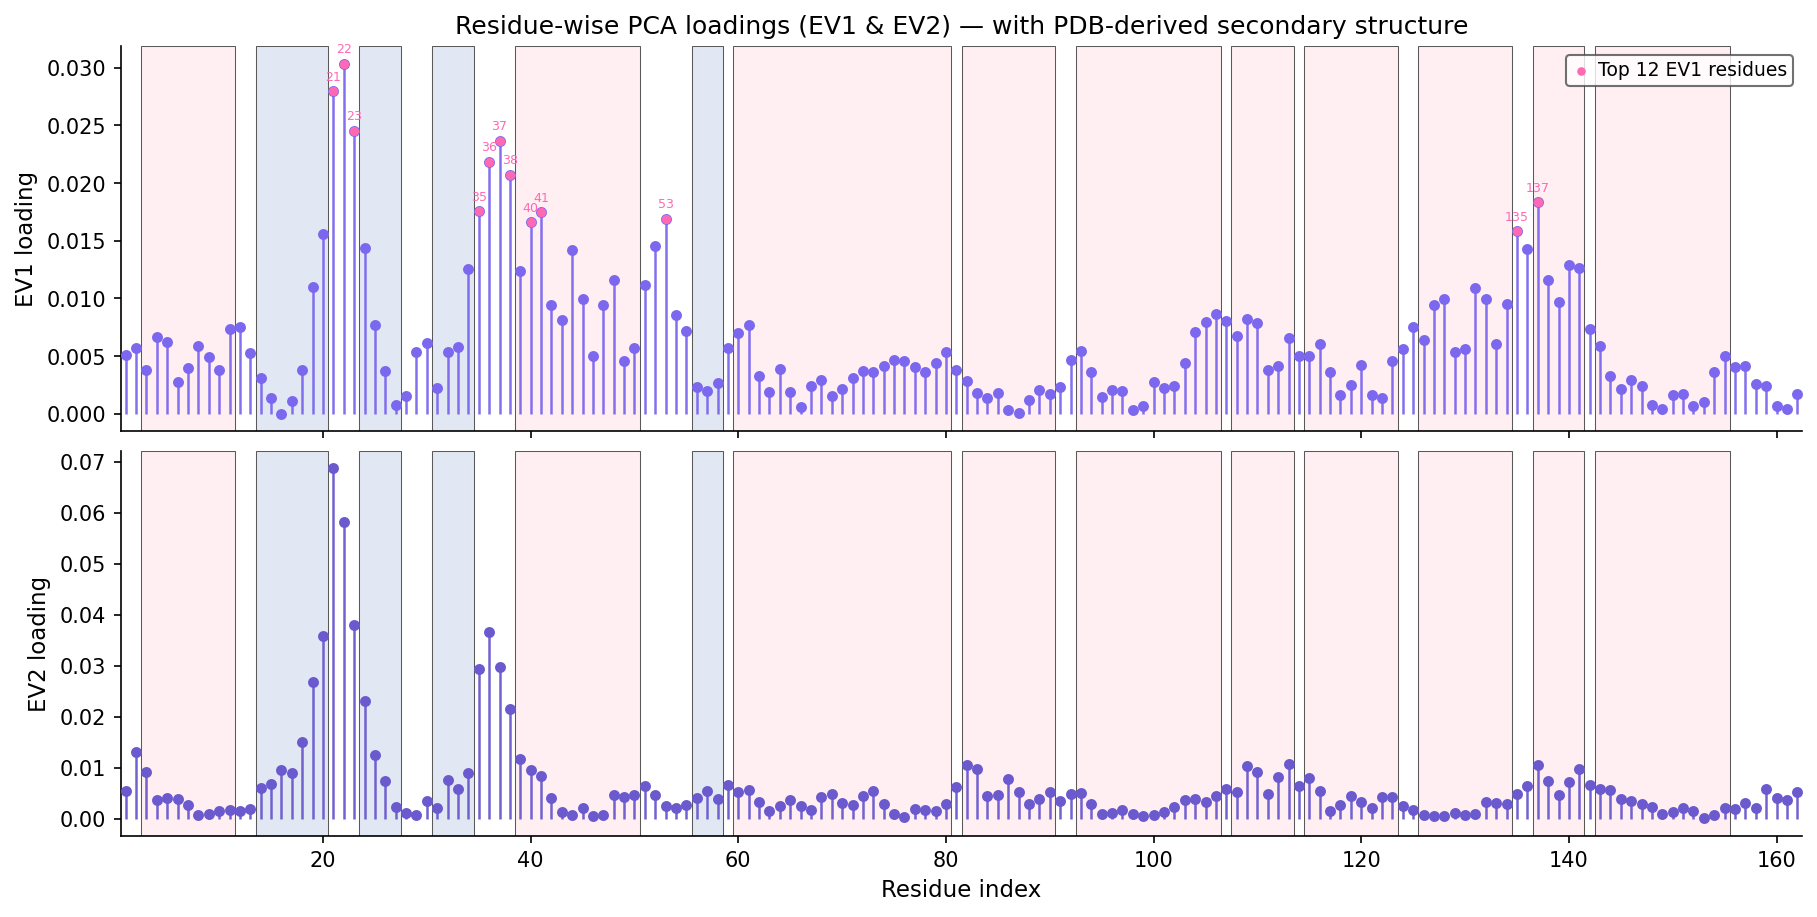

[§3.2] Wrote Figure 3b → exports_panel3_2/Figure_loadings.png, exports_panel3_2/Figure_loadings.pdf
[§3.2] Wrote appendix table → exports_panel3_2/table_3_1_appendix_combined.csv
[§3.2] Wrote publishable table → exports_panel3_2/table_3_1_publishable.csv

[Preview] Publishable table:


Explained variance EV1 (%) Explained variance EV2 (%)  \
0                     86.4 %                      5.4 %   

  Cumulative EV1+EV2 (%) EV1–EV2 hull area (units) Centroid EV1 (EV units)  \
0                 91.9 %               5.71 ± 0.60           0.016 ± 0.393   

  Centroid EV2 (EV units) EV1(2LZMA) EV1(1L97A) EV1 separation (open−closed)  \
0           0.002 ± 0.100     -2.140      1.190                        3.331   

  Pairwise RMSD median (Å) Pairwise RMSD 95th (Å) RMSD 2LZMA↔1L97A (Å)  
0            0.16 ± 0.17 Å                 0.33 Å               0.27 Å


[Preview] Appendix (head):


ev1_var_percent  ev2_var_percent  cum_var_percent  ev1_var_p5  ev1_var_p50  \
0        86.444712         5.434902        91.879612         NaN          NaN   

   ev1_var_p95  ev2_var_p5  ev2_var_p50  ev2_var_p95  hull_area_ev12  ...  \
0          NaN         NaN          NaN          NaN        6.451345  ...   

   centroid_ev2_p95  ev1_2lzm  ev1_1l97a  ev1_separation  \
0          0.101803 -2.140483   1.190415        3.330897   

   pairwise_median_rmsd_A  pairwise_p95_rmsd_A  pairwise_rmsd_p5_A  \
0                 0.15999             0.329953            0.056724   

   pairwise_rmsd_p50_A  pairwise_rmsd_p95_A  rmsd_2LZM_to_1L97A_A  
0              0.15999             0.329953              0.265692  

[1 rows x 30 columns]

In [11]:
# ==============================================================
# §3.2 — Exports (figures + table) — create only if missing
# ==============================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# --- Paths
FIGDIR = Path("figs_export"); FIGDIR.mkdir(exist_ok=True)
OUTDIR = Path(globals().get("OUT32", "exports_panel3_2"))
OUTDIR.mkdir(exist_ok=True, parents=True)

f_fig3a_png = FIGDIR/"Figure3a_reference.png"
f_fig3a_pdf = FIGDIR/"Figure3a_reference.pdf"
f_fig3b_png = FIGDIR/"Figure3b_loadings.png"
f_fig3b_pdf = FIGDIR/"Figure3b_loadings.pdf"
f_tab31     = OUTDIR/"Table3_1_ref_rmsd_stats.csv"

# --- Colors (consistent with paper)
COL_REF    = "#555555"
COL_CLOSED = "mediumvioletred"
COL_OPEN   = "rebeccapurple"
COL_EV1    = "#7B68EE"   # EV1 loadings
COL_EV2    = "#6A5ACD"   # EV2 loadings
COL_TOP    = "#FF69B4"   # highlight top EV1 residues

STAR_KW  = dict(marker="*", s=240, zorder=6)
ARROW_KW = dict(arrowstyle="->", color="#111111", lw=1.6, mutation_scale=12)

def legend_outside_right(ax, **kw):
    """Compact legend placed outside (right)."""
    defaults = dict(frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
                    fontsize=9, markerscale=0.8, handlelength=1.0, handletextpad=0.4,
                    borderpad=0.3, labelspacing=0.4, loc="center left", bbox_to_anchor=(1.02, 0.5))
    defaults.update(kw)
    ax.legend(**defaults)

def lollipop(ax, x, y, color, marker="o", size=18, lw=1.2):
    ax.vlines(x, 0, y, color=color, linewidth=lw, alpha=0.9)
    ax.scatter(x, y, c=color, s=size, zorder=3)

# ----------------------------
# Figure 3a — Reference PCA
# ----------------------------
if not (f_fig3a_png.exists() and f_fig3a_pdf.exists()):
    fig, ax = plt.subplots(figsize=(10,6))

    # Reference cloud
    ax.scatter(df_ref["EV1"], df_ref["EV2"], s=14, c=COL_REF, alpha=0.8, label="References", zorder=4)

    # Stars on top + arrow 2LZM -> 1L97A
    ax.scatter([df_ref.loc[ix_2lzm, "EV1"]], [df_ref.loc[ix_2lzm, "EV2"]],
               c=COL_CLOSED, label="2LZM", **STAR_KW)
    ax.scatter([df_ref.loc[ix_1l97a, "EV1"]], [df_ref.loc[ix_1l97a, "EV2"]],
               c=COL_OPEN, label="1L97A", **STAR_KW)
    ax.annotate("", xy=(df_ref.loc[ix_1l97a,"EV1"], df_ref.loc[ix_1l97a,"EV2"]),
                    xytext=(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_2lzm,"EV2"]),
                    arrowprops=ARROW_KW)

    # Optional: reference hull (faint)
    R = df_ref[["EV1","EV2"]].to_numpy(float)
    if R.shape[0] >= 3 and np.linalg.matrix_rank(R - R.mean(0)) >= 2:
        hull = ConvexHull(R)
        poly = R[hull.vertices]
        ring = np.vstack([poly, poly[0]])
        ax.plot(ring[:,0], ring[:,1], ls="--", lw=1.0, c="#666666", alpha=0.25, label="Hull (refs)")

    ax.set_title("Reference ensemble (EV1–EV2)")
    ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
    legend_outside_right(ax)

    fig.savefig(f_fig3a_png, dpi=300, bbox_inches="tight")
    fig.savefig(f_fig3a_pdf, dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("[§3.2] Figure 3a already exists, skipping.")

# ==============================================================
# §3.2 — Figure 3b (Loadings) using secondary structure from 2lzm.pdb
# ==============================================================

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PDB_PATH = Path("2lzm.pdb")   # <-- make sure this is present in the working dir
FIGDIR = OUTDIR
f_fig3b_png = FIGDIR/"Figure_loadings.png"
f_fig3b_pdf = FIGDIR/"Figure_loadings.pdf"

# --- Colors (consistent with your palette)
COL_EV1  = "#7B68EE"  # EV1 sticks
COL_EV2  = "#6A5ACD"  # EV2 sticks
COL_TOP  = "#FF69B4"  # highlight top EV1 residues
# Secondary structure band colours
BAND_HELIX = (1.00, 0.75, 0.80, 0.25)   # soft pink (alpha 0.25)
BAND_SHEET = (0.42, 0.55, 0.80, 0.20)   # slate-blue (alpha 0.20)
BAND_EDGE  = "0.35"

# --- 1) Compute df_loadings if missing
def compute_residue_loadings_from_pca(pca_obj, X_ref_array):
    comp = pca_obj.components_            # (n_components, 3*n_atoms)
    n_atoms = X_ref_array.shape[1] // 3
    loadings = np.zeros((comp.shape[0], n_atoms))
    for r in range(n_atoms):
        sl = slice(3*r, 3*r+3)
        loadings[:, r] = (comp[:, sl]**2).sum(axis=1)
    loadings = loadings / loadings.sum(axis=1, keepdims=True)
    df = pd.DataFrame(loadings.T, columns=[f"EV{i+1}" for i in range(loadings.shape[0])])
    df.insert(0, "residue_index", np.arange(1, n_atoms+1))
    return df

if "df_loadings" not in globals():
    df_loadings = compute_residue_loadings_from_pca(pca, X_ref)

n_res = int(df_loadings["residue_index"].max())

# --- 2) Parse HELIX/SHEET records from the PDB (chain A by default)
def parse_pdb_secondary_structure(pdb_path: Path, chain="A"):
    helices = []  # list of (start, end)
    sheets  = []  # list of (start, end)

    if not pdb_path.exists():
        print(f"[WARN] PDB file not found: {pdb_path}. Skipping SS shading.")
        return helices, sheets

    with open(pdb_path, "r") as f:
        for line in f:
            rec = line[:6].strip()
            if rec == "HELIX":
                # Columns (PDB v3.3): initChainID (19), initSeqNum (21-25), initICode (26)
                #                      endChainID (31),  endSeqNum (33-37),  endICode (38)
                ch_i = line[19].strip()
                ch_j = line[31].strip()
                if ch_i == chain and ch_j == chain:
                    try:
                        start = int(line[21:25].strip())
                        end   = int(line[33:37].strip())
                        helices.append((start, end))
                    except ValueError:
                        pass
            elif rec == "SHEET":
                # Columns: initChainID (21), initSeqNum (22-26), initICode (27)
                #          endChainID  (32), endSeqNum  (33-37), endICode  (38)
                ch_i = line[21].strip()
                ch_j = line[32].strip()
                if ch_i == chain and ch_j == chain:
                    try:
                        start = int(line[22:26].strip())
                        end   = int(line[33:37].strip())
                        sheets.append((start, end))
                    except ValueError:
                        pass
    # Clip to [1, n_res] in case numbering runs beyond (rare but safe)
    helices = [(max(1, s), min(n_res, e)) for (s, e) in helices if s <= n_res and e >= 1]
    sheets  = [(max(1, s), min(n_res, e)) for (s, e) in sheets  if s <= n_res and e >= 1]
    return helices, sheets

helices, sheets = parse_pdb_secondary_structure(PDB_PATH, chain="A")

# --- 3) Plot: EV1/EV2 lollipop with SS shading from PDB
def lollipop(ax, x, y, color, marker="o", size=18, lw=1.2, z=2):
    ax.vlines(x, 0, y, color=color, linewidth=lw, alpha=0.95, zorder=z)
    ax.scatter(x, y, c=color, s=size, zorder=z+1)

# Build figure
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, constrained_layout=True)

# SS shading (drawn first so sticks sit on top)
def add_ss_bands(ax):
    # Helices
    for (s, e) in helices:
        ax.axvspan(s-0.5, e+0.5, facecolor=BAND_HELIX, edgecolor=BAND_EDGE, linewidth=0.5, zorder=0)
    # Sheets
    for (s, e) in sheets:
        ax.axvspan(s-0.5, e+0.5, facecolor=BAND_SHEET, edgecolor=BAND_EDGE, linewidth=0.5, zorder=0)

x  = df_loadings["residue_index"].to_numpy()
y1 = df_loadings["EV1"].to_numpy()
y2 = df_loadings["EV2"].to_numpy()

# Top EV1 contributors (label a few)
TOP_K_LABEL = 12
top_idx = df_loadings.nlargest(TOP_K_LABEL, "EV1")["residue_index"].tolist()

# EV1 panel
ax = axes[0]
add_ss_bands(ax)
lollipop(ax, x, y1, COL_EV1)
ax.scatter(
    df_loadings.loc[df_loadings["residue_index"].isin(top_idx), "residue_index"],
    df_loadings.loc[df_loadings["residue_index"].isin(top_idx), "EV1"],
    s=12, c=COL_TOP, label=f"Top {TOP_K_LABEL} EV1 residues", zorder=4
)
# Label the top points (small offset)
for ridx in top_idx:
    yy = float(df_loadings.loc[df_loadings["residue_index"]==ridx, "EV1"].iloc[0])
    ax.annotate(str(ridx), (ridx, yy),
                xytext=(0, 10), textcoords="offset points", ha="center", va="top",
                fontsize=6, color=COL_TOP)


ax.set_ylabel("EV1 loading")
ax.set_title("Residue-wise PCA loadings (EV1 & EV2) — with PDB-derived secondary structure")
# Legend outside on the right
h, l = ax.get_legend_handles_labels()
uniq = dict(zip(l, h))
ax.legend([uniq[k] for k in uniq], list(uniq.keys()),
          frameon=True, edgecolor="0.3", facecolor="white",
          fontsize=9, markerscale=0.9, handlelength=1.0, handletextpad=0.4,
          borderpad=0.3, labelspacing=0.4,
          loc="upper right")

# EV2 panel
ax = axes[1]
add_ss_bands(ax)
lollipop(ax, x, y2, COL_EV2)
ax.set_xlabel("Residue index")
ax.set_ylabel("EV2 loading")

# Tidy x-lims to exactly cover 1..n_res
axes[0].set_xlim(0.5, n_res + 0.5)
axes[1].set_xlim(0.5, n_res + 0.5)

# Save
fig.savefig(f_fig3b_png, dpi=300, bbox_inches="tight")
fig.savefig(f_fig3b_pdf, dpi=300, bbox_inches="tight")
plt.show()

print(f"[§3.2] Wrote Figure 3b → {f_fig3b_png}, {f_fig3b_pdf}")



"""
Standalone helpers to generate §3.2 publishable and appendix CSVs that combine
PCA (reference-only) and RMSD ensemble stats, with ± errors derived from the 95th percentile.

Inputs expected to already exist in the notebook state:
- X_ref: np.ndarray (n_ref, 3*N_atoms), pre-aligned to 2LZM
- scores_ref: np.ndarray (n_ref, >=2), PCA scores in the shared reference PCA
- pca: fitted sklearn.decomposition.PCA on X_ref (n_components>=2)
- evr: explained_variance_ratio_ from the fitted PCA
- df_ref: DataFrame with columns ['EV1','EV2','PDB'] for references
- ix_2lzm, ix_1l97a: integer row indices in df_ref for 2LZMA and 1L97A

Outputs:
- OUT32/table_3_1_appendix_combined.csv  (raw medians, percentiles, units)
- OUT32/table_3_1_publishable.csv        (formatted strings with ± and units)

Notes:
- "±" error is computed as (p95 - median) for each statistic.
- For metrics that are single-valued by design (e.g., EVR from the fixed PCA fit,
  EV1 anchor values), we report the value without ±. If you want bootstrap CIs for
  EVR, set BOOTSTRAP_EVR=True to resample references and refit PCA per bootstrap.
"""
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

# -----------------------------
# Configuration
# -----------------------------
OUT32 = Path(globals().get("OUT32", "exports_panel3_2"))
OUT32.mkdir(parents=True, exist_ok=True)
APP_PATH = OUT32 / "table_3_1_appendix_combined.csv"
PUB_PATH = OUT32 / "table_3_1_publishable.csv"

N_BOOT = 800
RNG_SEED = 0
BOOTSTRAP_EVR = False   # set True to compute ± for EVR via resampling+refit

# -----------------------------
# Preconditions
# -----------------------------
_need = ["X_ref","scores_ref","pca","evr","df_ref","ix_2lzm","ix_1l97a"]
for _v in _need:
    if _v not in globals():
        raise RuntimeError(f"Missing required variable in scope: {_v}")

# -----------------------------
# Helpers
# -----------------------------

def reshape_coords(X: np.ndarray) -> np.ndarray:
    n_atoms = X.shape[1] // 3
    return X.reshape(X.shape[0], n_atoms, 3)


def rmsd_to_refs(samples_xyz: np.ndarray, refs_xyz: np.ndarray) -> np.ndarray:
    diffs2 = (samples_xyz[:, None, :, :] - refs_xyz[None, :, :, :]) ** 2
    msd = diffs2.sum(axis=3).mean(axis=2)
    return np.sqrt(msd, dtype=np.float64)


def safe_hull_area(points: np.ndarray) -> float:
    if points is None or points.shape[0] < 3:
        return np.nan
    try:
        return float(ConvexHull(points).volume)
    except Exception:
        return np.nan


def p5_p50_p95(a: np.ndarray) -> tuple[float,float,float]:
    a = np.asarray(a, dtype=float)
    return (float(np.percentile(a, 5)),
            float(np.percentile(a, 50)),
            float(np.percentile(a, 95)))


# -----------------------------
# 1) Deterministic (from existing PCA & arrays)
# -----------------------------
ev1_var = float(evr[0]) * 100.0
ev2_var = float(evr[1]) * 100.0
cum_var = float((evr[0] + evr[1]) * 100.0)

# EV1–EV2 cloud
EV = np.asarray(scores_ref[:, :2], float)
centroid_ev12 = EV.mean(axis=0)
hull_area_ev = safe_hull_area(EV)

# Anchors on EV1
ev1_closed = float(scores_ref[ix_2lzm, 0])
ev1_open   = float(scores_ref[ix_1l97a, 0])
ev1_sep    = ev1_open - ev1_closed

# RMSD ensemble
R_ref = reshape_coords(X_ref)
M_ref = rmsd_to_refs(R_ref, R_ref)
_tri = np.triu(np.ones_like(M_ref, bool), k=1)
dist_pairs = M_ref[_tri]
median_rmsd = float(np.median(dist_pairs))
p95_rmsd    = float(np.percentile(dist_pairs, 95))
rmsd_2lzm_1l97a = float(M_ref[ix_2lzm, ix_1l97a])

# -----------------------------
# 2) Bootstrap (for publishable ± via 95th percentile)
#    We bootstrap EV cloud-derived metrics; EVR bootstrap is optional.
# -----------------------------
rng = np.random.default_rng(RNG_SEED)

boot_hull, boot_cx, boot_cy = [], [], []
for _ in range(N_BOOT):
    idx = rng.integers(0, EV.shape[0], EV.shape[0])
    EVb = EV[idx]
    boot_hull.append(safe_hull_area(EVb))
    c = EVb.mean(axis=0)
    boot_cx.append(c[0]); boot_cy.append(c[1])

hull_p5, hull_med, hull_p95 = p5_p50_p95(np.array(boot_hull)[~np.isnan(boot_hull)])
centx_p5, centx_med, centx_p95 = p5_p50_p95(boot_cx)
centy_p5, centy_med, centy_p95 = p5_p50_p95(boot_cy)

if BOOTSTRAP_EVR:
    from sklearn.decomposition import PCA
    ev1b, ev2b = [], []
    for _ in range(N_BOOT):
        idx = rng.integers(0, X_ref.shape[0], X_ref.shape[0])
        Xb = X_ref[idx]
        ref_mean_b = Xb.mean(axis=0, keepdims=True)
        p = PCA(n_components=2, svd_solver="full", random_state=0).fit(Xb - ref_mean_b)
        ev1b.append(p.explained_variance_ratio_[0] * 100)
        ev2b.append(p.explained_variance_ratio_[1] * 100)
    ev1_p5, ev1_med, ev1_p95 = p5_p50_p95(ev1b)
    ev2_p5, ev2_med, ev2_p95 = p5_p50_p95(ev2b)
else:
    ev1_p5 = ev1_med = ev1_p95 = np.nan
    ev2_p5 = ev2_med = ev2_p95 = np.nan

# RMSD distribution already available → derive p5/p95 around median if desired
rmsd_p5, rmsd_med, rmsd_p95_calc = p5_p50_p95(dist_pairs)
# sanity: p95 from direct calc vs percentile
p95_rmsd = float(rmsd_p95_calc)

# -----------------------------
# 3) Appendix table (raw, machine-friendly)
# -----------------------------
app = pd.DataFrame([{ 
    # PCA EVR (percent)
    "ev1_var_percent": ev1_var,
    "ev2_var_percent": ev2_var,
    "cum_var_percent": cum_var,
    "ev1_var_p5": ev1_p5, "ev1_var_p50": ev1_med, "ev1_var_p95": ev1_p95,
    "ev2_var_p5": ev2_p5, "ev2_var_p50": ev2_med, "ev2_var_p95": ev2_p95,
    # EV cloud
    "hull_area_ev12": hull_area_ev,
    "hull_area_ev12_p5": hull_p5, "hull_area_ev12_p50": hull_med, "hull_area_ev12_p95": hull_p95,
    "centroid_ev1": centroid_ev12[0],
    "centroid_ev1_p5": centx_p5, "centroid_ev1_p50": centx_med, "centroid_ev1_p95": centx_p95,
    "centroid_ev2": centroid_ev12[1],
    "centroid_ev2_p5": centy_p5, "centroid_ev2_p50": centy_med, "centroid_ev2_p95": centy_p95,
    # Anchors / separation (no boot by default)
    "ev1_2lzm": ev1_closed,
    "ev1_1l97a": ev1_open,
    "ev1_separation": ev1_sep,
    # RMSD (Å)
    "pairwise_median_rmsd_A": median_rmsd,
    "pairwise_p95_rmsd_A": p95_rmsd,
    "pairwise_rmsd_p5_A": rmsd_p5,
    "pairwise_rmsd_p50_A": rmsd_med,
    "pairwise_rmsd_p95_A": rmsd_p95_calc,
    "rmsd_2LZM_to_1L97A_A": rmsd_2lzm_1l97a,
}])
app.to_csv(APP_PATH, index=False)
print(f"[§3.2] Wrote appendix table → {APP_PATH}")

# -----------------------------
# 4) Publishable table (human-friendly, with ± and units)
#    ± error := (p95 - median). Units added per field.
# -----------------------------

def pm_from_p95(median_val: float, p95_val: float, ndp: int, unit: str = "") -> str:
    err = max(0.0, float(p95_val) - float(median_val))
    s = f"{median_val:.{ndp}f} ± {err:.{ndp}f}"
    if unit:
        s += f" {unit}"
    return s

pub_rows = [{
    # EVR (kept as values unless BOOTSTRAP_EVR=True)
    "Explained variance EV1 (%)": (
        pm_from_p95(ev1_med, ev1_p95, ndp=1, unit="%") if BOOTSTRAP_EVR else f"{ev1_var:.1f} %"
    ),
    "Explained variance EV2 (%)": (
        pm_from_p95(ev2_med, ev2_p95, ndp=1, unit="%") if BOOTSTRAP_EVR else f"{ev2_var:.1f} %"
    ),
    "Cumulative EV1+EV2 (%)": (
        f"{cum_var:.1f} %"  # can be bootstrapped similarly if needed
    ),
    # EV cloud
    "EV1–EV2 hull area (units)": pm_from_p95(hull_med, hull_p95, ndp=2, unit=""),
    "Centroid EV1 (EV units)":   pm_from_p95(centx_med, centx_p95, ndp=3, unit=""),
    "Centroid EV2 (EV units)":   pm_from_p95(centy_med, centy_p95, ndp=3, unit=""),
    # Anchors
    "EV1(2LZMA)": f"{ev1_closed:.3f}",
    "EV1(1L97A)": f"{ev1_open:.3f}",
    "EV1 separation (open−closed)": f"{ev1_sep:.3f}",
    # RMSD
    "Pairwise RMSD median (Å)": pm_from_p95(rmsd_med, rmsd_p95_calc, ndp=2, unit="Å"),
    "Pairwise RMSD 95th (Å)":   f"{p95_rmsd:.2f} Å",
    "RMSD 2LZMA↔1L97A (Å)":     f"{rmsd_2lzm_1l97a:.2f} Å",
}]

pub = pd.DataFrame(pub_rows)
pub.to_csv(PUB_PATH, index=False)
print(f"[§3.2] Wrote publishable table → {PUB_PATH}")

# Optional: quick preview
try:
    from IPython.display import display
    print("\n[Preview] Publishable table:")
    display(pub)
    print("\n[Preview] Appendix (head):")
    display(app.head())
except Exception:
    pass


In [12]:
# ==============================================================
# §3.5 — Nearest-neighbour + outlier flags (RMSD, PCA, hull)
# ==============================================================

from scipy.spatial import ConvexHull
from matplotlib.path import Path as MplPath

ref_names = labels_ref["PDB"].astype(str).tolist()

# ----------------------------------------------------------------
# === THRESHOLDS (easy to tweak) ===
# RMSD cut (Å)
USE_RMSD_PERCENTILE = True    # set False to use fixed value
RMSD_PERCENTILE = 95
RMSD_FIXED = 3.0              # Å

# PCA cut (EV units)
USE_PCA_PERCENTILE = True
PCA_PERCENTILE = 95
PCA_FIXED = 2.0               # EV units
# ----------------------------------------------------------------

# --- RMSD nearest reference table ---------------------------------------------
def build_rmsd_table(X_models, method, meta_df=None):
    if X_models is None:
        return None
    R_models = reshape_coords(X_models)
    M = rmsd_to_refs(R_models, R_ref)  # (n_models, n_refs)
    model_ids = meta_df["model_id"].values if meta_df is not None else [f"{method}_{i:04d}" for i in range(M.shape[0])]
    df = pd.DataFrame(M, columns=ref_names)
    df.insert(0,"method",method)
    df.insert(0,"model_id",model_ids)
    idx_min = M.argmin(axis=1)
    df["nearest_ref_RMSD"] = M.min(axis=1)
    df["nearest_ref_name_rmsd"] = [ref_names[i] for i in idx_min]
    return df

df_rmsd_af2 = build_rmsd_table(X_af2,"AF2",df_af2)
df_rmsd_bio = build_rmsd_table(X_bio,"BioEmu",df_bio if 'df_bio' in globals() else None)
df_rmsd_all = pd.concat([d for d in [df_rmsd_af2,df_rmsd_bio] if d is not None],ignore_index=True)
df_rmsd_all.to_csv(OUT35/"nearest_rmsd_refs.csv",index=False)
print("[✓] RMSD nearest refs:", df_rmsd_all.shape)

# --- PCA nearest reference table ----------------------------------------------
EV_refs = df_ref[["EV1","EV2"]].to_numpy(float)

def build_pca_table(df_models, method):
    if df_models is None or df_models.empty:
        return None
    coords = df_models[["ev1","ev2"]].to_numpy(float)
    D = cdist(coords, EV_refs, metric="euclidean")
    df = pd.DataFrame(D, columns=ref_names)
    df.insert(0,"method",method)
    df.insert(0,"model_id",df_models["model_id"].values)
    idx_min = D.argmin(axis=1)
    df["nearest_ref_PCA"] = D.min(axis=1)
    df["nearest_ref_name_pca"] = [ref_names[i] for i in idx_min]
    return df

df_pca_af2 = build_pca_table(df_af2,"AF2")
df_pca_bio = build_pca_table(df_bio,"BioEmu")
df_pca_all = pd.concat([d for d in [df_pca_af2,df_pca_bio] if d is not None],ignore_index=True)
df_pca_all.to_csv(OUT35/"nearest_pca_refs.csv",index=False)
print("[✓] PCA nearest refs:", df_pca_all.shape)

# --- PCA hull outliers --------------------------------------------------------
R = df_ref[["EV1","EV2"]].to_numpy(float)
if R.shape[0] >= 3 and np.linalg.matrix_rank(R - R.mean(0)) >= 2:
    hull = ConvexHull(R); poly = R[hull.vertices]
    centroid = poly.mean(axis=0); HULL_SCALE = 1.10
    poly_scaled = centroid + HULL_SCALE * (poly - centroid)
    path_scaled = MplPath(poly_scaled)

    def hull_flags(df_models, method):
        if df_models is None or df_models.empty:
            return None
        coords = df_models[["ev1","ev2"]].to_numpy(float)
        inside = path_scaled.contains_points(coords)
        df = df_models[["model_id"]].copy()
        df["method"] = method
        df["is_outlier_pca_hull"] = ~inside
        return df

    df_hull_af2 = hull_flags(df_af2,"AF2")
    df_hull_bio = hull_flags(df_bio,"BioEmu")
    df_hull_all = pd.concat([d for d in [df_hull_af2,df_hull_bio] if d is not None],ignore_index=True)
    df_hull_all.to_csv(OUT35/"outliers_pca_hull.csv",index=False)
    print("[✓] PCA hull outliers:", df_hull_all["is_outlier_pca_hull"].sum(),"of",len(df_hull_all))
else:
    print("[!] Reference hull ill-defined; PCA hull skipped.")
    df_hull_all = pd.DataFrame()

# --- Thresholds for RMSD and PCA outliers -------------------------------------
if USE_RMSD_PERCENTILE:
    rmsd_cut = np.percentile(df_rmsd_all["nearest_ref_RMSD"], RMSD_PERCENTILE)
else:
    rmsd_cut = RMSD_FIXED

if USE_PCA_PERCENTILE:
    pca_cut = np.percentile(df_pca_all["nearest_ref_PCA"], PCA_PERCENTILE)
else:
    pca_cut = PCA_FIXED

print(f"[✓] RMSD cutoff = {rmsd_cut:.3f} Å  |  PCA cutoff = {pca_cut:.3f} EV units")

df_rmsd_all["is_outlier_rmsd"] = df_rmsd_all["nearest_ref_RMSD"] > rmsd_cut
df_pca_all["is_outlier_pca"]   = df_pca_all["nearest_ref_PCA"] > pca_cut

# --- Master joined table ------------------------------------------------------
master = (df_rmsd_all[["model_id","method","nearest_ref_RMSD","nearest_ref_name_rmsd","is_outlier_rmsd"]]
          .merge(df_pca_all[["model_id","nearest_ref_PCA","nearest_ref_name_pca","is_outlier_pca"]],
                 on="model_id", how="outer"))
if not df_hull_all.empty:
    master = master.merge(df_hull_all[["model_id","is_outlier_pca_hull"]], on="model_id", how="left")

master["is_outlier_any"] = master[["is_outlier_rmsd","is_outlier_pca","is_outlier_pca_hull"]].fillna(False).any(axis=1)

out_path = OUT35/"nearest_neighbors_master.csv"
master.to_csv(out_path, index=False)
print("[✓] Master table with all outlier flags:", out_path, "shape=", master.shape)

# --- Census summary -----------------------------------------------------------
def census(flag):
    tot = int(master[flag].fillna(False).sum())
    a = int(master.query("method=='AF2'")[flag].fillna(False).sum())
    b = int(master.query("method=='BioEmu'")[flag].fillna(False).sum())
    return tot, a, b

print("\n[§3.5 Outlier Census]")
for flag in ["is_outlier_rmsd","is_outlier_pca","is_outlier_pca_hull","is_outlier_any"]:
    tot,a,b = census(flag)
    print(f"{flag}: total={tot}   AF2={a}   BioEmu={b}")

# Preview first rows
display(master.head(20))


[✓] RMSD nearest refs: (2795, 43)
[✓] PCA nearest refs: (2795, 43)
[✓] PCA hull outliers: 620 of 2795
[✓] RMSD cutoff = 0.143 Å  |  PCA cutoff = 1.059 EV units
[✓] Master table with all outlier flags: exports_panel3_5/nearest_neighbors_master.csv shape= (2795, 10)

[§3.5 Outlier Census]
is_outlier_rmsd: total=140   AF2=18   BioEmu=122
is_outlier_pca: total=140   AF2=2   BioEmu=138
is_outlier_pca_hull: total=620   AF2=5   BioEmu=615
is_outlier_any: total=649   AF2=18   BioEmu=631


model_id method  nearest_ref_RMSD nearest_ref_name_rmsd  is_outlier_rmsd  \
0   AF2_0000    AF2          0.061034                 149la            False   
1   AF2_0001    AF2          0.053915                 149la            False   
2   AF2_0002    AF2          0.059234                 168lc            False   
3   AF2_0003    AF2          0.055048                 149la            False   
4   AF2_0004    AF2          0.051360                 149la            False   
5   AF2_0005    AF2          0.058048                 216lb            False   
6   AF2_0006    AF2          0.044030                 216lb            False   
7   AF2_0007    AF2          0.039630                 216lb            False   
8   AF2_0008    AF2          0.047799                 175lb            False   
9   AF2_0009    AF2          0.358955                 137lb             True   
10  AF2_0010    AF2          0.058719                 216lb            False   
11  AF2_0011    AF2          0.060092                 216lb            False   
12  AF2_0012    AF2          0.056509                 149la            False   
13  AF2_0013    AF2          0.051705                 216lb            False   
14  AF2_0014    AF2          0.054091                 216lb            False   
15  AF2_0015    AF2          0.070278                 149la            False   
16  AF2_0016    AF2          0.058058                 149la            False   
17  AF2_0017    AF2          0.063988                 149la            False   
18  AF2_0018    AF2          0.066485                 149la            False   
19  AF2_0019    AF2          0.073875                 216lb            False   

    nearest_ref_PCA nearest_ref_name_pca  is_outlier_pca  is_outlier_pca_hull  \
0          0.349949                167lb           False                False   
1          0.392896                149la           False                False   
2          0.350413                168la           False                False   
3          0.379699                149la           False                False   
4          0.438336                167lb           False                False   
5          0.414370                216lb           False                False   
6          0.261033                137lb           False                False   
7          0.130358                216lb           False                False   
8          0.179165                137la           False                False   
9          1.066714                175la            True                 True   
10         0.394105                167lb           False                False   
11         0.495769                167lb           False                False   
12         0.354395                167lb           False                False   
13         0.318214                137lb           False                False   
14         0.351051                216lb           False                False   
15         0.521432                167lb           False                False   
16         0.448261                167lb           False                False   
17         0.363975                167lb           False                False   
18         0.458801                167lb           False                False   
19         0.513545                167lb           False                False   

    is_outlier_any  
0            False  
1            False  
2            False  
3            False  
4            False  
5            False  
6            False  
7            False  
8            False  
9             True  
10           False  
11           False  
12           False  
13           False  
14           False  
15           False  
16           False  
17           False  
18           False  
19           False

[✓] Primary RMSD cutoff = 0.146 Å  |  PCA cutoff = 1.067 EV units


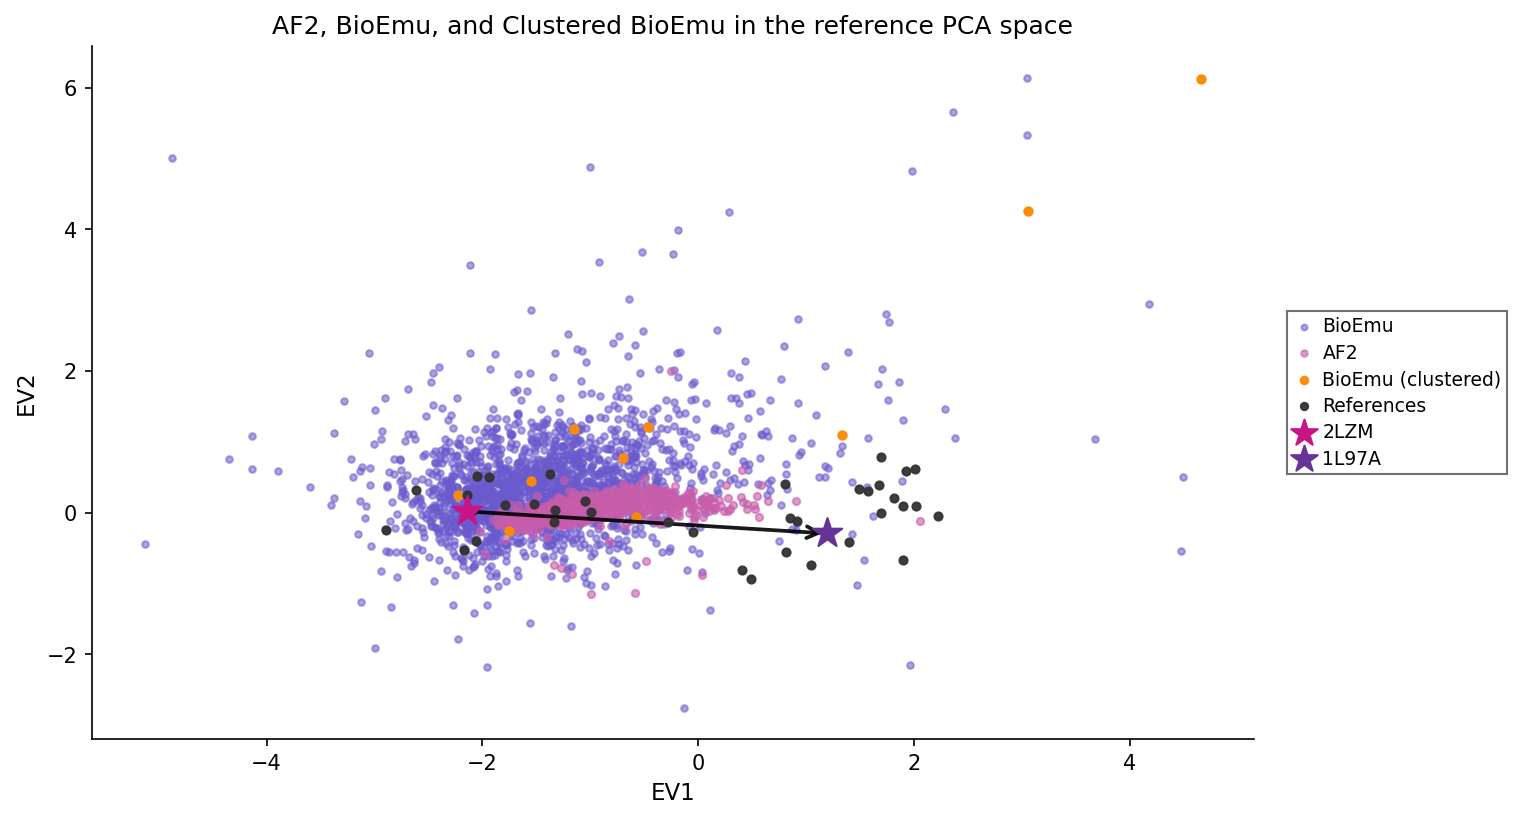

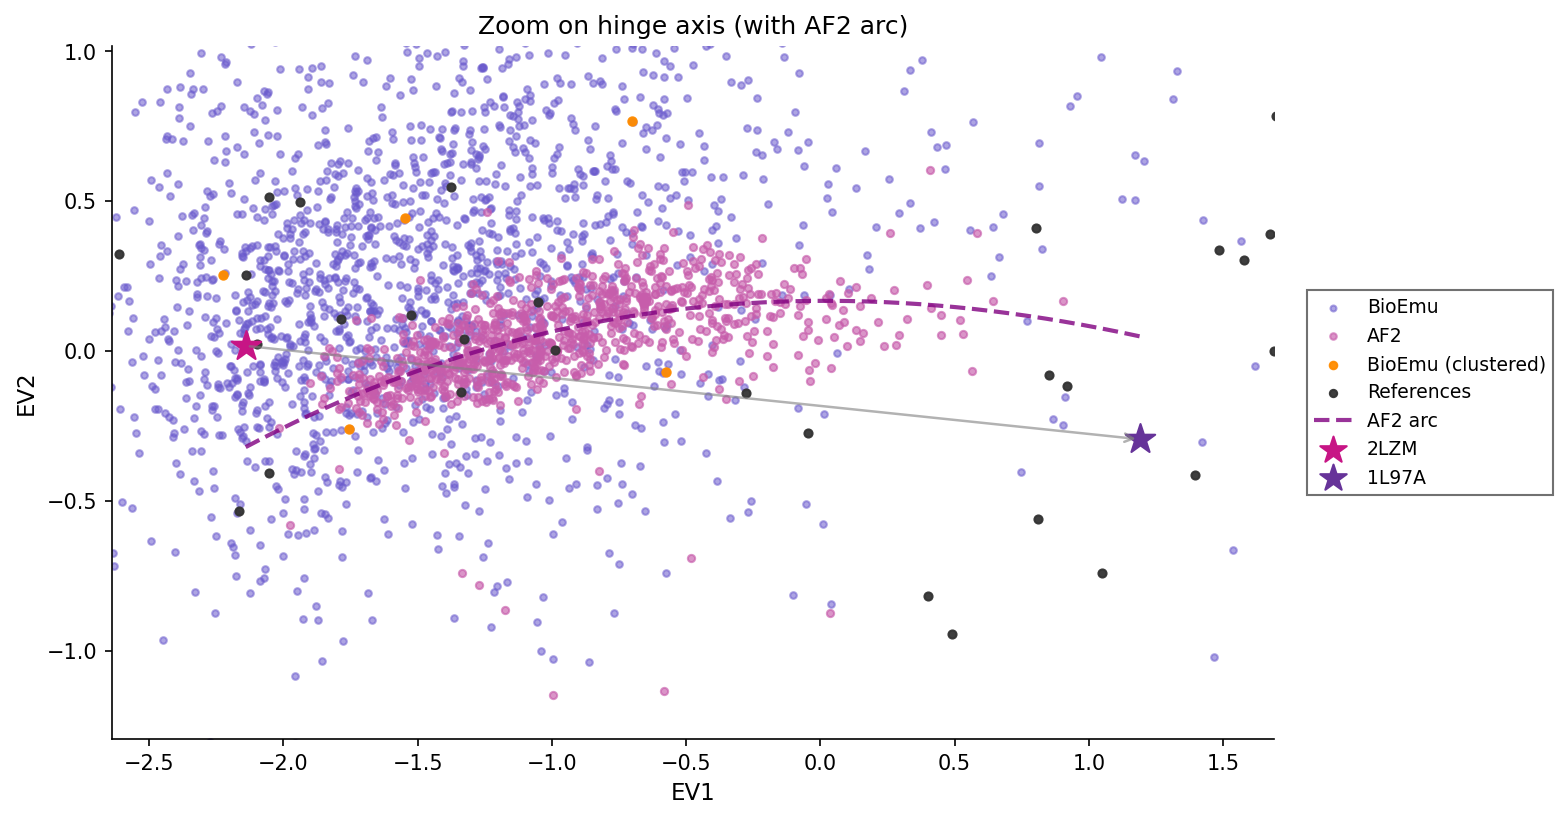


[§3.5 Outputs written to disk]
 Master nearest-neighbour table:  exports_panel3_5/nearest_neighbors_master.csv
 RMSD nearest refs:               exports_panel3_5/nearest_rmsd_refs.csv
 PCA nearest refs:                exports_panel3_5/nearest_pca_refs.csv
 PCA hull outliers:               exports_panel3_5/outliers_pca_hull.csv
 BioEmu-aligned eval:             exports_panel3_5/bioemu_aligned_eval.csv
 Table 3.4 publishable:           exports_panel3_5/table34/table_3_4_publishable.csv
 Table 3.4 appendix:              exports_panel3_5/table34/table_3_4_appendix.csv
 Figures:
  - AF2 + BioEmu overlay:         exports_panel3_5/fig_35_outliers_overlay.png
  - Extended overlay (3 methods): exports_panel3_5/fig_35_outliers_overlay_extended.png
  - Zoom hinge axis:               exports_panel3_5/fig_35B_zoom_hinge_axis.png


In [13]:
# ==============================================================
# §3.5 — Nearest neighbours, outliers, census + BioEmu eval + Table 3.4
# ==============================================================

from scipy.spatial import ConvexHull
from matplotlib.path import Path as MplPath
import matplotlib.pyplot as plt

ref_names = labels_ref["PDB"].astype(str).tolist()

# ----------------------------------------------------------------
# === PRIMARY THRESHOLDS (easy to tweak) ===
USE_RMSD_PERCENTILE = True    # False → use fixed
RMSD_PERCENTILE = 95
RMSD_FIXED = 3.3              # Å (≈ inter-ref 95th percentile)

USE_PCA_PERCENTILE = True
PCA_PERCENTILE = 95
PCA_FIXED = 2.0               # EV units

# === LITERATURE (BioEmu) CUTS ===
BIOEMU_GLOBAL_CUTOFF = 3.0   # Å for domain motions
COVERAGE_FRAC = 0.001        # 0.1% of samples
# ----------------------------------------------------------------

# --- RMSD nearest reference table ---------------------------------------------
def build_rmsd_table(X_models, method, meta_df=None):
    if X_models is None:
        return None
    R_models = reshape_coords(X_models)
    M = rmsd_to_refs(R_models, R_ref)
    model_ids = meta_df["model_id"].values if meta_df is not None else [f"{method}_{i:04d}" for i in range(M.shape[0])]
    df = pd.DataFrame(M, columns=ref_names)
    df.insert(0,"method",method)
    df.insert(0,"model_id",model_ids)
    idx_min = M.argmin(axis=1)
    df["nearest_ref_RMSD"] = M.min(axis=1)
    df["nearest_ref_name_rmsd"] = [ref_names[i] for i in idx_min]
    return df

df_rmsd_af2 = build_rmsd_table(X_af2,"AF2",df_af2)
df_rmsd_bio = build_rmsd_table(X_bio,"BioEmu",df_bio if 'df_bio' in globals() else None)
df_rmsd_clu = build_rmsd_table(X_bioc,"ClusteredBioEmu",df_bioc if 'df_bioc' in globals() else None)
df_rmsd_all = pd.concat([d for d in [df_rmsd_af2,df_rmsd_bio,df_rmsd_clu] if d is not None],ignore_index=True)
df_rmsd_all.to_csv(OUT35/"nearest_rmsd_refs.csv",index=False)

# --- PCA nearest reference table ----------------------------------------------
EV_refs = df_ref[["EV1","EV2"]].to_numpy(float)
def build_pca_table(df_models, method):
    if df_models is None or df_models.empty:
        return None
    coords = df_models[["ev1","ev2"]].to_numpy(float)
    D = cdist(coords, EV_refs, metric="euclidean")
    df = pd.DataFrame(D, columns=ref_names)
    df.insert(0,"method",method)
    df.insert(0,"model_id",df_models["model_id"].values)
    idx_min = D.argmin(axis=1)
    df["nearest_ref_PCA"] = D.min(axis=1)
    df["nearest_ref_name_pca"] = [ref_names[i] for i in idx_min]
    return df

df_pca_af2 = build_pca_table(df_af2,"AF2")
df_pca_bio = build_pca_table(df_bio,"BioEmu")
df_pca_clu = build_pca_table(df_bioc,"ClusteredBioEmu")
df_pca_all = pd.concat([d for d in [df_pca_af2,df_pca_bio,df_pca_clu] if d is not None],ignore_index=True)
df_pca_all.to_csv(OUT35/"nearest_pca_refs.csv",index=False)

# --- PCA hull outliers --------------------------------------------------------
R = df_ref[["EV1","EV2"]].to_numpy(float)
if R.shape[0] >= 3 and np.linalg.matrix_rank(R - R.mean(0)) >= 2:
    hull = ConvexHull(R); poly = R[hull.vertices]
    centroid = poly.mean(axis=0); HULL_SCALE = 1.10
    poly_scaled = centroid + HULL_SCALE * (poly - centroid)
    path_scaled = MplPath(poly_scaled)

    def hull_flags(df_models, method):
        if df_models is None or df_models.empty:
            return None
        coords = df_models[["ev1","ev2"]].to_numpy(float)
        inside = path_scaled.contains_points(coords)
        df = df_models[["model_id"]].copy()
        df["method"] = method
        df["is_outlier_pca_hull"] = ~inside
        return df

    df_hull_af2 = hull_flags(df_af2,"AF2")
    df_hull_bio = hull_flags(df_bio,"BioEmu")
    df_hull_clu = hull_flags(df_bioc,"ClusteredBioEmu")
    df_hull_all = pd.concat([d for d in [df_hull_af2,df_hull_bio,df_hull_clu] if d is not None],ignore_index=True)
    df_hull_all.to_csv(OUT35/"outliers_pca_hull.csv",index=False)
else:
    df_hull_all = pd.DataFrame()

# --- Primary thresholds for RMSD and PCA -------------------------------------
if USE_RMSD_PERCENTILE:
    rmsd_cut = np.percentile(df_rmsd_all["nearest_ref_RMSD"], RMSD_PERCENTILE)
else:
    rmsd_cut = RMSD_FIXED
if USE_PCA_PERCENTILE:
    pca_cut = np.percentile(df_pca_all["nearest_ref_PCA"], PCA_PERCENTILE)
else:
    pca_cut = PCA_FIXED
print(f"[✓] Primary RMSD cutoff = {rmsd_cut:.3f} Å  |  PCA cutoff = {pca_cut:.3f} EV units")

df_rmsd_all["is_outlier_rmsd"] = df_rmsd_all["nearest_ref_RMSD"] > rmsd_cut
df_pca_all["is_outlier_pca"]   = df_pca_all["nearest_ref_PCA"] > pca_cut

# --- Master joined table ------------------------------------------------------
master = (df_rmsd_all[["model_id","method","nearest_ref_RMSD","nearest_ref_name_rmsd","is_outlier_rmsd"]]
          .merge(df_pca_all[["model_id","nearest_ref_PCA","nearest_ref_name_pca","is_outlier_pca"]],
                 on="model_id", how="outer"))
if not df_hull_all.empty:
    master = master.merge(df_hull_all[["model_id","is_outlier_pca_hull"]], on="model_id", how="left")

# --- BioEmu-style evaluation -------------------------------------------------
def bioemu_eval(rmsd_table, method):
    df = rmsd_table.query("method == @method").copy()
    if df.empty: return None
    n = len(df)
    within = df["nearest_ref_RMSD"].values <= BIOEMU_GLOBAL_CUTOFF
    coverage = within.mean() * 100
    k = max(1,int(np.ceil(COVERAGE_FRAC*n)))
    krec = np.sort(df["nearest_ref_RMSD"].values)[:k].mean()
    return {"method":method,"n_models":n,"coverage_%":coverage,"krec_A":krec}

summary_rows = list(filter(None,[
    bioemu_eval(df_rmsd_all,"AF2"),
    bioemu_eval(df_rmsd_all,"BioEmu"),
    bioemu_eval(df_rmsd_all,"ClusteredBioEmu")
]))
df_bioemu_summary = pd.DataFrame(summary_rows)
df_bioemu_summary.to_csv(OUT35/"bioemu_aligned_eval.csv",index=False)

# --- Final flags --------------------------------------------------------------
master["is_bioemu_success"] = master["nearest_ref_RMSD"] <= BIOEMU_GLOBAL_CUTOFF
master["is_outlier_any"] = master[["is_outlier_rmsd","is_outlier_pca","is_outlier_pca_hull"]].fillna(False).any(axis=1)
master.to_csv(OUT35/"nearest_neighbors_master.csv", index=False)

# ==============================================================
# Table 3.4: Comparative statistics (publishable + appendix)
# ==============================================================

OUT354 = OUT35 / "table34"
OUT354.mkdir(exist_ok=True, parents=True)

def axis_fraction(ev1_value):
    return (ev1_value - ev1_closed) / (ev1_open - ev1_closed) * 100.0

def bootstrap_ci(values, fn=np.mean, nboot=800, alpha=0.05):
    rng = np.random.default_rng(0)
    vals = []
    if len(values) == 0: return np.nan,np.nan
    for _ in range(nboot):
        resample = rng.choice(values, size=len(values), replace=True)
        vals.append(fn(resample))
    lo, hi = np.percentile(vals,[100*alpha/2,100*(1-alpha/2)])
    return float(lo), float(hi)

rows, rows_ci = [], []

for method, df in [("AF2", df_af2), ("BioEmu", df_bio), ("ClusteredBioEmu", df_bioc)]:
    if df is None or df.empty: continue
    pts = df[["ev1","ev2"]].to_numpy()
    hull = ConvexHull(pts) if pts.shape[0] >= 3 else None
    hull_area = float(hull.volume) if hull else np.nan
    cen_ev1 = df["ev1"].mean()
    cen_frac = axis_fraction(cen_ev1)

    pca_out = master.query("method==@method")["is_outlier_pca"].mean()*100
    rmsd_out = master.query("method==@method")["is_outlier_rmsd"].mean()*100
    seed_count = int(master.query("method==@method & is_bioemu_success").shape[0])

    # Bootstraps
    hull_lo,hull_hi = bootstrap_ci(np.arange(len(pts)), fn=lambda idx: ConvexHull(pts[idx]).volume if len(np.unique(pts[idx],axis=0))>=3 else np.nan, nboot=400)
    cen_lo,cen_hi = bootstrap_ci(df["ev1"].values, np.mean)
    cen_lo,cen_hi = axis_fraction(cen_lo), axis_fraction(cen_hi)
    pca_flags = master.query("method==@method")["is_outlier_pca"].astype(int).values
    pca_lo,pca_hi = bootstrap_ci(pca_flags, np.mean); pca_lo,pca_hi = pca_lo*100,pca_hi*100
    rmsd_flags = master.query("method==@method")["is_outlier_rmsd"].astype(int).values
    rmsd_lo,rmsd_hi = bootstrap_ci(rmsd_flags, np.mean); rmsd_lo,rmsd_hi = rmsd_lo*100,rmsd_hi*100

    rows.append({"method":method,"hull_area":hull_area,"centroid_ev1_percent":cen_frac,
                 "pca_outlier_percent":pca_out,"rmsd_outlier_percent":rmsd_out,"seed_count":seed_count})
    rows_ci.append({"method":method,"hull_area":hull_area,"hull_area_CI_lo":hull_lo,"hull_area_CI_hi":hull_hi,
                    "centroid_ev1_percent":cen_frac,"centroid_ev1_percent_CI_lo":cen_lo,"centroid_ev1_percent_CI_hi":cen_hi,
                    "pca_outlier_percent":pca_out,"pca_outlier_percent_CI_lo":pca_lo,"pca_outlier_percent_CI_hi":pca_hi,
                    "rmsd_outlier_percent":rmsd_out,"rmsd_outlier_percent_CI_lo":rmsd_lo,"rmsd_outlier_percent_CI_hi":rmsd_hi,
                    "seed_count":seed_count})

pub = pd.DataFrame(rows)
appx = pd.DataFrame(rows_ci)

# Format publishable CSV with ±
def format_pm(val, lo, hi, ndp=2):
    err = (hi-lo)/2
    return f"{val:.{ndp}f} ± {err:.{ndp}f}"

pub_fmt = []
for r,a in zip(rows,rows_ci):
    pub_fmt.append({
        "method": r["method"],
        "hull_area": format_pm(r["hull_area"],a["hull_area_CI_lo"],a["hull_area_CI_hi"]),
        "centroid_ev1_percent": format_pm(r["centroid_ev1_percent"],a["centroid_ev1_percent_CI_lo"],a["centroid_ev1_percent_CI_hi"],ndp=1),
        "pca_outlier_percent": format_pm(r["pca_outlier_percent"],a["pca_outlier_percent_CI_lo"],a["pca_outlier_percent_CI_hi"]),
        "rmsd_outlier_percent": format_pm(r["rmsd_outlier_percent"],a["rmsd_outlier_percent_CI_lo"],a["rmsd_outlier_percent_CI_hi"]),
        "seed_count": r["seed_count"]
    })

pub_fmt = pd.DataFrame(pub_fmt)

pub_fmt.to_csv(OUT354/"table_3_4_publishable.csv", index=False)
appx.to_csv(OUT354/"table_3_4_appendix.csv", index=False)

# ==============================================================
# Figures: overlay plots
# ==============================================================

coords_all = pd.concat([
    df_af2[["model_id","ev1","ev2"]].assign(method="AF2"),
    df_bio[["model_id","ev1","ev2"]].assign(method="BioEmu"),
    df_bioc[["model_id","ev1","ev2"]].assign(method="ClusteredBioEmu")
], ignore_index=True)

plot_df = master.merge(coords_all, on=["model_id","method"], how="left")

# === Single overlay: BioEmu + AF2 + Clustered + References (in that order) ===
from matplotlib.patches import Polygon

# Colors (same palette we’ve been using)
COL_REF       = "#333333"   # reference points
COL_AF2       = "#C75DAB"   # AF2
COL_BIO       = "#6A5ACD"   # BioEmu
COL_BIO_CLU   = "#FF8C00"   # BioEmu (clustered) = orange
COL_CLOSED    = "mediumvioletred"
COL_OPEN      = "rebeccapurple"

STAR_KW  = dict(marker="*", s=220, zorder=6)
ARROW_KW = dict(arrowstyle="->", color="black", lw=1.8, mutation_scale=14, alpha=0.9)

# Create fig dir if not present
fig, ax = plt.subplots(figsize=(10, 6))

# 1) BioEmu (background)
if 'df_bio' in globals() and df_bio is not None and len(df_bio):
    ax.scatter(df_bio["ev1"], df_bio["ev2"], s=10, c=COL_BIO, alpha=0.55, label="BioEmu", zorder=1)

# 2) AF2 on top of BioEmu
if 'df_af2' in globals() and df_af2 is not None and len(df_af2):
    ax.scatter(df_af2["ev1"], df_af2["ev2"], s=12, c=COL_AF2, alpha=0.60, label="AF2", zorder=2)

# 3) Clustered BioEmu (prominent; alpha 0.95)
if 'df_bioc' in globals() and df_bioc is not None and len(df_bioc):
    ax.scatter(df_bioc["ev1"], df_bioc["ev2"], s=16, c=COL_BIO_CLU, alpha=0.95, label="BioEmu (clustered)", zorder=3)

# 4) References on top (alpha 0.95)
ax.scatter(df_ref["EV1"], df_ref["EV2"], s=15, c=COL_REF, alpha=0.95, label="References", zorder=4)

# Stars + hinge arrow last
ax.scatter([df_ref.loc[ix_2lzm, "EV1"]], [df_ref.loc[ix_2lzm, "EV2"]], c=COL_CLOSED, label="2LZM", **STAR_KW)
ax.scatter([df_ref.loc[ix_1l97a, "EV1"]], [df_ref.loc[ix_1l97a, "EV2"]], c=COL_OPEN, label="1L97A", **STAR_KW)
ax.annotate("",
            xy=(df_ref.loc[ix_1l97a,"EV1"], df_ref.loc[ix_1l97a,"EV2"]),
            xytext=(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_2lzm,"EV2"]),
            arrowprops=ARROW_KW)

ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
ax.set_title("AF2, BioEmu, and Clustered BioEmu in the reference PCA space")

# Legend OUTSIDE (right), boxed, compact; dedup entries
h, l = ax.get_legend_handles_labels()
uniq = dict(zip(l, h))
ax.legend([uniq[k] for k in uniq], list(uniq.keys()),
          frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
          fontsize=9, markerscale=0.9, handlelength=1.2, handletextpad=0.4,
          borderpad=0.3, labelspacing=0.4,
          loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.savefig(OUT35/"fig_35_overlay_single.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT35/"fig_35_overlay_single.pdf", dpi=300, bbox_inches="tight")
plt.show()


# === Zoomed-in hinge axis view with AF2 arc + faint arrow ===
fig, ax = plt.subplots(figsize=(10,6))

# Plot BioEmu, AF2, Clustered, References
if df_bio is not None and len(df_bio):
    ax.scatter(df_bio["ev1"], df_bio["ev2"], s=10, c=COL_BIO, alpha=0.55, label="BioEmu", zorder=1)
if df_af2 is not None and len(df_af2):
    ax.scatter(df_af2["ev1"], df_af2["ev2"], s=12, c=COL_AF2, alpha=0.65, label="AF2", zorder=2)
if df_bioc is not None and len(df_bioc):
    ax.scatter(df_bioc["ev1"], df_bioc["ev2"], s=16, c=COL_BIO_CLU, alpha=0.95, label="BioEmu (clustered)", zorder=3)

ax.scatter(df_ref["EV1"], df_ref["EV2"], s=15, c=COL_REF, alpha=0.95, label="References", zorder=4)

# AF2 arc line
x_grid = np.linspace(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_1l97a,"EV1"], 400)
ax.plot(x_grid, ev2_center(x_grid), "--", c="purple", lw=2.0, alpha=0.8, zorder=5, label="AF2 arc")

# Stars
ax.scatter([df_ref.loc[ix_2lzm,"EV1"]],[df_ref.loc[ix_2lzm,"EV2"]],
           c=COL_CLOSED, label="2LZM", **STAR_KW)
ax.scatter([df_ref.loc[ix_1l97a,"EV1"]],[df_ref.loc[ix_1l97a,"EV2"]],
           c=COL_OPEN, label="1L97A", **STAR_KW)

# Faint arrow 2LZM→1L97A
ax.annotate("",
    xy=(df_ref.loc[ix_1l97a,"EV1"], df_ref.loc[ix_1l97a,"EV2"]),
    xytext=(df_ref.loc[ix_2lzm,"EV1"], df_ref.loc[ix_2lzm,"EV2"]),
    arrowprops=dict(arrowstyle="->", lw=1.2, color="0.5", alpha=0.6),
    zorder=6
)

# Zoom limits around hinge axis
xlo, xhi = df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"].min(), df_ref.loc[[ix_2lzm, ix_1l97a], "EV1"].max()
ylo, yhi = df_ref.loc[[ix_2lzm, ix_1l97a], "EV2"].min(), df_ref.loc[[ix_2lzm, ix_1l97a], "EV2"].max()
ax.set_xlim(xlo - 0.15*(xhi-xlo), xhi + 0.15*(xhi-xlo))
ax.set_ylim(ylo - 1.0, yhi + 1.0)

ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
ax.set_title("Zoom on hinge axis (with AF2 arc)")

# Legend outside right
h, l = ax.get_legend_handles_labels()
uniq = dict(zip(l, h))
ax.legend([uniq[k] for k in uniq], list(uniq.keys()),
          frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
          fontsize=9, markerscale=0.9,
          loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.savefig(OUT35/"fig_35_overlay_zoom.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT35/"fig_35_overlay_zoom.pdf", dpi=300, bbox_inches="tight")
plt.show()


# ==============================================================
# Outputs summary
# ==============================================================

print("\n[§3.5 Outputs written to disk]")
print(" Master nearest-neighbour table: ", OUT35/"nearest_neighbors_master.csv")
print(" RMSD nearest refs:              ", OUT35/"nearest_rmsd_refs.csv")
print(" PCA nearest refs:               ", OUT35/"nearest_pca_refs.csv")
print(" PCA hull outliers:              ", OUT35/"outliers_pca_hull.csv")
print(" BioEmu-aligned eval:            ", OUT35/"bioemu_aligned_eval.csv")
print(" Table 3.4 publishable:          ", OUT354/"table_3_4_publishable.csv")
print(" Table 3.4 appendix:             ", OUT354/"table_3_4_appendix.csv")
print(" Figures:")
print("  - AF2 + BioEmu overlay:        ", OUT35/"fig_35_outliers_overlay.png")
print("  - Extended overlay (3 methods):", OUT35/"fig_35_outliers_overlay_extended.png")
print("  - Zoom hinge axis:              ", OUT35/"fig_35B_zoom_hinge_axis.png")


[§3.6] Closed-cluster EV1 centroid = -1.751
[§3.6] RMSD-to-open threshold (top 5%): 0.133 Å
[§3.6] PCA-distance-to-open threshold (top 5%): 1.481 EV units
[§3.6] Seeds retained: 65   |   Candidates after Steps 1&2: 112

[§3.6 Outputs]
 Seeds (full list):            exports_panel3_6/seed_candidates_full.csv
 Table 3.11 (publishable):     exports_panel3_6/table_3_11_publishable.csv
 Table 3.11 (appendix):        exports_panel3_6/table_3_11_appendix.csv
 Figures:
  - Filtering schematic:       exports_panel3_6/fig_3e_filtering_schematic.png
  - Final seed overlay:        exports_panel3_6/fig_3f_final_seed_overlay.png


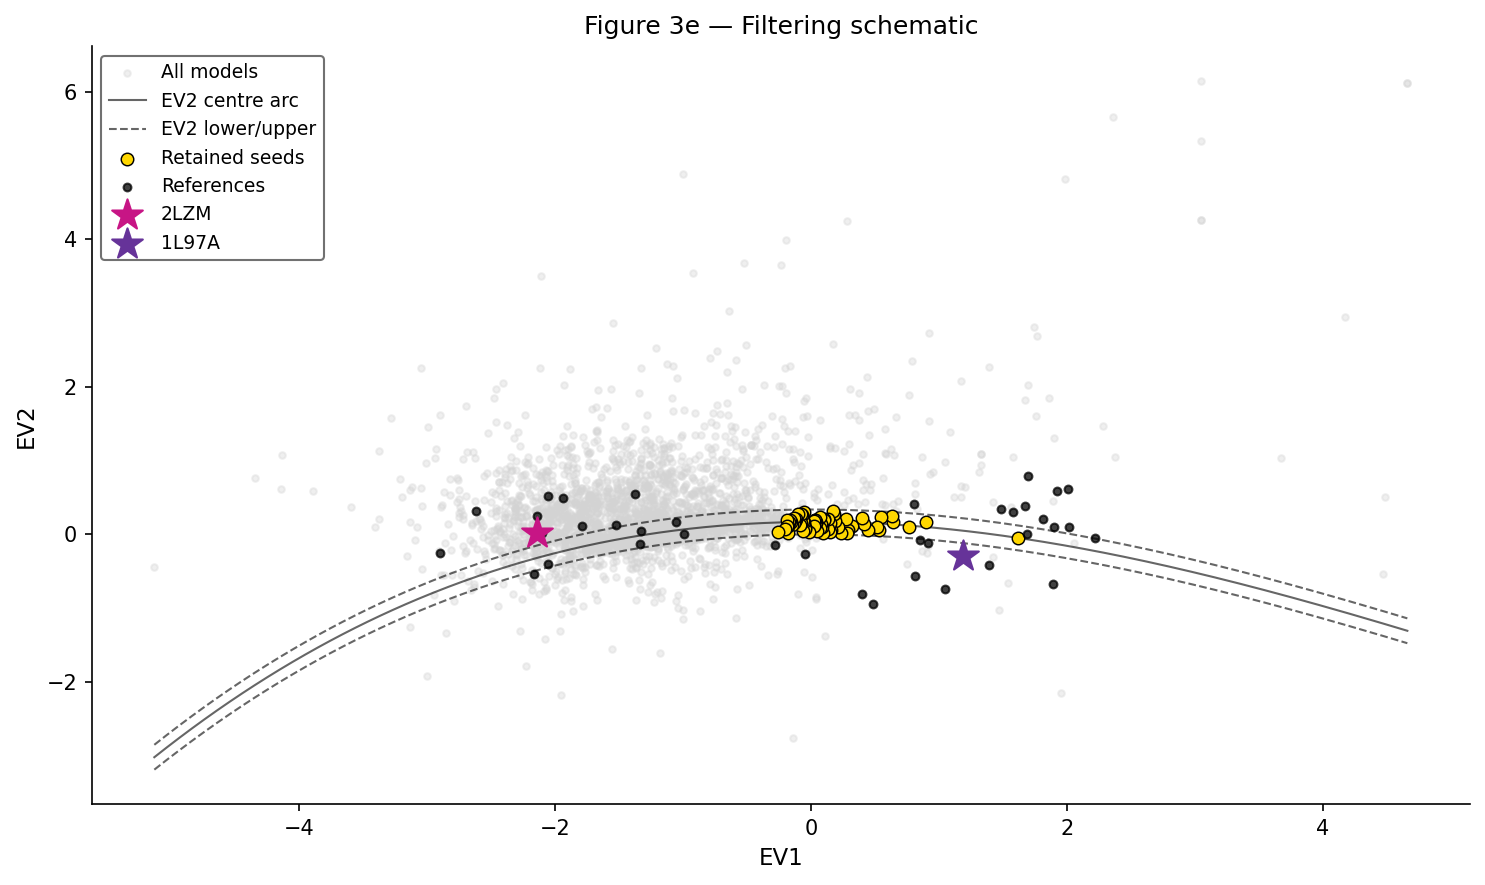

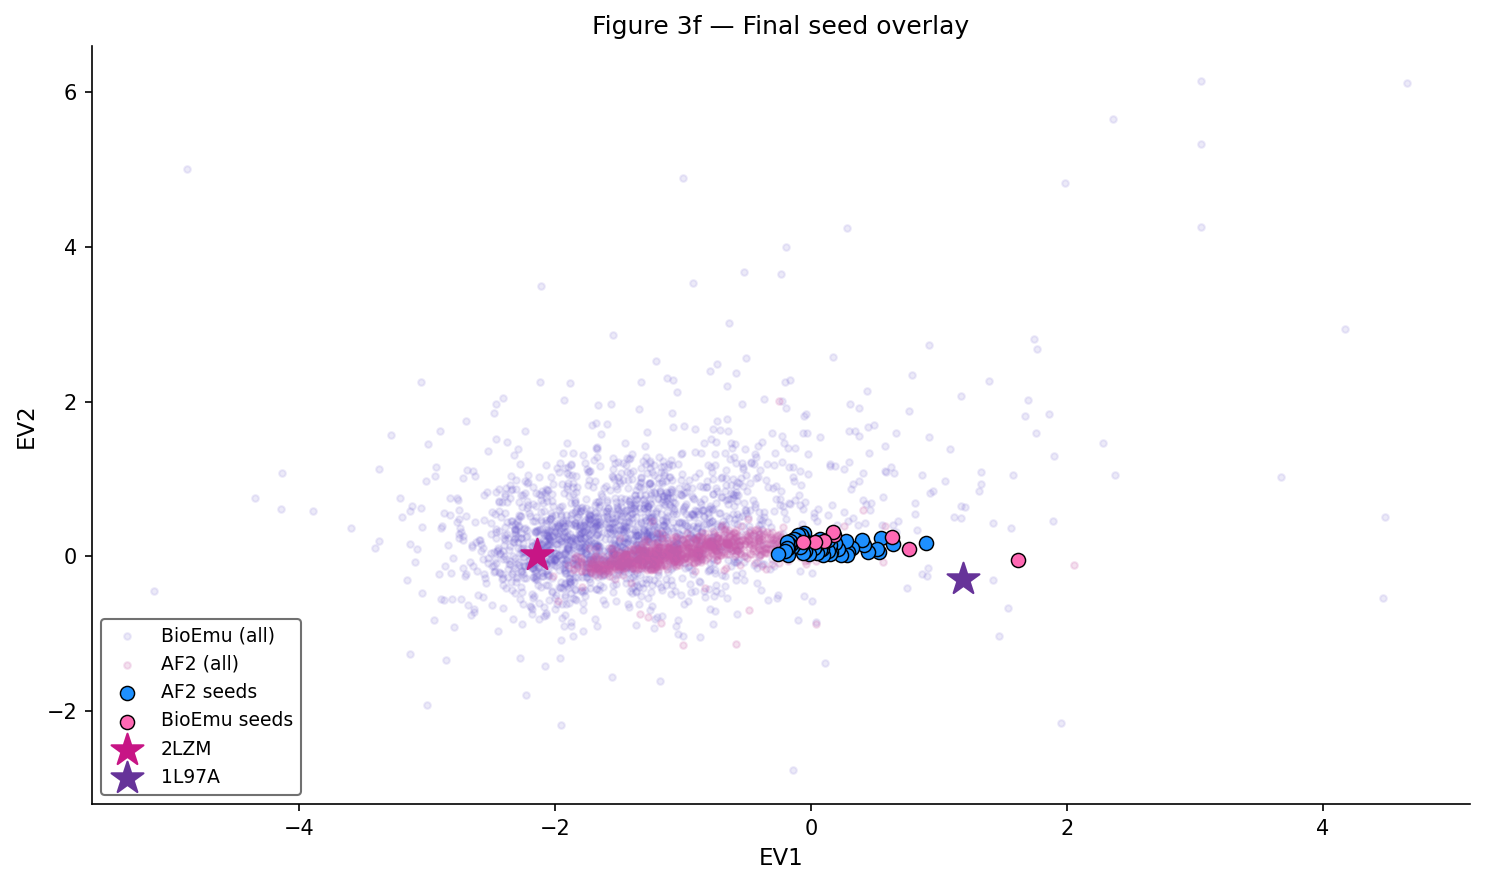

In [14]:
# ==============================================================
# §3.6 — Seed selection for MD (final, 4-step priority)
# ==============================================================


# --- Assumptions from earlier sections (already defined) ----------------------
# df_rmsd_all : per-model RMSD to every reference + nearest_ref_RMSD (§3.5)
# df_pca_all  : per-model PCA distance to every reference + nearest_ref_PCA (§3.5)
# df_ref      : references with EV1, EV2 and ix_2lzm / ix_1l97a anchors (from §3.2)
# ev2_center, ev2_lo_fun, ev2_hi_fun : spline envelope functions (from §3.6 prelude)
# df_af2, df_bio : model EV coordinates; coords_all := AF2 ∪ BioEmu with ev1,ev2
# ref_names, ix_1l97a : map to open reference column in the RMSD/PCA tables

assert "df_rmsd_all" in globals() and "df_pca_all" in globals(), "Need §3.5 outputs in memory."
assert "coords_all" in globals(), "Need coords_all = AF2∪BioEmu with ev1/ev2."
assert "ix_1l97a" in globals() and "ref_names" in globals(), "Need open reference index/name."
open_ref_name = ref_names[ix_1l97a]

# --- Step 0: helper — closed-cluster centroid along EV1 -----------------------
# Define the closed cluster via k-means on the references and take the lower-EV1 centroid.
from sklearn.cluster import KMeans
k2 = KMeans(n_clusters=2, random_state=0).fit(df_ref[["EV1","EV2"]].to_numpy(float))
df_ref_k = df_ref.copy(); df_ref_k["cluster"] = k2.labels_
closed_cluster = df_ref_k.groupby("cluster")["EV1"].mean().idxmin()
closed_cluster_ev1 = float(df_ref_k.loc[df_ref_k["cluster"]==closed_cluster, "EV1"].mean())

print(f"[§3.6] Closed-cluster EV1 centroid = {closed_cluster_ev1:.3f}")

# --- Step 1: top 5 percent closest to 1L97A in RMSD space --------------------
TOP_FRAC = 0.05  # top 5%
rmsd_to_open = df_rmsd_all[[ "model_id", "method", open_ref_name ]].rename(
    columns={open_ref_name: "rmsd_to_open_A"})
rmsd_thresh = np.quantile(rmsd_to_open["rmsd_to_open_A"].to_numpy(float), TOP_FRAC)
cand_rmsd = rmsd_to_open[rmsd_to_open["rmsd_to_open_A"] <= rmsd_thresh].copy()

print(f"[§3.6] RMSD-to-open threshold (top {int(TOP_FRAC*100)}%): {rmsd_thresh:.3f} Å")

# --- Step 2: top 5 percent closest to 1L97A in PCA space ---------------------
pca_to_open = df_pca_all[[ "model_id", "method", open_ref_name ]].rename(
    columns={open_ref_name: "pca_dist_to_open"})
pca_thresh = np.quantile(pca_to_open["pca_dist_to_open"].to_numpy(float), TOP_FRAC)
cand_pca = pca_to_open[pca_to_open["pca_dist_to_open"] <= pca_thresh].copy()

print(f"[§3.6] PCA-distance-to-open threshold (top {int(TOP_FRAC*100)}%): {pca_thresh:.3f} EV units")

# --- Step 3: intersect (must satisfy both Step 1 and Step 2) -----------------
candidates = cand_rmsd.merge(cand_pca[["model_id","pca_dist_to_open"]],
                             on="model_id", how="inner")
# attach EV coordinates and per-model nearest-ref metrics for later reporting
candidates = (candidates
              .merge(coords_all, on=["model_id","method"], how="left")
              .merge(df_rmsd_all[["model_id","nearest_ref_RMSD"]], on="model_id", how="left")
              .merge(df_pca_all[["model_id","nearest_ref_PCA"]],   on="model_id", how="left"))

# --- Step 4a: EV1 boundary (must be displaced beyond closed centroid) --------
candidates["ok_ev1"] = candidates["ev1"] >= closed_cluster_ev1

# --- Step 4b: EV2 corridor (spline envelope) ---------------------------------
ev2_lo_at_x = ev2_lo_fun(candidates["ev1"].to_numpy(float))
ev2_hi_at_x = ev2_hi_fun(candidates["ev1"].to_numpy(float))
candidates["ok_ev2"] = (candidates["ev2"].to_numpy(float) >= ev2_lo_at_x) & \
                       (candidates["ev2"].to_numpy(float) <= ev2_hi_at_x)

# --- Final seeds: satisfy Steps 1,2 and EV1+EV2 gating ------------------------
candidates["is_seed"] = candidates["ok_ev1"] & candidates["ok_ev2"]
seeds = candidates[candidates["is_seed"]].copy()

# optional: bring U_level if available
if "U_level" in df_af2.columns:
    seeds = seeds.merge(df_af2[["model_id","U_level"]], on="model_id", how="left")

# rank for practical usefulness: EV1 descending, then RMSD-to-open ascending
seeds["rank_ev1_desc"] = (-seeds["ev1"]).rank(method="first")
seeds["rank_rmsd_open"] = seeds["rmsd_to_open_A"].rank(method="first")
seeds = seeds.sort_values(["ev1", "rmsd_to_open_A"], ascending=[False, True]).reset_index(drop=True)
seeds.insert(0, "rank_overall", np.arange(1, len(seeds)+1))

# persist full list
seeds.to_csv(OUT36/"seed_candidates_full.csv", index=False)
print(f"[§3.6] Seeds retained: {len(seeds)}   |   Candidates after Steps 1&2: {len(candidates)}")

# ==============================================================
# Figures
# ==============================================================

# Figure 3e — Filtering schematic (grey excluded, seeds highlighted)
fig, ax = plt.subplots(figsize=(10,6))

# all models faint
ax.scatter(coords_all["ev1"], coords_all["ev2"], s=10, c="lightgrey", alpha=0.35, label="All models")

# EV2 envelope
x_grid = np.linspace(coords_all["ev1"].min(), coords_all["ev1"].max(), 500)
ax.plot(x_grid, ev2_center(x_grid), "-",  c="black", lw=1.0, alpha=0.6, label="EV2 centre arc")
ax.plot(x_grid, ev2_lo_fun(x_grid), "--", c="black", lw=1.0, alpha=0.6, label="EV2 lower/upper")
ax.plot(x_grid, ev2_hi_fun(x_grid), "--", c="black", lw=1.0, alpha=0.6)

# highlight seeds
if len(seeds):
    ax.scatter(seeds["ev1"], seeds["ev2"], s=36, c="gold", edgecolor="black", linewidth=0.7, label="Retained seeds", zorder=3)

# anchors last
ax.scatter(df_ref["EV1"], df_ref["EV2"], c="black", s=14, alpha=0.75, label="References", zorder=4)
ax.scatter([df_ref.loc[ix_2lzm,"EV1"]],[df_ref.loc[ix_2lzm,"EV2"]],
           c="mediumvioletred", marker="*", s=240, label="2LZM", zorder=5)
ax.scatter([df_ref.loc[ix_1l97a,"EV1"]],[df_ref.loc[ix_1l97a,"EV2"]],
           c="rebeccapurple", marker="*", s=240, label="1L97A", zorder=5)

ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
ax.set_title("Figure 3e — Filtering schematic")
ax.legend(frameon=True, facecolor="white", edgecolor="0.3", fontsize=9)
fig.tight_layout()
fig.savefig(OUT36/"fig_3e_filtering_schematic.png", dpi=300, bbox_inches="tight")

# Figure 3f — Final seed overlay (AF2 blue, BioEmu pink)
fig, ax = plt.subplots(figsize=(10,6))

# background clouds
ax.scatter(df_bio["ev1"], df_bio["ev2"], s=10, c="#6A5ACD", alpha=0.12, label="BioEmu (all)", zorder=1)
ax.scatter(df_af2["ev1"], df_af2["ev2"], s=10, c="#C75DAB", alpha=0.18, label="AF2 (all)",    zorder=2)

# seeds by method
m_af2 = seeds["method"].eq("AF2")
m_bio = seeds["method"].eq("BioEmu")
if m_af2.any():
    ax.scatter(seeds.loc[m_af2,"ev1"], seeds.loc[m_af2,"ev2"], s=46, c="dodgerblue",
               edgecolor="black", linewidth=0.7, label="AF2 seeds", zorder=4)
if m_bio.any():
    ax.scatter(seeds.loc[m_bio,"ev1"], seeds.loc[m_bio,"ev2"], s=46, c="hotpink",
               edgecolor="black", linewidth=0.7, label="BioEmu seeds", zorder=4)

# anchors on top
ax.scatter([df_ref.loc[ix_2lzm,"EV1"]],[df_ref.loc[ix_2lzm,"EV2"]],
           c="mediumvioletred", marker="*", s=260, label="2LZM", zorder=5)
ax.scatter([df_ref.loc[ix_1l97a,"EV1"]],[df_ref.loc[ix_1l97a,"EV2"]],
           c="rebeccapurple", marker="*", s=260, label="1L97A", zorder=5)

ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
ax.set_title("Figure 3f — Final seed overlay")
ax.legend(frameon=True, facecolor="white", edgecolor="0.3", fontsize=9)
fig.tight_layout()
fig.savefig(OUT36/"fig_3f_final_seed_overlay.png", dpi=300, bbox_inches="tight")

# ==============================================================
# Tables — Table 3.11 (publishable + appendix)
# ==============================================================

# Add U_level if available (for grouping); otherwise fill with "NA"
if "U_level" not in seeds.columns:
    seeds["U_level"] = pd.NA

# helper: bootstrap CI of the mean
def _ci_mean(arr, n_boot=800, seed=0):
    rng = np.random.default_rng(seed)
    if len(arr) == 0:
        return np.nan, np.nan
    boots = [np.mean(rng.choice(arr, size=len(arr), replace=True)) for _ in range(n_boot)]
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return float(lo), float(hi)

rows = []
for (method, u), g in seeds.groupby(["method","U_level"], dropna=False):
    ev1_vals   = g["ev1"].to_numpy(float)
    rmsd_open  = g["rmsd_to_open_A"].to_numpy(float)
    n = len(g)
    if n == 0: 
        continue
    ev1_mean = float(ev1_vals.mean());      ev1_lo, ev1_hi = _ci_mean(ev1_vals)
    rmo_mean = float(rmsd_open.mean());     rmo_lo, rmo_hi = _ci_mean(rmsd_open)
    rows.append({
        "method": method,
        "U_depth": (u if pd.notna(u) else ""),
        "n_seeds": n,
        "ev1_mean": ev1_mean, "ev1_ci_lo": ev1_lo, "ev1_ci_hi": ev1_hi,
        "rmsd_to_1L97A_mean_A": rmo_mean, "rmsd_to_1L97A_ci_lo_A": rmo_lo, "rmsd_to_1L97A_ci_hi_A": rmo_hi
    })

table_311_appendix = pd.DataFrame(rows).sort_values(["method","U_depth"])
table_311_appendix.to_csv(OUT36/"table_3_11_appendix.csv", index=False)

# publishable: compact ± format
def _pm(val, lo, hi, ndp=2): 
    return f"{val:.{ndp}f} ± {(hi-lo)/2:.{ndp}f}"

table_311_publishable = pd.DataFrame({
    "Method": table_311_appendix["method"],
    "U-depth": table_311_appendix["U_depth"],
    "n_seeds": table_311_appendix["n_seeds"],
    "EV1 coordinate": [
        _pm(v, lo, hi, ndp=2) for v,lo,hi in zip(table_311_appendix["ev1_mean"],
                                                  table_311_appendix["ev1_ci_lo"],
                                                  table_311_appendix["ev1_ci_hi"])
    ],
    "RMSD to 1L97A (Å)": [
        _pm(v, lo, hi, ndp=2) for v,lo,hi in zip(table_311_appendix["rmsd_to_1L97A_mean_A"],
                                                  table_311_appendix["rmsd_to_1L97A_ci_lo_A"],
                                                  table_311_appendix["rmsd_to_1L97A_ci_hi_A"])
    ],
})
table_311_publishable.to_csv(OUT36/"table_3_11_publishable.csv", index=False)

# ==============================================================
# Final logging
# ==============================================================

print("\n[§3.6 Outputs]")
print(" Seeds (full list):           ", OUT36/"seed_candidates_full.csv")
print(" Table 3.11 (publishable):    ", OUT36/"table_3_11_publishable.csv")
print(" Table 3.11 (appendix):       ", OUT36/"table_3_11_appendix.csv")
print(" Figures:")
print("  - Filtering schematic:      ", OUT36/"fig_3e_filtering_schematic.png")
print("  - Final seed overlay:       ", OUT36/"fig_3f_final_seed_overlay.png")


In [15]:
# =========================
# §3.8 — Projection Density, Subspace Overlap (RMSIP), Cluster Separation
#   Outputs (OUT38):
#     - 3_8_density_publishable.csv / 3_8_density_appendix.csv
#     - 3_8_clusters_publishable.csv / 3_8_clusters_appendix.csv
#     - 3_8_rmsip_publishable.csv
#     - density_*.png/.pdf   (EV1×EV2 heatmaps per dataset)
# =========================
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------------
# I/O + Preconditions
# -------------------------
OUT38 = Path(globals().get("OUT38", "exports_panel3_8")); OUT38.mkdir(parents=True, exist_ok=True)
need = ["df_ref", "df_af2", "df_bio"]
for v in need:
    assert v in globals(), f"[§3.8] Missing `{v}`."

def _evcols(df):
    """Return the two column names for EV coordinates in this DF."""
    cols = set(df.columns)
    if {"EV1","EV2"}.issubset(cols): return ("EV1","EV2")
    if {"ev1","ev2"}.issubset(cols): return ("ev1","ev2")
    # try case-insensitive
    low = {c.lower(): c for c in df.columns}
    if "ev1" in low and "ev2" in low:
        return (low["ev1"], low["ev2"])
    raise AssertionError("DataFrame missing EV columns (expected EV1/EV2 or ev1/ev2).")

# Soft checks (now tolerant to either case)
_ = _evcols(df_ref)
_ = _evcols(df_af2)
_ = _evcols(df_bio)

HAS_BIOC = ("df_bioc" in globals() and isinstance(df_bioc, pd.DataFrame) and not df_bioc.empty)

# -------------------------
# Config
# -------------------------
RNG_SEED = 0
K_RANGE = range(2, 9)         # candidate k for k-means
SAMPLE_CAP_SIL = 6000         # cap points when computing silhouette (speed)
GRID_N = 80                   # grid resolution for density (EV1×EV2)
CLOSE_OPEN_RADIUS_FRAC = 0.10 # radius = 10% of EV box diagonal for mass-near-anchors
DPI_SAVE = 300
FIGSIZE = (10, 6)

# Group labels for AF2
def _u_to_num(u):
    m = re.search(r"U(\d+)", str(u))
    return int(m.group(1)) if m else np.nan

AF2_GROUPS = [
    ("AF2 U10–U18 (very shallow)", 10, 18),
    ("AF2 U20–U28 (intermediate)", 20, 28),
    ("AF2 U30–U150 (deep)",        30, 150),
]

# -------------------------
# Helpers
# -------------------------
def _safe_hull_area(P):
    P = np.asarray(P, float)
    if P.shape[0] < 3:
        return np.nan
    try:
        return float(ConvexHull(P).volume)
    except Exception:
        return np.nan

def _bounds_with_margin(all_pts, margin=0.05):
    x = all_pts[:,0]; y = all_pts[:,1]
    xmin, xmax = float(np.nanmin(x)), float(np.nanmax(x))
    ymin, ymax = float(np.nanmin(y)), float(np.nanmax(y))
    dx, dy = xmax - xmin, ymax - ymin
    return xmin - margin*dx, xmax + margin*dx, ymin - margin*dy, ymax + margin*dy

def _entropy_peakiness(Z):
    """Z is counts on grid; returns Shannon entropy (bits) and peak/median+."""
    Z = np.asarray(Z, float)
    total = Z.sum()
    if total <= 0:
        return np.nan, np.nan
    p = Z / total
    p_nz = p[p > 0]
    H = -np.sum(p_nz * np.log2(p_nz))
    # peakiness = max density / median of nonzero densities
    med = np.median(p_nz)
    peak = p.max()
    ratio = float(peak / med) if med > 0 else np.nan
    return float(H), ratio

def _mass_near(pt, points, radius):
    """Fraction (%) of points within Euclidean distance <= radius from pt."""
    if points.shape[0] == 0:
        return np.nan
    d = np.linalg.norm(points - pt[None,:], axis=1)
    return float((d <= radius).mean() * 100.0)

def _kmeans_auto(X, k_range=K_RANGE, rng=RNG_SEED, cap=SAMPLE_CAP_SIL):
    """Pick k by silhouette on a (possibly) downsampled set; return k, score, labels, centroids."""
    X = np.asarray(X, float)
    n = X.shape[0]
    if n < 3:
        return np.nan, np.nan, np.full(n, -1, int), np.empty((0,2), float)
    # downsample for silhouette if needed
    rng_local = np.random.default_rng(rng)
    if n > cap:
        idx = rng_local.integers(0, n, size=cap)
        X_sil = X[idx]
    else:
        idx = np.arange(n)
        X_sil = X
    best_k, best_score = None, -np.inf
    for k in k_range:
        if k >= n: break
        km = KMeans(n_clusters=k, n_init=10, random_state=rng).fit(X_sil)
        try:
            s = silhouette_score(X_sil, km.labels_)
        except Exception:
            s = -np.inf
        if s > best_score:
            best_k, best_score = k, s
    if best_k is None:
        return np.nan, np.nan, np.full(n, -1, int), np.empty((0,2), float)
    # fit on full data with best_k
    km_full = KMeans(n_clusters=best_k, n_init=25, random_state=rng).fit(X)
    labels = km_full.labels_
    cents = km_full.cluster_centers_
    return int(best_k), float(best_score), labels, cents

def _slug(s):
    return re.sub(r"[^A-Za-z0-9]+", "_", str(s)).strip("_")

def _dataset_rows():
    """Yield (label, DataFrame subset) for:
       - AF2 (all), AF2 per-U, AF2 grouped ranges
       - BioEmu (all), BioEmu (clustered if present)
    """
    # AF2 (all)
    yield "AF2 (all)", df_af2
    # AF2 per-U
    if "U_level" in df_af2.columns:
        for u, g in df_af2.groupby("U_level", dropna=False, sort=True):
            yield f"AF2 {u}", g
    # AF2 grouped ranges
    if "U_level" in df_af2.columns:
        af2 = df_af2.copy()
        af2["U_num"] = af2["U_level"].map(_u_to_num)
        for label, lo, hi in AF2_GROUPS:
            sub = af2[af2["U_num"].between(lo, hi, inclusive="both")]
            if not sub.empty:
                yield label, sub
    # BioEmu sets
    yield "BioEmu (all)", df_bio
    if HAS_BIOC:
        yield "BioEmu (clustered)", df_bioc

def _anchors(df_ref):
    # Return closed/open points as arrays (2LZM / 1L97A)
    EV1, EV2 = _evcols(df_ref)
    names = df_ref["PDB"].astype(str).str.lower().tolist()
    def _ix(needle):
        for i, s in enumerate(names):
            if needle in s: return i
        raise ValueError(f"Anchor containing '{needle}' not found in refs.")
    i2 = globals().get("ix_2lzm", _ix("2lzm"))
    iO = globals().get("ix_1l97a", _ix("1l97a"))
    pc = df_ref.loc[i2, [EV1,EV2]].to_numpy(float)
    po = df_ref.loc[iO, [EV1,EV2]].to_numpy(float)
    return pc, po

# -------------------------
# Precompute EV bounds and anchor radius
# -------------------------
# Global EV bounds for consistent grids
EV1r, EV2r = _evcols(df_ref)
EV1a, EV2a = _evcols(df_af2)
EV1b, EV2b = _evcols(df_bio)

all_pts = np.vstack([
    df_ref[[EV1r, EV2r]].to_numpy(float),
    df_af2[[EV1a, EV2a]].to_numpy(float),
    df_bio[[EV1b, EV2b]].to_numpy(float),
    (df_bioc[list(_evcols(df_bioc))].to_numpy(float) if HAS_BIOC else np.zeros((0, 2)))
])

# ⬇️ This returns FOUR numbers: xmin, xmax, ymin, ymax
xmin, xmax, ymin, ymax = _bounds_with_margin(all_pts, margin=0.06)

diag = np.hypot(xmax - xmin, ymax - ymin)
R_anchor = CLOSE_OPEN_RADIUS_FRAC * diag
P_closed, P_open = _anchors(df_ref)
# -------------------------
# Main loops: density + clusters per dataset
# -------------------------
dens_pub, dens_app = [], []
clus_pub, clus_app = [], []

for label, df in _dataset_rows():
    EV1d, EV2d = _evcols(df)
    pts = df[[EV1d,EV2d]].to_numpy(float)
    n = pts.shape[0]
    hull_area = _safe_hull_area(pts)
    cen = pts.mean(axis=0) if n else (np.nan, np.nan)

    # --- Density histogram on global grid
    H, xe, ye = np.histogram2d(pts[:,0], pts[:,1], bins=GRID_N, range=[[xmin,xmax],[ymin,ymax]])
    H = H.T  # for imshow orientation
    Hbits, peak_ratio = _entropy_peakiness(H)

    # Mass near anchors
    m_closed = _mass_near(P_closed, pts, R_anchor)
    m_open   = _mass_near(P_open,   pts, R_anchor)

    # Save density figure
    slug = _slug(label)
    fig, ax = plt.subplots(figsize=FIGSIZE)
    im = ax.imshow(H, origin="lower", extent=[xmin,xmax,ymin,ymax], aspect="auto")
    ax.scatter(df_ref[EV1r], df_ref[EV2r], s=16, c="k", alpha=0.7, label="References", zorder=3)
    ax.scatter([P_closed[0]],[P_closed[1]], marker="*", s=180, c="tab:red", label="2LZM", zorder=4)
    ax.scatter([P_open[0]],[P_open[1]],     marker="*", s=180, c="tab:purple", label="1L97A", zorder=4)
    ax.set_title(f"PCA density: {label}")
    ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
    ax.legend(frameon=True, facecolor="white", edgecolor="0.3")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Count per bin")
    fpng = OUT38 / f"density_{slug}.png"
    fpdf = OUT38 / f"density_{slug}.pdf"
    fig.savefig(fpng, dpi=DPI_SAVE, bbox_inches="tight")
    fig.savefig(fpdf, dpi=DPI_SAVE, bbox_inches="tight")
    plt.close(fig)

    # --- K-means cluster separation (auto-k via silhouette)
    kopt, sil, labels, cents = _kmeans_auto(pts, k_range=K_RANGE, rng=RNG_SEED, cap=SAMPLE_CAP_SIL)
    if np.isfinite(kopt):
        # cluster sizes
        sizes = pd.Series(labels).value_counts().sort_index().to_numpy()
        sz_min = int(sizes.min()) if len(sizes) else 0
        sz_med = float(np.median(sizes)) if len(sizes) else np.nan
        sz_max = int(sizes.max()) if len(sizes) else 0
        # max centroid separation
        if cents.shape[0] >= 2:
            from scipy.spatial.distance import pdist
            max_sep = float(np.max(pdist(cents)))
        else:
            max_sep = np.nan
    else:
        sz_min = sz_max = 0; sz_med = np.nan; max_sep = np.nan

    # --- Append rows (publishable + appendix)
    dens_pub.append({
        "Dataset": label,
        "n_models": n,
        "EV1–EV2 hull area (arb. units)": hull_area,
        "EV1 centroid (EV units)": float(cen[0]) if n else np.nan,
        "EV2 centroid (EV units)": float(cen[1]) if n else np.nan,
        "Density entropy (bits)": Hbits,
        "Peakiness ratio (max/median)": peak_ratio,
        "Mass near 2LZM (%)": m_closed,
        "Mass near 1L97A (%)": m_open,
    })
    dens_app.append({
        "Dataset": label,
        "n_models": n,
        "grid_bins": GRID_N,
        "bounds": f"[{xmin:.3f},{xmax:.3f}]×[{ymin:.3f},{ymax:.3f}]",
        "anchor_radius_frac": CLOSE_OPEN_RADIUS_FRAC,
        "anchor_radius_abs": R_anchor,
        "EV1–EV2 hull area (arb. units)": hull_area,
        "EV1 centroid (EV units)": float(cen[0]) if n else np.nan,
        "EV2 centroid (EV units)": float(cen[1]) if n else np.nan,
        "Density entropy (bits)": Hbits,
        "Peakiness ratio (max/median)": peak_ratio,
        "Mass near 2LZM (%)": m_closed,
        "Mass near 1L97A (%)": m_open,
        "density_png": str(fpng.name),
        "density_pdf": str(fpdf.name),
    })
    clus_pub.append({
        "Dataset": label,
        "n_models": n,
        "kmeans_opt_k": kopt if np.isfinite(kopt) else np.nan,
        "silhouette_opt_k": sil if np.isfinite(sil) else np.nan,
        "cluster_size_min": sz_min,
        "cluster_size_median": sz_med,
        "cluster_size_max": sz_max,
        "max_centroid_separation (EV units)": max_sep,
    })
    clus_app.append({
        "Dataset": label,
        "n_models": n,
        "kmeans_opt_k": kopt if np.isfinite(kopt) else np.nan,
        "silhouette_opt_k": sil if np.isfinite(sil) else np.nan,
        "cluster_size_min": sz_min,
        "cluster_size_median": sz_med,
        "cluster_size_max": sz_max,
        "max_centroid_separation (EV units)": max_sep,
        "grid_bins": GRID_N,
        "bounds": f"[{xmin:.3f},{xmax:.3f}]×[{ymin:.3f},{ymax:.3f}]",
    })

# -------------------------
# Subspace Overlap (RMSIP, k=2)
# -------------------------
def _rmsip(U, V, k=2):
    """RMSIP between subspaces spanned by first k columns of U, V (columns orthonormal)."""
    U = np.asarray(U, float)[:, :k]
    V = np.asarray(V, float)[:, :k]
    # Orthonormalize via SVD for safety
    U,_ ,_ = np.linalg.svd(U, full_matrices=False)
    V,_ ,_ = np.linalg.svd(V, full_matrices=False)
    C = U[:,:k].T @ V[:,:k]
    return float(np.sqrt(np.sum(C**2) / k))

def _eig_vecs(pts, k=2):
    """Top-k eigenvectors of 2D covariance of points (EV1,EV2)."""
    X = np.asarray(pts, float)
    if X.shape[0] < 2:
        return np.eye(2)[:,:k]
    Xc = X - X.mean(axis=0, keepdims=True)
    C = np.cov(Xc.T)
    vals, vecs = np.linalg.eigh(C)
    idx = np.argsort(vals)[::-1]
    return vecs[:, idx[:k]]

# Prepare datasets for RMSIP pairs (AF2 vs BioEmu)
pairs = []

# AF2 (all) vs BioEmu (all)
pairs.append(("AF2 (all)", "BioEmu (all)",
              df_af2[list(_evcols(df_af2))].to_numpy(float),
              df_bio[list(_evcols(df_bio))].to_numpy(float)))

# AF2 groups vs BioEmu (all)
if "U_level" in df_af2.columns:
    af2 = df_af2.copy(); af2["U_num"] = af2["U_level"].map(_u_to_num)
    for label, lo, hi in AF2_GROUPS:
        sub = af2[af2["U_num"].between(lo, hi, inclusive="both")]
        if not sub.empty:
            pairs.append((label, "BioEmu (all)",
                          sub[list(_evcols(sub))].to_numpy(float),
                          df_bio[list(_evcols(df_bio))].to_numpy(float)))

# AF2 (all) vs BioEmu (clustered)
if HAS_BIOC:
    pairs.append(("AF2 (all)", "BioEmu (clustered)",
                  df_af2[list(_evcols(df_af2))].to_numpy(float),
                  df_bioc[list(_evcols(df_bioc))].to_numpy(float)))

rmsip_rows = []
for a_name, b_name, A, B in pairs:
    Ua = _eig_vecs(A, k=2)
    Ub = _eig_vecs(B, k=2)
    s = _rmsip(Ua, Ub, k=2)
    rmsip_rows.append({"Dataset A": a_name, "Dataset B": b_name, "RMSIP (k=2)": s})

rmsip_pub = pd.DataFrame(rmsip_rows)  # compact publishable

# -------------------------
# Exports
# -------------------------
dens_pub_df = pd.DataFrame(dens_pub)
dens_app_df = pd.DataFrame(dens_app)
clus_pub_df = pd.DataFrame(clus_pub)
clus_app_df = pd.DataFrame(clus_app)

dens_pub_path = OUT38 / "3_8_density_publishable.csv"
dens_app_path = OUT38 / "3_8_density_appendix.csv"
clus_pub_path = OUT38 / "3_8_clusters_publishable.csv"
clus_app_path = OUT38 / "3_8_clusters_appendix.csv"
rmsip_pub_path = OUT38 / "3_8_rmsip_publishable.csv"

dens_pub_df.to_csv(dens_pub_path, index=False)
dens_app_df.to_csv(dens_app_path, index=False)
clus_pub_df.to_csv(clus_pub_path, index=False)
clus_app_df.to_csv(clus_app_path, index=False)
rmsip_pub.to_csv(rmsip_pub_path, index=False)

# -------------------------
# Preview (heads) + Summary
# -------------------------
try:
    from IPython.display import display
    print("\n[§3.8] Density — publishable (head)")
    display(dens_pub_df.head())
    print("\n[§3.8] Clusters — publishable (head)")
    display(clus_pub_df.head())
    print("\n[§3.8] RMSIP — publishable")
    display(rmsip_pub)
except Exception:
    pass

print("\n[§3.8] Wrote:")
print("  -", dens_pub_path)
print("  -", dens_app_path)
print("  -", clus_pub_path)
print("  -", clus_app_path)
print("  -", rmsip_pub_path)
print("  - density_*.png / .pdf figures for every dataset above in", OUT38)
























[§3.8] Density — publishable (head)


Dataset  n_models  EV1–EV2 hull area (arb. units)  \
0  AF2 (all)       900                        6.728005   
1    AF2 U10        50                        3.858029   
2   AF2 U100        50                        0.226334   
3   AF2 U110        50                        0.216182   
4    AF2 U12        50                        2.628818   

   EV1 centroid (EV units)  EV2 centroid (EV units)  Density entropy (bits)  \
0                -0.963022                 0.044522                5.618306   
1                -0.617975                 0.092952                4.823465   
2                -1.365833                -0.080552                4.008367   
3                -1.262102                -0.045714                3.850881   
4                -0.605930                 0.172863                4.773661   

   Peakiness ratio (max/median)  Mass near 2LZM (%)  Mass near 1L97A (%)  
0                     16.333333           72.666667                  8.0  
1                      4.000000           36.000000                 20.0  
2                      4.000000          100.000000                  0.0  
3                      3.000000           98.000000                  0.0  
4                      4.000000           50.000000                 20.0


[§3.8] Clusters — publishable (head)


Dataset  n_models  kmeans_opt_k  silhouette_opt_k  cluster_size_min  \
0  AF2 (all)       900             2          0.539870               344   
1    AF2 U10        50             4          0.569253                 1   
2   AF2 U100        50             2          0.592528                24   
3   AF2 U110        50             2          0.577395                17   
4    AF2 U12        50             4          0.537658                 1   

   cluster_size_median  cluster_size_max  max_centroid_separation (EV units)  
0                450.0               556                            0.863108  
1                  8.0                33                            3.549911  
2                 25.0                26                            0.490956  
3                 25.0                33                            0.435666  
4                 14.0                21                            2.047932


[§3.8] RMSIP — publishable


Dataset A           Dataset B  RMSIP (k=2)
0                   AF2 (all)        BioEmu (all)          1.0
1  AF2 U10–U18 (very shallow)        BioEmu (all)          1.0
2  AF2 U20–U28 (intermediate)        BioEmu (all)          1.0
3         AF2 U30–U150 (deep)        BioEmu (all)          1.0
4                   AF2 (all)  BioEmu (clustered)          1.0


[§3.8] Wrote:
  - exports_panel3_8/3_8_density_publishable.csv
  - exports_panel3_8/3_8_density_appendix.csv
  - exports_panel3_8/3_8_clusters_publishable.csv
  - exports_panel3_8/3_8_clusters_appendix.csv
  - exports_panel3_8/3_8_rmsip_publishable.csv
  - density_*.png / .pdf figures for every dataset above in exports_panel3_8


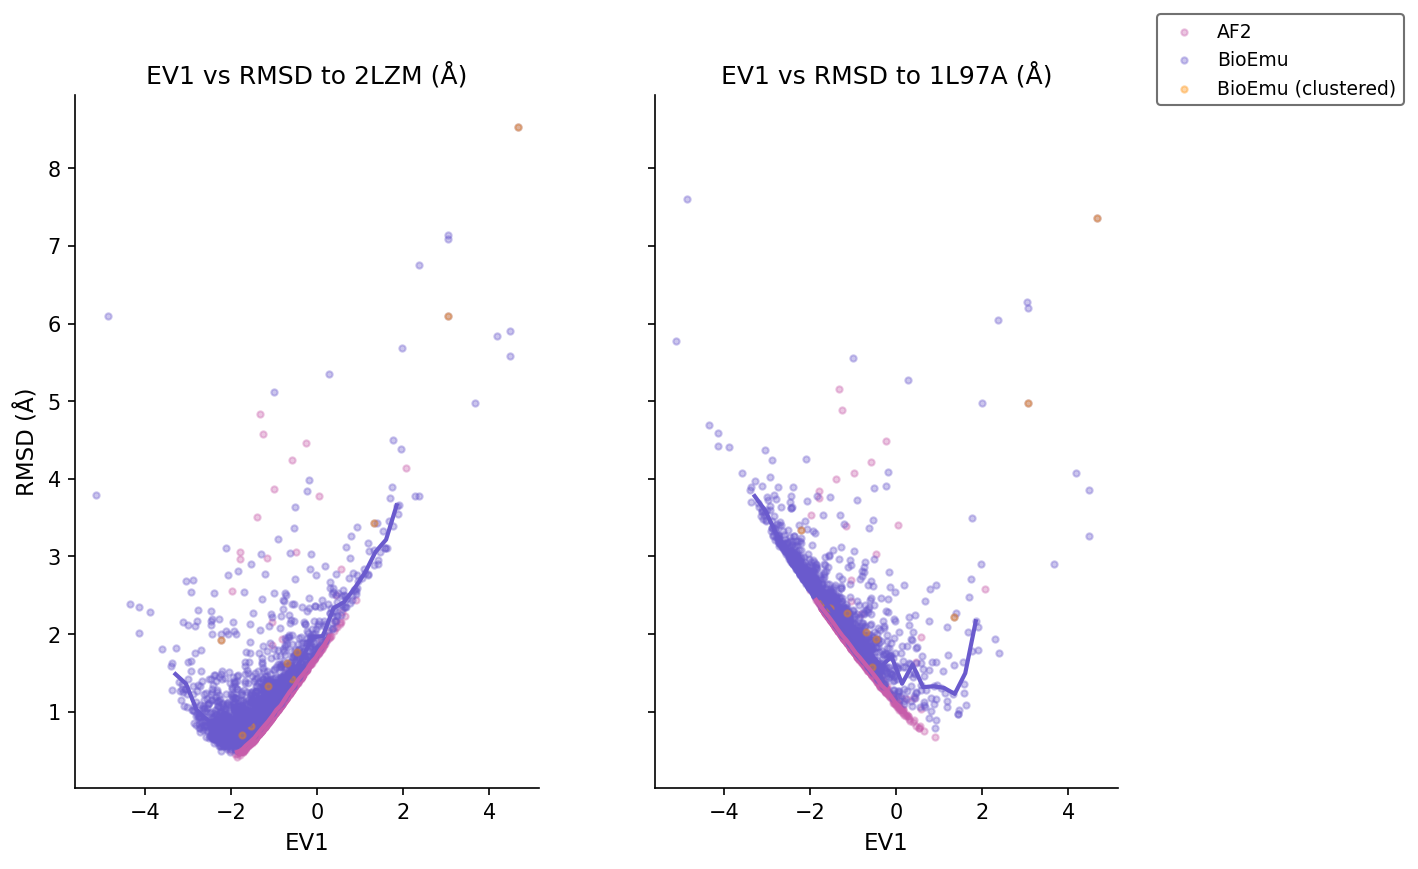


[EV1 vs RMSD] Outputs written:
 Figure:        exports_panel3_5/fig_ev1_vs_rmsd_side_by_side.png
 Figure (PDF):  exports_panel3_5/fig_ev1_vs_rmsd_side_by_side.pdf
 Medians CSV:   exports_panel3_5/ev1_vs_rmsd_binned_medians.csv


In [20]:
# =========================
# §X — EV1 vs RMSD plots (2LZM and 1L97A)
#   • Uses existing EV1 from df_af2 / df_bio (/ df_bioc if present)
#   • Uses RMSD tables already produced in §3.5 (prefers OUT35/rmsd_vs_refs/rmsd_vs_refs_wide.csv)
#   • Colours match the rest of the notebook
#   • Saves one side-by-side figure (10×6) + exports binned-median CSV
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- I/O ------------------------------------------------------
OUT35 = Path(globals().get("OUT35", "exports_panel3_5")); OUT35.mkdir(parents=True, exist_ok=True)
RMSD_WIDE = OUT35 / "rmsd_vs_refs" / "rmsd_vs_refs_wide.csv"
RMSD_NEAR = OUT35 / "nearest_rmsd_refs.csv"  # fallback if wide missing
OUT_FIG   = OUT35 / "fig_ev1_vs_rmsd_side_by_side.png"
OUT_FIG_P = OUT35 / "fig_ev1_vs_rmsd_side_by_side.pdf"
OUT_CSV   = OUT35 / "ev1_vs_rmsd_binned_medians.csv"

# --- Colours (consistent with earlier sections) ---------------
COL_REF     = globals().get("COL_REF", "#333333")
COL_AF2     = globals().get("COL_AF2", "#C75DAB")
COL_BIO     = globals().get("COL_BIO", "#6A5ACD")
COL_BIO_CLU = globals().get("COL_BIO_CLU", "#FF8C00")

# --- Helpers --------------------------------------------------
def _find_col_case_insensitive(df, key="2lzm"):
    """Find a reference RMSD column in df ignoring case (exact or substring)."""
    key = str(key).lower()
    for c in df.columns:
        if str(c).lower() == key:
            return c
    for c in df.columns:
        if key in str(c).lower():
            return c
    raise KeyError(f"Column for reference '{key}' not found in: {list(df.columns)[:12]} ...")

def _load_rmsd_table():
    """Return a DataFrame with at least: model_id, method, rmsd_to_2LZM_A, rmsd_to_1L97A_A (Å)."""
    if RMSD_WIDE.exists():
        df = pd.read_csv(RMSD_WIDE)
        # already in Å with helper columns if produced by §3.5
        if "rmsd_to_2LZM_A" not in df.columns:
            # derive from ref columns if needed
            c2 = _find_col_case_insensitive(df, "2lzm")
            df["rmsd_to_2LZM_A"] = df[c2]
        if "rmsd_to_1L97A_A" not in df.columns:
            cO = _find_col_case_insensitive(df, "1l97a")
            df["rmsd_to_1L97A_A"] = df[cO]
        keep = [c for c in ["model_id","method","rmsd_to_2LZM_A","rmsd_to_1L97A_A"] if c in df.columns]
        return df[keep].copy()
    # fallback to nearest_rmsd_refs.csv (per-reference columns in Å)
    assert RMSD_NEAR.exists(), f"Could not find RMSD tables. Missing {RMSD_WIDE} and {RMSD_NEAR}."
    df = pd.read_csv(RMSD_NEAR)
    c2 = _find_col_case_insensitive(df, "2lzm")
    cO = _find_col_case_insensitive(df, "1l97a")
    keep = ["model_id","method",c2,cO]
    df = df[keep].copy().rename(columns={c2:"rmsd_to_2LZM_A", cO:"rmsd_to_1L97A_A"})
    return df

def _binned_median(x, y, nbins=40, min_per_bin=5):
    """Return (x_bin_centres, y_median) over uniform EV1 bins; NaNs dropped."""
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size == 0:
        return np.array([]), np.array([])
    bins = np.linspace(x.min(), x.max(), nbins+1)
    xc  = 0.5*(bins[:-1] + bins[1:])
    ymed = np.full(nbins, np.nan)
    for i in range(nbins):
        inb = (x >= bins[i]) & (x < bins[i+1] if i < nbins-1 else x <= bins[i+1])
        if inb.sum() >= min_per_bin:
            ymed[i] = np.median(y[inb])
    m2 = np.isfinite(ymed)
    return xc[m2], ymed[m2]

# --- Load/assemble plotting table --------------------------------------------
rmsd_df = _load_rmsd_table()

# Ensure EV1 for each method (merge from df_af2/df_bio/df_bioc)
parts = []
if "df_af2" in globals() and isinstance(df_af2, pd.DataFrame) and len(df_af2):
    parts.append(df_af2[["model_id","ev1"]].assign(method="AF2"))
if "df_bio" in globals() and isinstance(df_bio, pd.DataFrame) and len(df_bio):
    parts.append(df_bio[["model_id","ev1"]].assign(method="BioEmu"))
if "df_bioc" in globals() and isinstance(df_bioc, pd.DataFrame) and len(df_bioc):
    parts.append(df_bioc[["model_id","ev1"]].assign(method="BioEmu (clustered)"))
ev_tbl = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

plot_df = (ev_tbl.merge(rmsd_df, on=["model_id","method"], how="inner")
                 .dropna(subset=["ev1","rmsd_to_2LZM_A","rmsd_to_1L97A_A"]))

# --- Plot: side-by-side EV1 vs RMSD to 2LZM / 1L97A --------------------------
plt.rcParams.update({"figure.dpi":150, "savefig.dpi":300,
                     "axes.spines.top":False, "axes.spines.right":False})

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,6), sharey=True)
plt.subplots_adjust(wspace=0.25, right=0.82)  # room on the right for legend

# method order + colours
methods = [m for m in ["AF2","BioEmu","BioEmu (clustered)"] if m in plot_df["method"].unique()]
cols = { "AF2":COL_AF2, "BioEmu":COL_BIO, "BioEmu (clustered)":COL_BIO_CLU }

# Scatter + binned medians
med_rows = []
for m in methods:
    sub = plot_df[plot_df["method"]==m]
    c = cols.get(m, "0.5")

    # left: vs 2LZM
    axL.scatter(sub["ev1"], sub["rmsd_to_2LZM_A"], s=9, alpha=0.35, color=c, label=m, zorder=1)
    xmed, ymed = _binned_median(sub["ev1"], sub["rmsd_to_2LZM_A"], nbins=40, min_per_bin=5)
    if len(xmed):
        axL.plot(xmed, ymed, lw=2.0, color=c, zorder=2)
        med_rows.append(pd.DataFrame({"method":m, "ref":"2LZM", "ev1_bin":xmed, "median_rmsd_A":ymed}))

    # right: vs 1L97A
    axR.scatter(sub["ev1"], sub["rmsd_to_1L97A_A"], s=9, alpha=0.35, color=c, label=m, zorder=1)
    xmed, ymed = _binned_median(sub["ev1"], sub["rmsd_to_1L97A_A"], nbins=40, min_per_bin=5)
    if len(xmed):
        axR.plot(xmed, ymed, lw=2.0, color=c, zorder=2)
        med_rows.append(pd.DataFrame({"method":m, "ref":"1L97A", "ev1_bin":xmed, "median_rmsd_A":ymed}))

# Axes labels/titles
axL.set_xlabel("EV1")
axR.set_xlabel("EV1")
axL.set_ylabel("RMSD (Å)")
axL.set_title("EV1 vs RMSD to 2LZM (Å)")
axR.set_title("EV1 vs RMSD to 1L97A (Å)")

# Single shared legend outside (top-right)
# Grab handles/labels from the right axis (they’re identical)
h, l = axR.get_legend_handles_labels()
uniq = dict(zip(l, h))
fig.legend([uniq[k] for k in uniq], list(uniq.keys()),
           loc="upper left", bbox_to_anchor=(0.84, 0.98),
           frameon=True, facecolor="white", edgecolor="0.3", fontsize=9)

# Save + show
fig.savefig(OUT_FIG, dpi=300, bbox_inches="tight")
fig.savefig(OUT_FIG_P, dpi=300, bbox_inches="tight")
plt.show()

# --- Export binned medians (publishable-friendly) ----------------------------
df_med = pd.concat(med_rows, ignore_index=True) if med_rows else pd.DataFrame(
    columns=["method","ref","ev1_bin","median_rmsd_A"])
df_med.to_csv(OUT_CSV, index=False)

print("\n[EV1 vs RMSD] Outputs written:")
print(" Figure:       ", OUT_FIG)
print(" Figure (PDF): ", OUT_FIG_P)
print(" Medians CSV:  ", OUT_CSV)


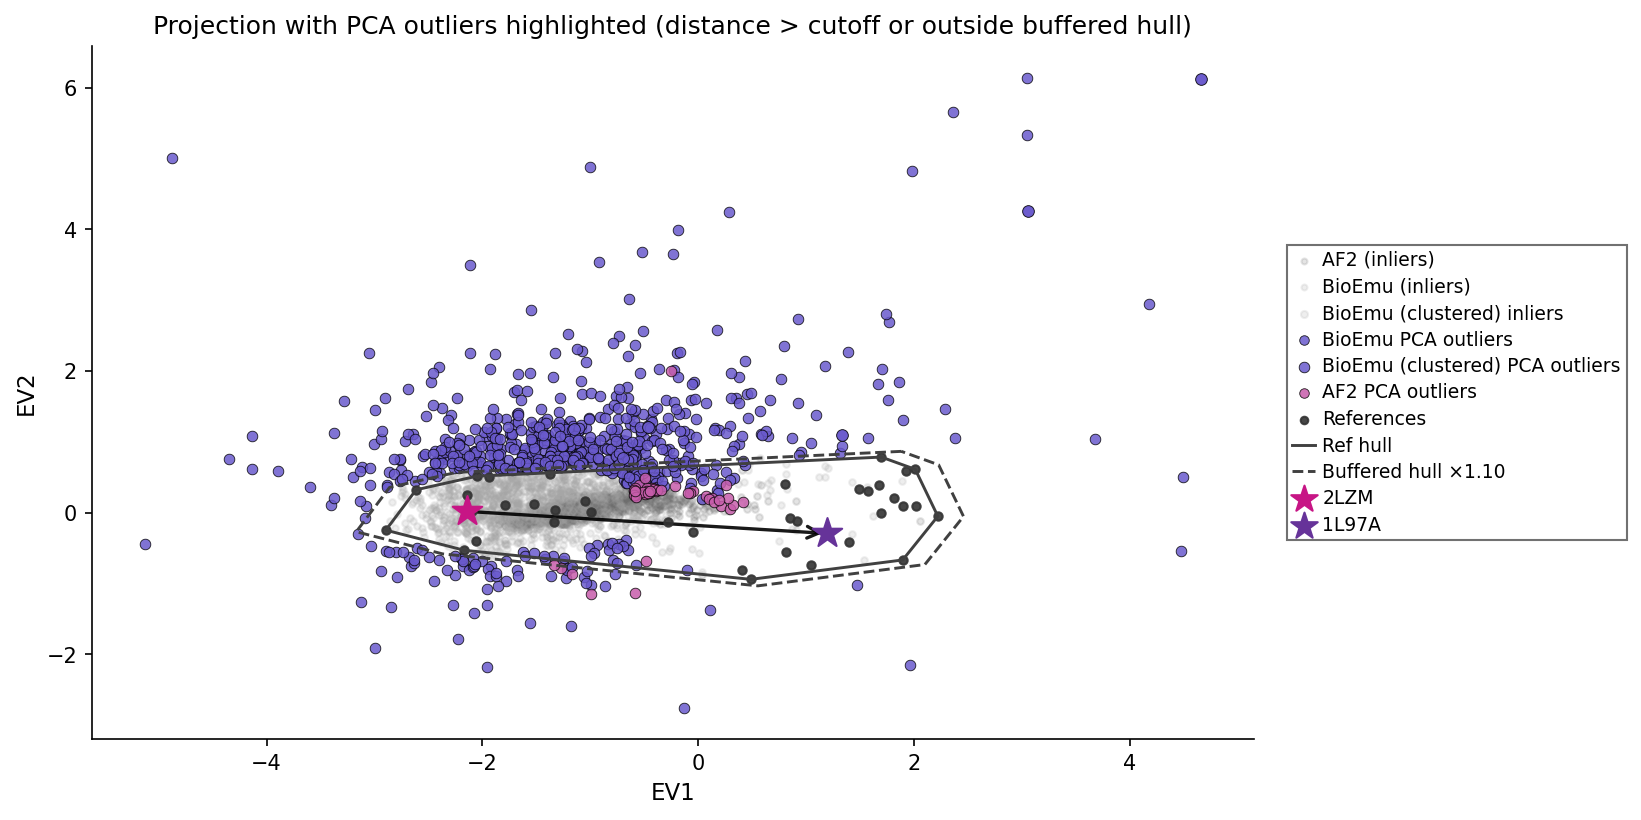

[Fig 3.5.2.2] Saved: exports_panel3_5/fig_3522_pca_outliers.png and exports_panel3_5/fig_3522_pca_outliers.pdf | PCA cutoff = 0.453 EV, HULL_SCALE = 1.10


In [22]:
# =========================
# Figure 3.5.2.2 — PCA projection with outliers highlighted
#   • AF2 & BioEmu (and BioEmu clustered if present)
#   • Inliers drawn in two shades of gray
#   • PCA outliers (distance OR hull) highlighted: AF2→COL_AF2, BioEmu→COL_BIO
#   • Reference convex hull + buffered hull outline (same buffer as elsewhere)
#   • Saves PNG/PDF @ OUT35
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.path import Path as MplPath
from scipy.spatial.distance import cdist

# --- I/O + colours ------------------------------------------------------------
OUT35 = Path(globals().get("OUT35", "exports_panel3_5")); OUT35.mkdir(parents=True, exist_ok=True)

COL_REF     = globals().get("COL_REF", "#333333")
COL_AF2     = globals().get("COL_AF2", "#C75DAB")
COL_BIO     = globals().get("COL_BIO", "#6A5ACD")
COL_BIO_CLU = globals().get("COL_BIO_CLU", "#FF8C00")
COL_CLOSED  = globals().get("COL_CLOSED", "mediumvioletred")
COL_OPEN    = globals().get("COL_OPEN", "rebeccapurple")

# grayscale for backgrounds (two shades)
COL_AF2_BG  = "#6e6e6e"
COL_BIO_BG  = "#a6a6a6"
COL_BIOC_BG = "#bdbdbd"

HULL_SCALE  = float(globals().get("HULL_SCALE", 1.10))  # same buffer as elsewhere
PCA_GLOBAL_CUTOFF = globals().get("PCA_GLOBAL_CUTOFF", None)  # if None → p95(AF2 nearest-PCA)

STAR_KW  = dict(marker="*", s=220, zorder=7)
ARROW_KW = dict(arrowstyle="->", color="black", lw=1.6, mutation_scale=14, alpha=0.9)

# --- Preconditions ------------------------------------------------------------
need = ["df_ref", "df_af2", "df_bio"]
for v in need:
    assert v in globals(), f"[Fig 3.5.2.2] Missing `{v}`."
assert any(c in df_ref.columns for c in ["EV1","ev1"]) and any(c in df_ref.columns for c in ["EV2","ev2"]), "[Fig 3.5.2.2] df_ref needs EV1/EV2"
assert any(c in df_af2.columns for c in ["ev1","EV1"]) and any(c in df_af2.columns for c in ["ev2","EV2"]), "[Fig 3.5.2.2] df_af2 needs ev1/ev2"
assert any(c in df_bio.columns for c in ["ev1","EV1"]) and any(c in df_bio.columns for c in ["ev2","EV2"]), "[Fig 3.5.2.2] df_bio needs ev1/ev2"
HAS_BIOC = ("df_bioc" in globals() and isinstance(df_bioc, pd.DataFrame) and len(df_bioc))

def _evcols(df):
    X = df.columns.str.lower()
    if "ev1" in X and "ev2" in X:
        c1 = df.columns[X.get_loc("ev1")]
        c2 = df.columns[X.get_loc("ev2")]
        return c1, c2
    # fallback: uppercase names in refs
    return "EV1", "EV2"

EV1r, EV2r = _evcols(df_ref)
EV1a, EV2a = _evcols(df_af2)
EV1b, EV2b = _evcols(df_bio)
EV1c, EV2c = (_evcols(df_bioc) if HAS_BIOC else (None, None))

# --- Build reference hull + buffered hull ------------------------------------
EV_refs = df_ref[[EV1r, EV2r]].to_numpy(float)
hull = ConvexHull(EV_refs) if EV_refs.shape[0] >= 3 else None
poly = EV_refs[hull.vertices] if hull is not None else None
if poly is None:
    raise RuntimeError("[Fig 3.5.2.2] Reference hull is ill-defined (need ≥3 non-collinear refs).")
center = poly.mean(axis=0)
poly_buf = center + HULL_SCALE * (poly - center)  # buffered hull
path_buf = MplPath(poly_buf)

# --- Nearest-PCA distances + outlier flags -----------------------------------
def _nearest_pca_dist(P, EV_refs):
    D = cdist(P, EV_refs, metric="euclidean")
    return D.min(axis=1)

AF2_P = df_af2[[EV1a, EV2a]].to_numpy(float)
BIO_P = df_bio[[EV1b, EV2b]].to_numpy(float)
BIOC_P = (df_bioc[[EV1c, EV2c]].to_numpy(float) if HAS_BIOC else np.zeros((0,2)))

AF2_near = _nearest_pca_dist(AF2_P, EV_refs)
BIO_near = _nearest_pca_dist(BIO_P, EV_refs)
BIOC_near = _nearest_pca_dist(BIOC_P, EV_refs) if HAS_BIOC else np.zeros(0)

if PCA_GLOBAL_CUTOFF is None:
    PCA_GLOBAL_CUTOFF = float(np.percentile(AF2_near, 95)) if AF2_near.size else float(np.percentile(np.r_[BIO_near, BIOC_near], 95))
    print(f"[Fig 3.5.2.2] PCA_GLOBAL_CUTOFF set to p95(AF2 nearest-PCA) = {PCA_GLOBAL_CUTOFF:.3f} EV")

def _hull_inside(P, path):
    return path.contains_points(P) if P.size else np.array([], bool)

AF2_in = _hull_inside(AF2_P, path_buf)
BIO_in = _hull_inside(BIO_P, path_buf)
BIOC_in = _hull_inside(BIOC_P, path_buf) if HAS_BIOC else np.array([], bool)

AF2_out = (~AF2_in) | (AF2_near > PCA_GLOBAL_CUTOFF)
BIO_out = (~BIO_in) | (BIO_near > PCA_GLOBAL_CUTOFF)
BIOC_out = ((~BIOC_in) | (BIOC_near > PCA_GLOBAL_CUTOFF)) if HAS_BIOC else np.array([], bool)

# --- Anchors (2LZM, 1L97A) ---------------------------------------------------
def _find_ix_by_substr(ref_df, needle):
    hits = ref_df["PDB"].astype(str).str.contains(needle, case=False, na=False)
    if not hits.any():
        raise ValueError(f"PDB containing '{needle}' not found in df_ref['PDB'].")
    return int(hits.idxmax())
ix_2lzm  = globals().get("ix_2lzm",  _find_ix_by_substr(df_ref, "2lzm"))
ix_1l97a = globals().get("ix_1l97a", _find_ix_by_substr(df_ref, "1l97a"))

# --- Plot --------------------------------------------------------------------
plt.rcParams.update({"figure.dpi":150, "savefig.dpi":300,
                     "axes.spines.top":False, "axes.spines.right":False})

fig, ax = plt.subplots(figsize=(10, 6))

# Inliers (grayscale)
if AF2_P.size:
    ax.scatter(AF2_P[~AF2_out, 0], AF2_P[~AF2_out, 1], s=10, c=COL_AF2_BG, alpha=0.18, label="AF2 (inliers)", zorder=1)
if BIO_P.size:
    ax.scatter(BIO_P[~BIO_out, 0], BIO_P[~BIO_out, 1], s=10, c=COL_BIO_BG, alpha=0.18, label="BioEmu (inliers)", zorder=1)
if HAS_BIOC and BIOC_P.size:
    ax.scatter(BIOC_P[~BIOC_out, 0], BIOC_P[~BIOC_out, 1], s=14, c=COL_BIOC_BG, alpha=0.25, label="BioEmu (clustered) inliers", zorder=1)

# PCA outliers (highlighted by method colour)

if BIO_P.size and BIO_out.any():
    ax.scatter(BIO_P[BIO_out, 0], BIO_P[BIO_out, 1], s=26, c=COL_BIO, alpha=0.85, edgecolors="black", linewidths=0.4,
               label="BioEmu PCA outliers", zorder=4)
if HAS_BIOC and BIOC_P.size and BIOC_out.any():
    # treat clustered outliers as BioEmu-coloured but slightly larger marker
    ax.scatter(BIOC_P[BIOC_out, 0], BIOC_P[BIOC_out, 1], s=32, c=COL_BIO, alpha=0.85, edgecolors="black", linewidths=0.4,
               label="BioEmu (clustered) PCA outliers", zorder=4)
if AF2_P.size and AF2_out.any():
    ax.scatter(AF2_P[AF2_out, 0], AF2_P[AF2_out, 1], s=26, c=COL_AF2, alpha=0.85, edgecolors="black", linewidths=0.4,
               label="AF2 PCA outliers", zorder=4)
    
# Reference points + hulls
ax.scatter(df_ref[EV1r], df_ref[EV2r], s=16, c=COL_REF, alpha=0.9, label="References", zorder=5)

# draw original hull
poly_closed = np.vstack([poly, poly[0]])
ax.plot(poly_closed[:,0], poly_closed[:,1], "-", color="0.25", lw=1.4, label="Ref hull", zorder=6)

# draw buffered hull
poly_buf_closed = np.vstack([poly_buf, poly_buf[0]])
ax.plot(poly_buf_closed[:,0], poly_buf_closed[:,1], "--", color="0.25", lw=1.4,
        label=f"Buffered hull ×{HULL_SCALE:.2f}", zorder=6)

# Anchors + hinge arrow
ax.scatter([df_ref.loc[ix_2lzm, EV1r]], [df_ref.loc[ix_2lzm, EV2r]], c=COL_CLOSED, label="2LZM", **STAR_KW)
ax.scatter([df_ref.loc[ix_1l97a, EV1r]], [df_ref.loc[ix_1l97a, EV2r]], c=COL_OPEN,  label="1L97A", **STAR_KW)
ax.annotate("", xy=(df_ref.loc[ix_1l97a, EV1r], df_ref.loc[ix_1l97a, EV2r]),
                 xytext=(df_ref.loc[ix_2lzm,  EV1r], df_ref.loc[ix_2lzm,  EV2r]),
                 arrowprops=ARROW_KW)

ax.set_xlabel("EV1"); ax.set_ylabel("EV2")
ax.set_title("Projection with PCA outliers highlighted (distance > cutoff or outside buffered hull)")

# Legend outside (right), de-duplicated
h, l = ax.get_legend_handles_labels()
uniq = dict(zip(l, h))
ax.legend([uniq[k] for k in uniq], list(uniq.keys()),
          frameon=True, fancybox=False, edgecolor="0.3", facecolor="white",
          fontsize=9, markerscale=0.9, handlelength=1.2, handletextpad=0.4,
          borderpad=0.3, labelspacing=0.4, loc="center left", bbox_to_anchor=(1.02, 0.5))

# Save
fig.savefig(OUT35/"fig_3522_pca_outliers.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT35/"fig_3522_pca_outliers.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("[Fig 3.5.2.2] Saved:",
      OUT35/"fig_3522_pca_outliers.png", "and",
      OUT35/"fig_3522_pca_outliers.pdf",
      f"| PCA cutoff = {PCA_GLOBAL_CUTOFF:.3f} EV, HULL_SCALE = {HULL_SCALE:.2f}")
